# Business Analytics: optimize marketing expenses for online platform.

### Project tasks:
- How people use the product
- When they start to buy
- How much money each customer brings
- When they pay off

### Initial data:
- visit logs
- orders
- marketing expenses

### Description of the data: 

`visits` (server logs with data on website visits):
* Uid — user's unique identifier
* Device — user's device
* Start Ts — session start date and time
* End Ts — session end date and time
* Source Id — identifier of the ad source the user came from
    * *All dates in this table are in YYYY-MM-DD format.*

`orders` (data on orders):
* Uid — unique identifier of the user making an order
* Buy Ts — order date and time
* Revenue — revenue from the order

`costs` (data on marketing expenses):
* source_id — ad source identifier
* dt — date
* costs — expenses on this ad source on this day

### Decomposition:

- Unique users per day, week, and month
- Sessions per day, week, and month
- Session length distribution
- Sales time lag
- Orders per day, week, and month
- Orderd per cohort
- Average purchase size
- Churn, Retention
- LTV
- CAC
- ROI of sources

## Processing

In [1]:
import pandas as pd

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
import squarify

%matplotlib inline

sns.set_style('darkgrid')

from scipy import stats as st

In [2]:
path = '/datasets/'
visits = pd.read_csv(path+'visits.csv', sep=',')
orders = pd.read_csv(path+'orders.csv', sep=',')
costs = pd.read_csv(path+'costs.csv', sep=',')

In [3]:
alpha=0.05

In [4]:
visits.head()

Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168

In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [6]:
orders.head()

Buy Ts  Revenue                   Uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [8]:
costs.head()

source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
2          1  2017-06-03  36.53
3          1  2017-06-04  55.00
4          1  2017-06-05  57.08

In [9]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [10]:
visits.columns= visits.columns.str.strip().str.lower().str.replace(' ', '_')

orders.columns= orders.columns.str.strip().str.lower().str.replace(' ', '_')

costs.columns= costs.columns.str.strip().str.lower().str.replace(' ', '_')

In [11]:
visits['start_ts'] =  pd.to_datetime(visits['start_ts'])

visits['end_ts'] = pd.to_datetime(visits['end_ts'])

In [12]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [13]:
costs['dt'] = pd.to_datetime(costs['dt'])

## Product (visits)

### How many people use it every day, week, and month?
###  How many sessions are there per day? 
### What is the length of each session?

#### my assumption is that we can't have visits with 0 lenghts, or with negative lenghts. So I'll put them in the separate df and substracted them from the initial df

In [14]:
visits[visits['end_ts']<=visits['start_ts']].head()

device              end_ts  source_id            start_ts  \
2     touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
4   desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   
28  desktop 2017-11-09 15:53:00          4 2017-11-09 15:53:00   
32  desktop 2017-11-30 12:29:00          4 2017-11-30 12:29:00   
54  desktop 2018-02-23 16:52:00         10 2018-02-23 16:52:00   

                     uid  
2    7459035603376831527  
4    9969694820036681168  
28  17892541477379911957  
32  13410401624913285510  
54  13423278602430425332

In [15]:
strange_visits = visits[visits['end_ts']<=visits['start_ts']]

In [16]:
strange_visits.index

Int64Index([     2,      4,     28,     32,     54,     60,     81,     96,
               102,    106,
            ...
            358469, 358471, 358474, 358489, 358507, 358511, 358514, 358522,
            358524, 358529],
           dtype='int64', length=35796)

In [17]:
visits.iloc[~visits.index.isin(strange_visits.index)].head()

device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
5  desktop 2017-09-03 21:36:00          5 2017-09-03 21:35:00   
6  desktop 2018-01-30 12:09:00          1 2018-01-30 11:13:00   

                    uid  
0  16879256277535980062  
1    104060357244891740  
3  16174680259334210214  
5  16007536194108375387  
6   6661610529277171451

In [18]:
visits = visits.iloc[~visits.index.isin(strange_visits.index)]

In [19]:
visits.head()

device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
5  desktop 2017-09-03 21:36:00          5 2017-09-03 21:35:00   
6  desktop 2018-01-30 12:09:00          1 2018-01-30 11:13:00   

                    uid  
0  16879256277535980062  
1    104060357244891740  
3  16174680259334210214  
5  16007536194108375387  
6   6661610529277171451

In [20]:
visits['length'] = visits['end_ts'] - visits['start_ts']

#### I will use minutes as the main meausure units

In [21]:
visits['length'] / np.timedelta64(1,'m')

0         18.000000
1         28.000000
3         24.000000
5          1.000000
6         56.000000
            ...    
359395     0.316667
359396     0.316667
359397     0.316667
359398     0.316667
359399     0.316667
Name: length, Length: 323604, dtype: float64

In [22]:
visits['visit_len'] = visits['length'] / np.timedelta64(1,'m')

In [23]:
visits['visit_len'].describe()

count    323604.000000
mean         11.902825
std          17.105824
min           0.316667
25%           2.000000
50%           6.000000
75%          15.000000
max         711.000000
Name: visit_len, dtype: float64

In [24]:
visits['visit_len'].max()/60

11.85

In [25]:
np.percentile(visits['visit_len'], [90,95,99])

array([28., 40., 78.])

In [26]:
np.percentile(visits['visit_len'], [25,50,75])

array([ 2.,  6., 15.])

In [27]:
visits[visits['visit_len']<=1].shape[0]

53897

In [28]:
visits[visits['visit_len']<=1].shape[0] / visits['visit_len'].shape[0]

0.1665523293902424

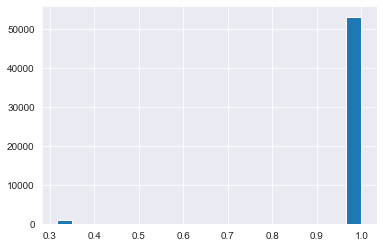

In [29]:
plt.hist(visits[visits['visit_len']<=1]['visit_len'], bins=20)
plt.show()

In [30]:
visits[visits['visit_len']<=1]['visit_len'].describe()

count    53897.000000
mean         0.988995
std          0.086018
min          0.316667
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: visit_len, dtype: float64

In [31]:
visits[visits['visit_len']<1]['visit_len'].shape[0]

868

In [32]:
visits[visits['visit_len']<1].shape[0] / visits['visit_len'].shape[0]

0.0026822907009802104

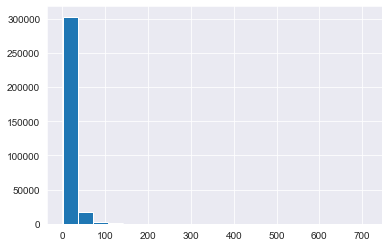

In [33]:
plt.hist(visits['visit_len'], bins=20)
plt.show()

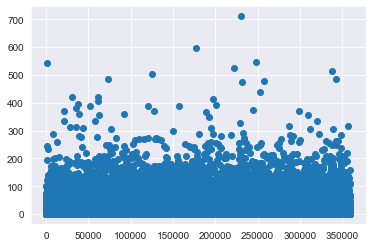

In [34]:
plt.scatter(visits.index,visits['visit_len'])

C:\Users\Yuri\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


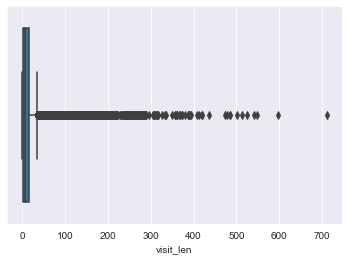

In [35]:
sns.boxplot(visits['visit_len'])

#### 75% of our sessions are in the border of 15 min, 50% are 6 min, and 25% are 2
#### about 17% are <= 1min, iside them we have very quick visits with duration less than a minute and them are 2% of all visits
#### the longest visit is about 12 hours 
#### 99% of visits are inside 78 min, and 90% are inside 28 minutes
#### Such I can assume that user spend:
1) a minute
2) less than 15 min
3) less than 30 min
4) less than 1.5 hour
5) half a day


In [36]:
visits['start_ts'].max()

Timestamp('2018-05-31 23:59:00')

In [37]:
visits['end_ts'].max()

Timestamp('2018-06-01 01:26:00')

#### we have little information about June 2018 hence I'd like to work with data till end of May 2018

In [38]:
visits['visit_day'] = visits['start_ts'].astype('datetime64[D]')

In [39]:
visits['visit_week'] = visits['visit_day'] - pd.to_timedelta(visits['start_ts'].dt.dayofweek, unit='d')

In [40]:
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')

In [41]:
visits['visit_month'].max()

Timestamp('2018-05-01 00:00:00')

In [42]:
visits.groupby('visit_month')['uid'].nunique()

visit_month
2017-06-01    11885
2017-07-01    12725
2017-08-01    10465
2017-09-01    17117
2017-10-01    26794
2017-11-01    29745
2017-12-01    28593
2018-01-01    25930
2018-02-01    25955
2018-03-01    24872
2018-04-01    18821
2018-05-01    18566
Name: uid, dtype: int64

In [43]:
visits.groupby('visit_week')['uid'].nunique()

visit_week
2017-05-29    1816
2017-06-05    3700
2017-06-12    2514
2017-06-19    2565
2017-06-26    2728
2017-07-03    2949
2017-07-10    3876
2017-07-17    3478
2017-07-24    2396
2017-07-31    2118
2017-08-07    2199
2017-08-14    2446
2017-08-21    2801
2017-08-28    3318
2017-09-04    3925
2017-09-11    3903
2017-09-18    4411
2017-09-25    5632
2017-10-02    6883
2017-10-09    6394
2017-10-16    6411
2017-10-23    6652
2017-10-30    6728
2017-11-06    6458
2017-11-13    7321
2017-11-20    9683
2017-11-27    7367
2017-12-04    7632
2017-12-11    7392
2017-12-18    6528
2017-12-25    7044
2018-01-01    6273
2018-01-08    6004
2018-01-15    6297
2018-01-22    6351
2018-01-29    7272
2018-02-05    7120
2018-02-12    7004
2018-02-19    6837
2018-02-26    6627
2018-03-05    6177
2018-03-12    5594
2018-03-19    7137
2018-03-26    4518
2018-04-02    4815
2018-04-09    4912
2018-04-16    5136
2018-04-23    4927
2018-04-30    3493
2018-05-07    3694
2018-05-14    4540
2018-05-21    4428
2

In [44]:
visits.groupby('visit_day')['uid'].nunique()

visit_day
2017-06-01     547
2017-06-02     549
2017-06-03     400
2017-06-04     416
2017-06-05     738
              ... 
2018-05-27     537
2018-05-28     936
2018-05-29     863
2018-05-30    1158
2018-05-31    1826
Name: uid, Length: 364, dtype: int64

Text(0.5, 1.0, 'Unique users per month')

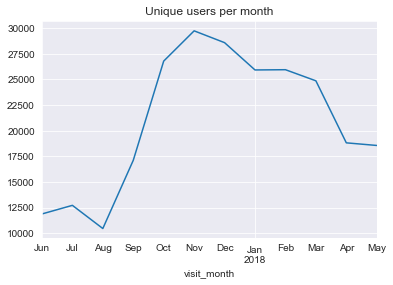

In [45]:
#plt.figure(figsize=(14,4))
visits.groupby('visit_month')['uid'].nunique().plot()
plt.title('Unique users per month')

Text(0.5, 1.0, 'Unique users per week')

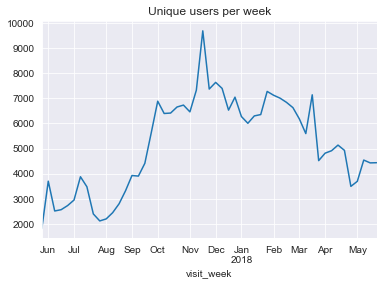

In [46]:
#plt.figure(figsize=(14,4))
visits.groupby('visit_week')['uid'].nunique().plot()
plt.title('Unique users per week')

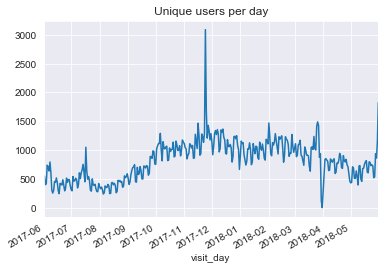

In [47]:
#plt.figure(figsize=(14,4))
visits.groupby('visit_day')['uid'].nunique().plot()
plt.title('Unique users per day')
#plt.tight_layout()
plt.margins(x=0)
plt.show()

In [48]:
visits.head()

device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
5  desktop 2017-09-03 21:36:00          5 2017-09-03 21:35:00   
6  desktop 2018-01-30 12:09:00          1 2018-01-30 11:13:00   

                    uid          length  visit_len  visit_day visit_week  \
0  16879256277535980062 0 days 00:18:00       18.0 2017-12-20 2017-12-18   
1    104060357244891740 0 days 00:28:00       28.0 2018-02-19 2018-02-19   
3  16174680259334210214 0 days 00:24:00       24.0 2018-05-20 2018-05-14   
5  16007536194108375387 0 days 00:01:00        1.0 2017-09-03 2017-08-28   
6   6661610529277171451 0 days 00:56:00       56.0 2018-01-30 2018-01-29   

  visit_month  
0  2017-12-01  
1  2018-02-01  
3  2018-05-01  
5  2017-09-01  
6  2018-01-01

In [49]:
visits.groupby('visit_month')['uid'].count()

visit_month
2017-06-01    14774
2017-07-01    15993
2017-08-01    12912
2017-09-01    21492
2017-10-01    34097
2017-11-01    39795
2017-12-01    37908
2018-01-01    33304
2018-02-01    33548
2018-03-01    32207
2018-04-01    23731
2018-05-01    23843
Name: uid, dtype: int64

In [50]:
visits.groupby('visit_month')['uid'].nunique()

visit_month
2017-06-01    11885
2017-07-01    12725
2017-08-01    10465
2017-09-01    17117
2017-10-01    26794
2017-11-01    29745
2017-12-01    28593
2018-01-01    25930
2018-02-01    25955
2018-03-01    24872
2018-04-01    18821
2018-05-01    18566
Name: uid, dtype: int64

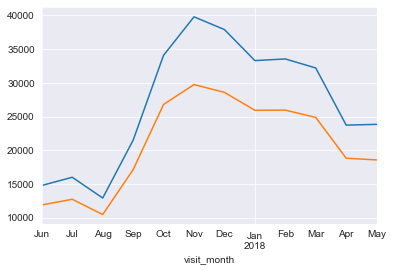

In [51]:
visits.groupby('visit_month')['uid'].count().plot()
visits.groupby('visit_month')['uid'].nunique().plot()

In [52]:
((visits.groupby('visit_month')['uid'].count() / visits.groupby('visit_month')['uid'].nunique())).mean()

1.2785394551821638

Text(0.5, 1.0, 'Average amount of sessions per user per month')

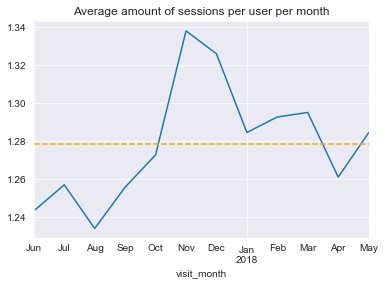

In [53]:
((visits.groupby('visit_month')['uid'].count() / visits.groupby('visit_month')['uid'].nunique())).plot()
plt.axhline(((visits.groupby('visit_month')['uid'].count() / visits.groupby('visit_month')['uid'].nunique())).mean()
            ,color = 'orange'
           , linestyle='--'
           ,label='Average ratio')
#plt.legend(['Average ratio'])
plt.title('Average amount of sessions per user per month')

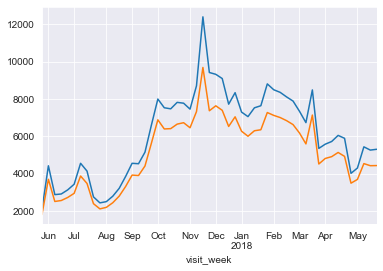

In [54]:
visits.groupby('visit_week')['uid'].count().plot()
visits.groupby('visit_week')['uid'].nunique().plot()

In [55]:
((visits.groupby('visit_week')['uid'].count()/visits.groupby('visit_week')['uid'].nunique())).mean()

1.1787634483083043

Text(0.5, 1.0, 'Average amount of sessions per user per week')

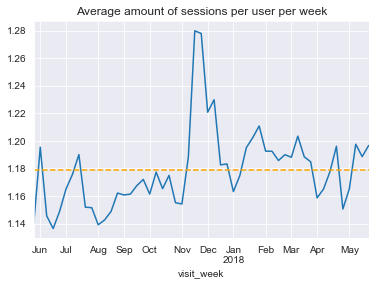

In [56]:
((visits.groupby('visit_week')['uid'].count()/visits.groupby('visit_week')['uid'].nunique())).plot()

plt.axhline(((visits.groupby('visit_week')['uid'].count()/visits.groupby('visit_week')['uid'].nunique())).mean()
           ,color = 'orange'
           , linestyle='--'
           ,label='Average ratio')

plt.title('Average amount of sessions per user per week')

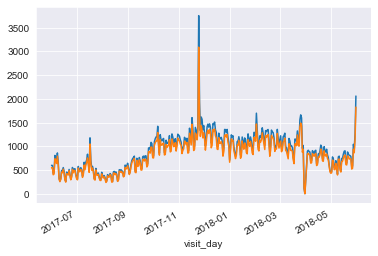

In [57]:
visits.groupby('visit_day')['uid'].count().plot()
visits.groupby('visit_day')['uid'].nunique().plot()

In [58]:
((visits.groupby('visit_day')['uid'].count()/visits.groupby('visit_day')['uid'].nunique())).mean()

1.0820031270674524

Text(0.5, 1.0, 'Average amount of sessions per user per day')

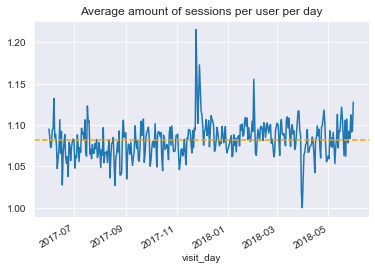

In [59]:
((visits.groupby('visit_day')['uid'].count()/visits.groupby('visit_day')['uid'].nunique())).plot()
plt.axhline(((visits.groupby('visit_day')['uid'].count()/visits.groupby('visit_day')['uid'].nunique())).mean()
           ,color = 'orange'
           , linestyle='--'
           ,label='Average ratio')

plt.title('Average amount of sessions per user per day')

#### On average 1 user monthly make 1.3 sessions, weekly 1.2, daily 1.1

#### through the project I've applyed lots of time approach of calculation average from averages.
The reason is that we have large slices with relatively equal size and the delta in precision is not so crucial here. 

#### Channels (device and source_id)

In [60]:
visits.pivot_table(index='visit_month', columns='device',values='uid',aggfunc='nunique').head()

device       desktop  touch
visit_month                
2017-06-01      8825   3195
2017-07-01      9205   3682
2017-08-01      7829   2735
2017-09-01     12318   4980
2017-10-01     19374   7818

In [61]:
visits.pivot_table(index='visit_month', columns='source_id',values='uid',aggfunc='nunique')

source_id        1       2       3        4       5    6    7       9       10
visit_month                                                                   
2017-06-01    912.0  1384.0  3757.0   3245.0  2588.0  NaN  2.0   664.0   392.0
2017-07-01    987.0  1598.0  3628.0   3684.0  3274.0  1.0  2.0   520.0   294.0
2017-08-01    743.0  1138.0  3053.0   2814.0  2804.0  1.0  1.0   567.0   227.0
2017-09-01   1330.0  1970.0  5220.0   4798.0  4376.0  NaN  3.0   708.0   445.0
2017-10-01   2049.0  3101.0  7623.0   8585.0  6668.0  NaN  5.0   944.0   822.0
2017-11-01   2680.0  3873.0  9170.0  10084.0  5815.0  1.0  1.0  1368.0   799.0
2017-12-01   2585.0  3385.0  8293.0  10632.0  5549.0  1.0  9.0  1106.0   542.0
2018-01-01   2035.0  2903.0  7622.0   9172.0  5156.0  1.0  4.0   955.0   822.0
2018-02-01   2006.0  2896.0  7794.0   8769.0  5300.0  NaN  2.0   934.0   968.0
2018-03-01   2149.0  3056.0  6863.0   8796.0  4140.0  NaN  1.0  1642.0  1029.0
2018-04-01   1513.0  2192.0  4878.0   6460.0  4424.0  NaN  1.0   662.0   527.0
2018-05-01   1632.0  2712.0  4759.0   6432.0  3598.0  NaN  2.0   668.0   694.0

In [62]:
visits.pivot_table(index='visit_month', columns=['device','source_id'],values='uid',aggfunc='nunique')

device      desktop                                                           \
source_id        1       2       3       4       5    6    7       9      10   
visit_month                                                                    
2017-06-01    668.0  1027.0  2993.0  2266.0  1868.0  NaN  1.0   517.0  282.0   
2017-07-01    713.0  1171.0  2821.0  2455.0  2325.0  1.0  2.0   412.0  222.0   
2017-08-01    553.0   876.0  2409.0  1926.0  2122.0  NaN  1.0   448.0  170.0   
2017-09-01    934.0  1445.0  3954.0  3212.0  3145.0  NaN  3.0   564.0  324.0   
2017-10-01   1451.0  2193.0  5836.0  5710.0  4921.0  NaN  3.0   756.0  645.0   
2017-11-01   2024.0  2857.0  7312.0  6963.0  4512.0  1.0  1.0  1044.0  634.0   
2017-12-01   1872.0  2433.0  6507.0  7388.0  4365.0  1.0  8.0   884.0  397.0   
2018-01-01   1414.0  1999.0  5774.0  6056.0  3915.0  1.0  3.0   730.0  565.0   
2018-02-01   1377.0  2039.0  5946.0  5859.0  4035.0  NaN  2.0   733.0  709.0   
2018-03-01   1509.0  2195.0  5289.0  5948.0  3104.0  NaN  1.0  1184.0  705.0   
2018-04-01   1069.0  1589.0  3761.0  4262.0  3263.0  NaN  NaN   493.0  389.0   
2018-05-01   1098.0  1917.0  3608.0  4147.0  2593.0  NaN  1.0   514.0  461.0   

device       touch                                                          
source_id       1       2       3       4       5    6    7      9      10  
visit_month                                                                 
2017-06-01   247.0   375.0   781.0   994.0   723.0  NaN  1.0  152.0  113.0  
2017-07-01   281.0   450.0   826.0  1248.0   956.0  NaN  NaN  113.0   73.0  
2017-08-01   193.0   273.0   655.0   897.0   686.0  1.0  NaN  123.0   58.0  
2017-09-01   400.0   544.0  1292.0  1608.0  1239.0  NaN  NaN  147.0  123.0  
2017-10-01   607.0   947.0  1826.0  2937.0  1769.0  NaN  2.0  194.0  182.0  
2017-11-01   688.0  1075.0  1913.0  3189.0  1319.0  NaN  NaN  333.0  169.0  
2017-12-01   737.0   996.0  1833.0  3322.0  1199.0  NaN  1.0  229.0  147.0  
2018-01-01   636.0   932.0  1884.0  3180.0  1252.0  NaN  1.0  229.0  260.0  
2018-02-01   645.0   886.0  1900.0  2962.0  1278.0  NaN  NaN  206.0  264.0  
2018-03-01   657.0   901.0  1618.0  2899.0  1048.0  NaN  NaN  479.0  332.0  
2018-04-01   451.0   617.0  1137.0  2224.0  1168.0  NaN  1.0  171.0  139.0  
2018-05-01   544.0   830.0  1168.0  2314.0  1015.0  NaN  1.0  156.0  236.0

In [63]:
visits.pivot_table(index='visit_month', columns=['source_id','device'],values='uid',aggfunc='nunique')

source_id        1              2               3               4           \
device      desktop  touch desktop   touch desktop   touch desktop   touch   
visit_month                                                                  
2017-06-01    668.0  247.0  1027.0   375.0  2993.0   781.0  2266.0   994.0   
2017-07-01    713.0  281.0  1171.0   450.0  2821.0   826.0  2455.0  1248.0   
2017-08-01    553.0  193.0   876.0   273.0  2409.0   655.0  1926.0   897.0   
2017-09-01    934.0  400.0  1445.0   544.0  3954.0  1292.0  3212.0  1608.0   
2017-10-01   1451.0  607.0  2193.0   947.0  5836.0  1826.0  5710.0  2937.0   
2017-11-01   2024.0  688.0  2857.0  1075.0  7312.0  1913.0  6963.0  3189.0   
2017-12-01   1872.0  737.0  2433.0   996.0  6507.0  1833.0  7388.0  3322.0   
2018-01-01   1414.0  636.0  1999.0   932.0  5774.0  1884.0  6056.0  3180.0   
2018-02-01   1377.0  645.0  2039.0   886.0  5946.0  1900.0  5859.0  2962.0   
2018-03-01   1509.0  657.0  2195.0   901.0  5289.0  1618.0  5948.0  2899.0   
2018-04-01   1069.0  451.0  1589.0   617.0  3761.0  1137.0  4262.0  2224.0   
2018-05-01   1098.0  544.0  1917.0   830.0  3608.0  1168.0  4147.0  2314.0   

source_id        5               6             7             9          \
device      desktop   touch desktop touch desktop touch desktop  touch   
visit_month                                                              
2017-06-01   1868.0   723.0     NaN   NaN     1.0   1.0   517.0  152.0   
2017-07-01   2325.0   956.0     1.0   NaN     2.0   NaN   412.0  113.0   
2017-08-01   2122.0   686.0     NaN   1.0     1.0   NaN   448.0  123.0   
2017-09-01   3145.0  1239.0     NaN   NaN     3.0   NaN   564.0  147.0   
2017-10-01   4921.0  1769.0     NaN   NaN     3.0   2.0   756.0  194.0   
2017-11-01   4512.0  1319.0     1.0   NaN     1.0   NaN  1044.0  333.0   
2017-12-01   4365.0  1199.0     1.0   NaN     8.0   1.0   884.0  229.0   
2018-01-01   3915.0  1252.0     1.0   NaN     3.0   1.0   730.0  229.0   
2018-02-01   4035.0  1278.0     NaN   NaN     2.0   NaN   733.0  206.0   
2018-03-01   3104.0  1048.0     NaN   NaN     1.0   NaN  1184.0  479.0   
2018-04-01   3263.0  1168.0     NaN   NaN     NaN   1.0   493.0  171.0   
2018-05-01   2593.0  1015.0     NaN   NaN     1.0   1.0   514.0  156.0   

source_id        10         
device      desktop  touch  
visit_month                 
2017-06-01    282.0  113.0  
2017-07-01    222.0   73.0  
2017-08-01    170.0   58.0  
2017-09-01    324.0  123.0  
2017-10-01    645.0  182.0  
2017-11-01    634.0  169.0  
2017-12-01    397.0  147.0  
2018-01-01    565.0  260.0  
2018-02-01    709.0  264.0  
2018-03-01    705.0  332.0  
2018-04-01    389.0  139.0  
2018-05-01    461.0  236.0

In [64]:
visits.pivot_table(index='visit_month', columns='device',values='uid',aggfunc='nunique').mean()

device
desktop    15239.833333
touch       5999.166667
dtype: float64

#### On average monthly 15200 users use desktop and 6000 touch

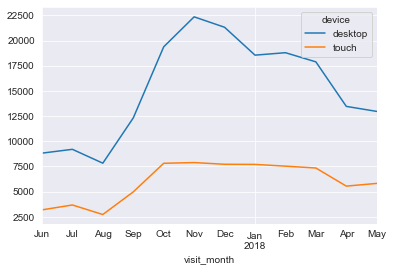

In [65]:
visits.pivot_table(index='visit_month', columns='device',values='uid',aggfunc='nunique').plot()

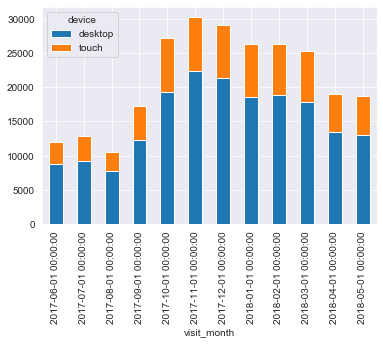

In [66]:
visits.pivot_table(index='visit_month', columns='device',values='uid',aggfunc='nunique').plot(kind='bar', stacked=True)

In [67]:
visits.pivot_table(index='visit_month', columns='source_id',values='uid',aggfunc='nunique').mean()

source_id
1     1718.416667
2     2517.333333
3     6055.000000
4     6955.916667
5     4474.333333
6        1.000000
7        2.750000
9      894.833333
10     630.083333
dtype: float64

#### leading amount of users arrive from sources 4,3 and 5 that are 7000, 6000 and 4500 accordingly,
#### 6 and 7 are about no in use, hence I'll get rid of them for the further analysis

In [68]:
visits[~visits['source_id'].isin([6,7])].pivot_table(index='visit_month', columns='source_id',values='uid',aggfunc='nunique')

source_id      1     2     3      4     5     9     10
visit_month                                           
2017-06-01    912  1384  3757   3245  2588   664   392
2017-07-01    987  1598  3628   3684  3274   520   294
2017-08-01    743  1138  3053   2814  2804   567   227
2017-09-01   1330  1970  5220   4798  4376   708   445
2017-10-01   2049  3101  7623   8585  6668   944   822
2017-11-01   2680  3873  9170  10084  5815  1368   799
2017-12-01   2585  3385  8293  10632  5549  1106   542
2018-01-01   2035  2903  7622   9172  5156   955   822
2018-02-01   2006  2896  7794   8769  5300   934   968
2018-03-01   2149  3056  6863   8796  4140  1642  1029
2018-04-01   1513  2192  4878   6460  4424   662   527
2018-05-01   1632  2712  4759   6432  3598   668   694

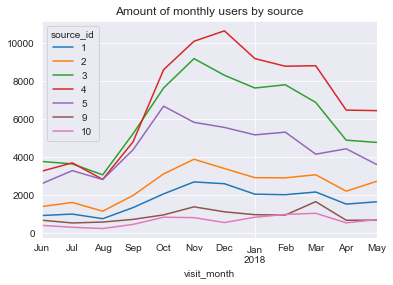

In [69]:
visits[~visits['source_id'].isin([6,7])].pivot_table(index='visit_month', columns='source_id',values='uid',aggfunc='nunique').plot()

plt.title('Amount of monthly users by source')
plt.show()

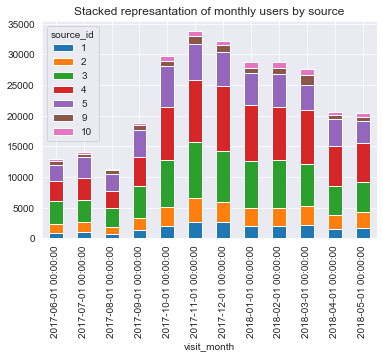

In [70]:
visits[~visits['source_id'].isin([6,7])].pivot_table(index='visit_month', columns='source_id',values='uid',aggfunc='nunique').plot(kind='bar', stacked=True)

plt.title('Stacked represantation of monthly users by source')

plt.show()

In [71]:
visits[~visits['source_id'].isin([6,7])].pivot_table(index='visit_month', columns=['source_id','device'],values='uid',aggfunc='nunique')

source_id        1             2             3             4             5   \
device      desktop touch desktop touch desktop touch desktop touch desktop   
visit_month                                                                   
2017-06-01      668   247    1027   375    2993   781    2266   994    1868   
2017-07-01      713   281    1171   450    2821   826    2455  1248    2325   
2017-08-01      553   193     876   273    2409   655    1926   897    2122   
2017-09-01      934   400    1445   544    3954  1292    3212  1608    3145   
2017-10-01     1451   607    2193   947    5836  1826    5710  2937    4921   
2017-11-01     2024   688    2857  1075    7312  1913    6963  3189    4512   
2017-12-01     1872   737    2433   996    6507  1833    7388  3322    4365   
2018-01-01     1414   636    1999   932    5774  1884    6056  3180    3915   
2018-02-01     1377   645    2039   886    5946  1900    5859  2962    4035   
2018-03-01     1509   657    2195   901    5289  1618    5948  2899    3104   
2018-04-01     1069   451    1589   617    3761  1137    4262  2224    3263   
2018-05-01     1098   544    1917   830    3608  1168    4147  2314    2593   

source_id              9             10        
device      touch desktop touch desktop touch  
visit_month                                    
2017-06-01    723     517   152     282   113  
2017-07-01    956     412   113     222    73  
2017-08-01    686     448   123     170    58  
2017-09-01   1239     564   147     324   123  
2017-10-01   1769     756   194     645   182  
2017-11-01   1319    1044   333     634   169  
2017-12-01   1199     884   229     397   147  
2018-01-01   1252     730   229     565   260  
2018-02-01   1278     733   206     709   264  
2018-03-01   1048    1184   479     705   332  
2018-04-01   1168     493   171     389   139  
2018-05-01   1015     514   156     461   236

In [72]:
pivot_visits_month = visits[~visits['source_id'].isin([6,7])].pivot_table(index='visit_month', columns=['source_id','device'],values='uid',aggfunc='nunique')

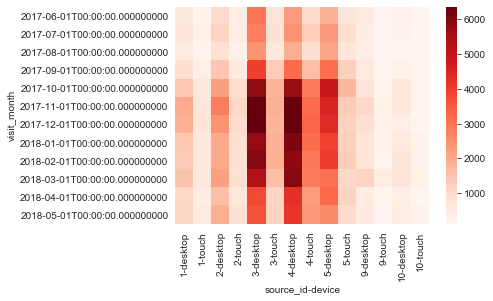

In [73]:
sns.heatmap(pivot_visits_month 
            ,cmap='Reds'
            , robust=True #colors
             ,square=True #size
           )

In [74]:
pivot_visits_month.mean().sort_values(ascending=False)

source_id  device 
3          desktop    4684.166667
4          desktop    4682.666667
5          desktop    3347.333333
4          touch      2314.500000
2          desktop    1811.750000
3          touch      1402.750000
1          desktop    1223.500000
5          touch      1137.666667
2          touch       735.500000
9          desktop     689.916667
1          touch       507.166667
10         desktop     458.583333
9          touch       211.000000
10         touch       174.666667
dtype: float64

#### From top 5 user channels (source+device) 4 of them are on desktop.
#### best combinations by average monthly usage are:
1) 3_desktop    4600
2) 4_desktop    4600
3) 5_desktop    3350
4) 4_touch      2300
5) 2_desktop    1800

In [75]:
visits[~visits['source_id'].isin([6,7])].pivot_table(index='visit_month', columns=['source_id','device'],values='visit_len',aggfunc=np.median)

source_id        1             2             3             4             5   \
device      desktop touch desktop touch desktop touch desktop touch desktop   
visit_month                                                                   
2017-06-01     12.0   7.0     8.0   5.0     6.0   4.0     6.0   4.0     5.0   
2017-07-01     12.0   8.0     9.0   5.0     5.0   4.0     6.0   4.0     6.0   
2017-08-01     12.0   6.0     8.0   5.0     6.0   4.0     5.0   4.0     5.0   
2017-09-01     11.0   7.0     9.0   5.0     6.0   4.0     6.0   4.0     6.0   
2017-10-01     11.0   7.0     9.0   5.0     6.0   4.0     6.0   4.0     6.0   
2017-11-01     13.0   9.0     9.0   7.0     6.0   4.0     7.0   4.0     6.0   
2017-12-01     12.0  10.0     9.0   6.0     6.0   4.0     7.0   5.0     6.0   
2018-01-01     12.0   7.0     9.0   5.0     6.0   4.0     6.0   4.0     6.0   
2018-02-01     13.0   7.0    10.0   5.0     6.0   4.0     6.0   4.0     6.0   
2018-03-01     13.0   8.0     9.0   5.0     6.0   4.0     6.0   4.0     6.0   
2018-04-01     11.0   8.0     8.0   5.0     6.0   4.0     6.0   4.0     5.0   
2018-05-01     11.0   7.5     8.0   5.0     6.0   4.0     6.0   4.0     5.0   

source_id              9             10        
device      touch desktop touch desktop touch  
visit_month                                    
2017-06-01    4.0     5.0   3.0     7.0   6.0  
2017-07-01    4.0     5.0   3.0     6.0   5.0  
2017-08-01    3.0     5.0   4.0     5.0   3.0  
2017-09-01    4.0     7.0   4.0     6.0   6.0  
2017-10-01    4.0     6.0   4.5     7.0   5.0  
2017-11-01    4.0     6.0   4.0     7.0   4.0  
2017-12-01    4.0     5.0   5.0     7.0   4.0  
2018-01-01    4.0     5.0   4.0     9.0   4.0  
2018-02-01    4.0     6.0   4.0     8.0   3.0  
2018-03-01    4.0     7.0   5.0     8.0   4.0  
2018-04-01    4.0     5.0   4.0     6.0   4.0  
2018-05-01    4.0     5.0   3.0     7.0   4.0

In [76]:
pivot_visits_month_length = visits[~visits['source_id'].isin([6,7])].pivot_table(index='visit_month', columns=['source_id','device'],values='visit_len',aggfunc=np.median)

In [77]:
 visits[~visits['source_id'].isin([6,7])].pivot_table(index='visit_month', columns=['source_id','device'],values='visit_len',aggfunc='mean').round()

source_id        1             2             3             4             5   \
device      desktop touch desktop touch desktop touch desktop touch desktop   
visit_month                                                                   
2017-06-01     19.0  13.0    16.0  14.0    10.0   7.0    10.0   8.0    10.0   
2017-07-01     22.0  14.0    17.0  10.0    10.0   8.0    10.0   8.0    10.0   
2017-08-01     21.0  12.0    16.0   9.0    10.0   7.0    10.0   7.0    10.0   
2017-09-01     18.0  11.0    16.0  11.0    10.0   8.0    11.0   8.0    10.0   
2017-10-01     18.0  13.0    15.0  10.0    11.0   8.0    11.0   9.0    10.0   
2017-11-01     23.0  16.0    17.0  16.0    12.0   9.0    13.0   9.0    11.0   
2017-12-01     20.0  16.0    17.0  13.0    12.0   9.0    13.0   9.0    11.0   
2018-01-01     19.0  12.0    19.0  10.0    12.0   9.0    11.0   9.0    11.0   
2018-02-01     21.0  13.0    18.0  11.0    11.0   8.0    11.0   9.0    11.0   
2018-03-01     20.0  14.0    16.0  10.0    12.0   8.0    11.0   9.0    11.0   
2018-04-01     18.0  13.0    16.0   9.0    11.0   8.0    10.0   8.0    10.0   
2018-05-01     18.0  13.0    16.0  10.0    11.0   8.0    10.0   8.0    11.0   

source_id              9             10        
device      touch desktop touch desktop touch  
visit_month                                    
2017-06-01    7.0    10.0   6.0    12.0  10.0  
2017-07-01    7.0    10.0   6.0    10.0  10.0  
2017-08-01    7.0    10.0   9.0    10.0   8.0  
2017-09-01    7.0    11.0   7.0    11.0  10.0  
2017-10-01    8.0    11.0   9.0    12.0   9.0  
2017-11-01    8.0    12.0  10.0    14.0  10.0  
2017-12-01    8.0    11.0  10.0    12.0   9.0  
2018-01-01    8.0    10.0   8.0    16.0   8.0  
2018-02-01    8.0    11.0   7.0    14.0   9.0  
2018-03-01    8.0    13.0   9.0    16.0   9.0  
2018-04-01    7.0     9.0   7.0    12.0   9.0  
2018-05-01    7.0    10.0   7.0    12.0   8.0

In [78]:
pivot_visits_month_length

source_id        1             2             3             4             5   \
device      desktop touch desktop touch desktop touch desktop touch desktop   
visit_month                                                                   
2017-06-01     12.0   7.0     8.0   5.0     6.0   4.0     6.0   4.0     5.0   
2017-07-01     12.0   8.0     9.0   5.0     5.0   4.0     6.0   4.0     6.0   
2017-08-01     12.0   6.0     8.0   5.0     6.0   4.0     5.0   4.0     5.0   
2017-09-01     11.0   7.0     9.0   5.0     6.0   4.0     6.0   4.0     6.0   
2017-10-01     11.0   7.0     9.0   5.0     6.0   4.0     6.0   4.0     6.0   
2017-11-01     13.0   9.0     9.0   7.0     6.0   4.0     7.0   4.0     6.0   
2017-12-01     12.0  10.0     9.0   6.0     6.0   4.0     7.0   5.0     6.0   
2018-01-01     12.0   7.0     9.0   5.0     6.0   4.0     6.0   4.0     6.0   
2018-02-01     13.0   7.0    10.0   5.0     6.0   4.0     6.0   4.0     6.0   
2018-03-01     13.0   8.0     9.0   5.0     6.0   4.0     6.0   4.0     6.0   
2018-04-01     11.0   8.0     8.0   5.0     6.0   4.0     6.0   4.0     5.0   
2018-05-01     11.0   7.5     8.0   5.0     6.0   4.0     6.0   4.0     5.0   

source_id              9             10        
device      touch desktop touch desktop touch  
visit_month                                    
2017-06-01    4.0     5.0   3.0     7.0   6.0  
2017-07-01    4.0     5.0   3.0     6.0   5.0  
2017-08-01    3.0     5.0   4.0     5.0   3.0  
2017-09-01    4.0     7.0   4.0     6.0   6.0  
2017-10-01    4.0     6.0   4.5     7.0   5.0  
2017-11-01    4.0     6.0   4.0     7.0   4.0  
2017-12-01    4.0     5.0   5.0     7.0   4.0  
2018-01-01    4.0     5.0   4.0     9.0   4.0  
2018-02-01    4.0     6.0   4.0     8.0   3.0  
2018-03-01    4.0     7.0   5.0     8.0   4.0  
2018-04-01    4.0     5.0   4.0     6.0   4.0  
2018-05-01    4.0     5.0   3.0     7.0   4.0

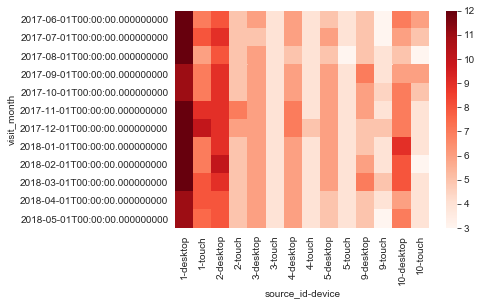

In [79]:
sns.heatmap(pivot_visits_month_length 
            ,cmap='Reds'
            , robust=True #colors
             ,square=True #size
           )

In [80]:
pivot_visits_month_length.median().sort_values(ascending=False)

source_id  device 
1          desktop    12.00
2          desktop     9.00
1          touch       7.25
10         desktop     7.00
5          desktop     6.00
4          desktop     6.00
3          desktop     6.00
9          desktop     5.00
2          touch       5.00
10         touch       4.00
9          touch       4.00
5          touch       4.00
4          touch       4.00
3          touch       4.00
dtype: float64

#### By the session time we have another list of top channels, but the head of them are also on desktop.
#### longest median sesion lenghts in minutes:

1) 1_desktop    12.00
2) 2_desktop     9.00
3) 1_touch       7.25

In [81]:
pivot_visits_month_length.median().median()

5.5

In [82]:
pivot_visits_month_length.median().reindex(pivot_visits_month.mean().sort_values().index)

source_id  device 
10         touch       4.00
9          touch       4.00
10         desktop     7.00
1          touch       7.25
9          desktop     5.00
2          touch       5.00
5          touch       4.00
1          desktop    12.00
3          touch       4.00
2          desktop     9.00
4          touch       4.00
5          desktop     6.00
4          desktop     6.00
3          desktop     6.00
dtype: float64

#### from here I'd like to test few hypothesis about channels:
1) session lenght for source_1 and desktop is the same as source_1 and touch
2) session lenght for source_1 and desktop is the same as source_10 and desktop

In [83]:
a = 1
b= 10

c='desktop'
d='touch'

In [84]:
sample_ac = visits[(visits['source_id']==a)&(visits['device']==c)]['visit_len']

In [85]:
np.var(sample_ac)

688.5393649923794

In [86]:
sample_ad = visits[(visits['source_id']==a)&(visits['device']==d)]['visit_len']

In [87]:
np.var(sample_ad)

330.3253579504623

In [88]:
sample_bc = visits[(visits['source_id']==b)&(visits['device']==c)]['visit_len']

In [89]:
np.var(sample_bc)

359.505567357312

In [90]:
p1 = st.ttest_ind(sample_ac
             , sample_ad
                          , equal_var=False)[1]

In [91]:
if (p1 < alpha):
        print("Rejecting the null hypothesis")
else:
        print("Failed to reject the null hypothesis")

Rejecting the null hypothesis


In [92]:
p2 = st.ttest_ind(sample_ac
             , sample_bc
                          , equal_var=False)[1]

In [93]:
if (p2 < alpha):
        print("Rejecting the null hypothesis")
else:
        print("Failed to reject the null hypothesis")

Rejecting the null hypothesis


#### Hence with 95% confidence I can conclude that the average lenght of the session for different sources and devices is different 

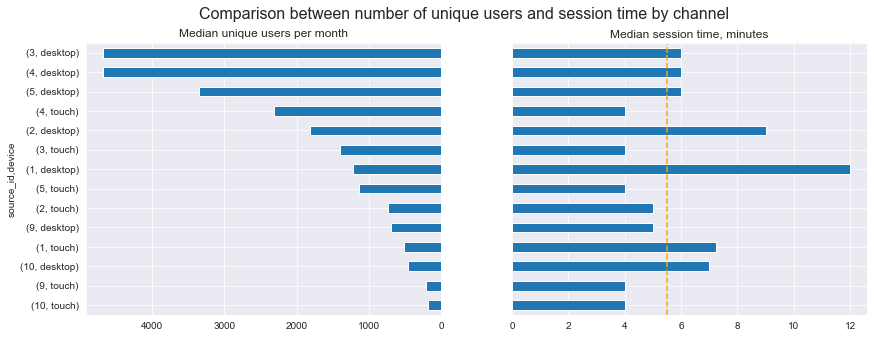

In [94]:
fig, axs = plt.subplots(ncols=2, sharey=True,figsize=(14,5))

fig.suptitle("Comparison between number of unique users and session time by channel", fontsize=16)

pivot_visits_month.mean().sort_values(#ascending=False
).plot(kind='barh'
       , ax=axs[0]
      )

axs[0].invert_xaxis()
axs[0].title.set_text('Median unique users per month')


pivot_visits_month_length.median().reindex(pivot_visits_month.mean().sort_values().index).plot(kind='barh'
                                                                                               , ax=axs[1]
                                                                                              )


axs[1].title.set_text('Median session time, minutes')

plt.axvline(pivot_visits_month_length.median().median()
            ,color = 'orange'
           , linestyle='--'
           ,label='Average ratio')

#plt.legend()

### How often do users come back? (Retention, Churn)

#### returning users in general

In [95]:
visits.groupby('uid')['uid'].count()[visits.groupby('uid')['uid'].count()>1]

uid
313578113262317         3
325320750514679         2
526778907996220         4
577434573913691         2
1260655184775459        4
                       ..
18445601152732270159    3
18445884613277162497    3
18446156210226471712    7
18446167067214817906    2
18446621818809592527    2
Name: uid, Length: 46552, dtype: int64

In [96]:
visits.groupby('uid')['uid'].count()[visits.groupby('uid')['uid'].count()>1].count()

46552

In [97]:
visits.groupby('uid')['uid'].nunique()

uid
11863502262781          1
49537067089222          1
297729379853735         1
313578113262317         1
325320750514679         1
                       ..
18446316582013423015    1
18446403737806311543    1
18446556406699109058    1
18446621818809592527    1
18446676030785672386    1
Name: uid, Length: 207051, dtype: int64

In [98]:
visits.groupby('uid')['uid'].nunique().shape[0]

207051

In [99]:
visits.groupby('uid')['uid'].count()[visits.groupby('uid')['uid'].count()>1].shape[0] / visits.groupby('uid')['uid'].nunique().shape[0]

0.22483349512921938

#### we have about 207000 users in total, abour 23% of them are returning, that is about 46500

In [100]:
visits.groupby(['visit_month','uid'])['uid'].count()

visit_month  uid                 
2017-06-01   297729379853735         1
             407573351275847         1
             1349311730029478        1
             1575281904278712        2
             2471247936243530        2
                                    ..
2018-05-01   18438729003678071174    1
             18441550152575478608    1
             18442532203075236007    1
             18444274829404759216    1
             18446621818809592527    1
Name: uid, Length: 251468, dtype: int64

In [101]:
visits.groupby(['visit_month','uid'])['uid'].count()[visits.groupby(['visit_month','uid'])['uid'].count()>1]

visit_month  uid                 
2017-06-01   1575281904278712        2
             2471247936243530        2
             29085576454138824       2
             43862811563969857       2
             63862661827066303       7
                                    ..
2018-05-01   18397679766809672220    4
             18401865544954459618    3
             18409318621202949913    2
             18420545577003099076    2
             18422001115578845489    2
Name: uid, Length: 35812, dtype: int64

In [102]:
visits.groupby(['visit_month','uid'])['uid'].count()[visits.groupby(['visit_month','uid'])['uid'].count()>1].groupby('visit_month').count()

visit_month
2017-06-01    1500
2017-07-01    1712
2017-08-01    1197
2017-09-01    2280
2017-10-01    3913
2017-11-01    4920
2017-12-01    4489
2018-01-01    3547
2018-02-01    3635
2018-03-01    3627
2018-04-01    2416
2018-05-01    2576
Name: uid, dtype: int64

In [103]:
(visits.groupby(['visit_month','uid'])['uid'].count()[visits.groupby(['visit_month','uid'])['uid'].count()>1].groupby('visit_month').count()).mean()

2984.3333333333335

Text(0.5, 1.0, 'Amount of returning users by month')

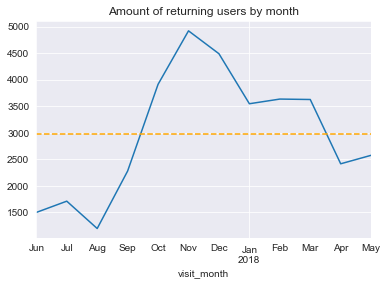

In [104]:
visits.groupby(['visit_month','uid'])['uid'].count()[visits.groupby(['visit_month','uid'])['uid'].count()>1].groupby('visit_month').count().plot()

plt.axhline(
(visits.groupby(['visit_month','uid'])['uid'].count()[visits.groupby(['visit_month','uid'])['uid'].count()>1].groupby('visit_month').count()).mean()
    ,color = 'orange'
           , linestyle='--'
)

plt.title('Amount of returning users by month')

In [105]:
visits.groupby(['visit_month'])['uid'].nunique()

visit_month
2017-06-01    11885
2017-07-01    12725
2017-08-01    10465
2017-09-01    17117
2017-10-01    26794
2017-11-01    29745
2017-12-01    28593
2018-01-01    25930
2018-02-01    25955
2018-03-01    24872
2018-04-01    18821
2018-05-01    18566
Name: uid, dtype: int64

In [106]:
visits.groupby(['visit_month'])['uid'].nunique().mean()

20955.666666666668

Text(0.5, 1.0, 'Monthly unique visitors')

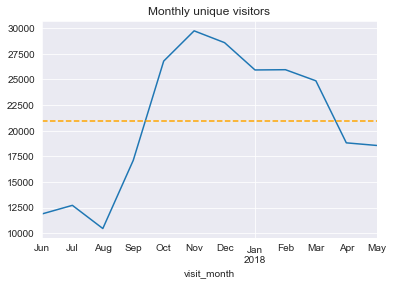

In [107]:
visits.groupby(['visit_month'])['uid'].nunique().plot()

plt.axhline(visits.groupby(['visit_month'])['uid'].nunique().mean()
 ,color = 'orange'
           , linestyle='--'
)


plt.title('Monthly unique visitors')

Text(0.5, 1.0, 'Monthly dynamic of users')

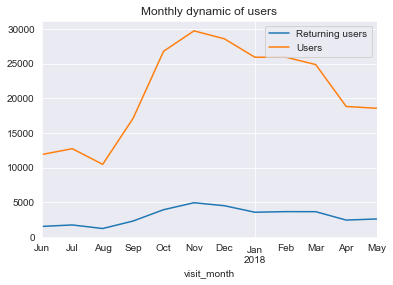

In [108]:
visits.groupby(['visit_month','uid'])['uid'].count()[visits.groupby(['visit_month','uid'])['uid'].count()>1].groupby('visit_month').count().plot(label='Returning users')

visits.groupby(['visit_month'])['uid'].nunique().plot(label='Users')

plt.legend()

plt.title("Monthly dynamic of users")

In [109]:
visits.groupby(['visit_month','uid'])['uid'].count()[visits.groupby(['visit_month','uid'])['uid'].count()>1].groupby('visit_month').count() / visits.groupby(['visit_month'])['uid'].nunique()

visit_month
2017-06-01    0.126210
2017-07-01    0.134538
2017-08-01    0.114381
2017-09-01    0.133201
2017-10-01    0.146040
2017-11-01    0.165406
2017-12-01    0.156996
2018-01-01    0.136791
2018-02-01    0.140050
2018-03-01    0.145827
2018-04-01    0.128367
2018-05-01    0.138748
Name: uid, dtype: float64

In [110]:
(visits.groupby(['visit_month','uid'])['uid'].count()[visits.groupby(['visit_month','uid'])['uid'].count()>1].groupby('visit_month').count() / visits.groupby(['visit_month'])['uid'].nunique()).mean()

0.13887967968379158

#### Monthly we have on average 21000 visitors and 3000 returning visitors, that is about 14 %

Text(0.5, 1.0, 'Average monthly ratio of returning users')

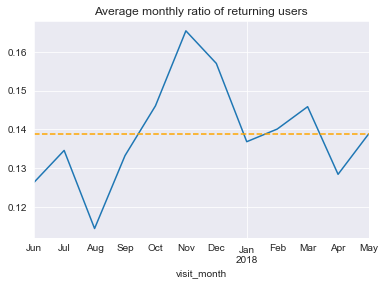

In [111]:
(visits.groupby(['visit_month','uid'])['uid'].count()[visits.groupby(['visit_month','uid'])['uid'].count()>1].groupby('visit_month').count() / visits.groupby(['visit_month'])['uid'].nunique()).plot()


plt.axhline((visits.groupby(['visit_month','uid'])['uid'].count()[visits.groupby(['visit_month','uid'])['uid'].count()>1].groupby('visit_month').count() / visits.groupby(['visit_month'])['uid'].nunique()).mean()
            ,color = 'orange'
           , linestyle='--'
           ,label='Average ratio')

plt.title('Average monthly ratio of returning users')

#### Visits cohorts

In [112]:
visits.groupby(['uid'])['visit_week'].min().rename('first_visit_week').head()

uid
11863502262781    2018-02-26
49537067089222    2018-02-05
297729379853735   2017-06-05
313578113262317   2017-09-18
325320750514679   2017-09-25
Name: first_visit_week, dtype: datetime64[ns]

In [113]:
visits = pd.merge(visits, visits.groupby(['uid'])['visit_week'].min().rename('first_visit_week'), left_on='uid', right_index=True , how='left')

In [114]:
visits.groupby(['uid'])['visit_month'].min().rename('first_visit_month').head()

uid
11863502262781    2018-03-01
49537067089222    2018-02-01
297729379853735   2017-06-01
313578113262317   2017-09-01
325320750514679   2017-09-01
Name: first_visit_month, dtype: datetime64[ns]

In [115]:
visits = pd.merge(visits, visits.groupby(['uid'])['visit_month'].min().rename('first_visit_month'), left_on='uid', right_index=True , how='left')

In [116]:
visits['cohort_lifetime_month'] = visits['visit_month'] - visits['first_visit_month']

In [117]:
visits['cohort_lifetime_month'] = visits['cohort_lifetime_month'] / np.timedelta64(1,'M')

In [118]:
visits['cohort_lifetime_month'] = visits['cohort_lifetime_month'].round().astype(int)

In [119]:
visits['cohort_lifetime_week'] = visits['visit_week'] - visits['first_visit_week']

visits['cohort_lifetime_week'] = visits['cohort_lifetime_week'] / np.timedelta64(1,'W')

visits['cohort_lifetime_week'] = visits['cohort_lifetime_week'].round().astype(int)

In [120]:
visits.head()

device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
5  desktop 2017-09-03 21:36:00          5 2017-09-03 21:35:00   
6  desktop 2018-01-30 12:09:00          1 2018-01-30 11:13:00   

                    uid          length  visit_len  visit_day visit_week  \
0  16879256277535980062 0 days 00:18:00       18.0 2017-12-20 2017-12-18   
1    104060357244891740 0 days 00:28:00       28.0 2018-02-19 2018-02-19   
3  16174680259334210214 0 days 00:24:00       24.0 2018-05-20 2018-05-14   
5  16007536194108375387 0 days 00:01:00        1.0 2017-09-03 2017-08-28   
6   6661610529277171451 0 days 00:56:00       56.0 2018-01-30 2018-01-29   

  visit_month first_visit_week first_visit_month  cohort_lifetime_month  \
0  2017-12-01       2017-12-18        2017-12-01                      0   
1  2018-02-01       2018-02-19        2018-02-01                      0   
3  2018-05-01       2018-03-05        2018-03-01                      2   
5  2017-09-01       2017-08-28        2017-09-01                      0   
6  2018-01-01       2017-06-26        2017-06-01                      7   

   cohort_lifetime_week  
0                     0  
1                     0  
3                    10  
5                     0  
6                    31

#### retention_monthly

In [121]:
visits.pivot_table(index = 'first_visit_month'
                  ,columns = 'cohort_lifetime_month'
                   ,values = 'uid'
                   ,aggfunc = 'nunique'
                  )

cohort_lifetime_month       0       1       2      3      4      5      6   \
first_visit_month                                                            
2017-06-01             11885.0   900.0   606.0  710.0  777.0  802.0  686.0   
2017-07-01             11825.0   645.0   596.0  658.0  670.0  550.0  521.0   
2017-08-01              9214.0   686.0   557.0  557.0  442.0  382.0  334.0   
2017-09-01             15125.0  1264.0  1025.0  746.0  576.0  559.0  535.0   
2017-10-01             23538.0  1839.0  1196.0  890.0  792.0  734.0  489.0   
2017-11-01             24852.0  1943.0  1062.0  940.0  810.0  540.0  512.0   
2017-12-01             23030.0  1259.0   841.0  695.0  448.0  408.0    NaN   
2018-01-01             20573.0  1189.0   778.0  501.0  396.0    NaN    NaN   
2018-02-01             20173.0  1141.0   490.0  387.0    NaN    NaN    NaN   
2018-03-01             18793.0   766.0   480.0    NaN    NaN    NaN    NaN   
2018-04-01             14215.0   675.0     NaN    NaN    NaN    NaN    NaN   
2018-05-01             13828.0     NaN     NaN    NaN    NaN    NaN    NaN   

cohort_lifetime_month     7      8      9      10     11  
first_visit_month                                         
2017-06-01             667.0  606.0  591.0  453.0  522.0  
2017-07-01             521.0  448.0  323.0  320.0    NaN  
2017-08-01             347.0  250.0  228.0    NaN    NaN  
2017-09-01             346.0  344.0    NaN    NaN    NaN  
2017-10-01             466.0    NaN    NaN    NaN    NaN  
2017-11-01               NaN    NaN    NaN    NaN    NaN  
2017-12-01               NaN    NaN    NaN    NaN    NaN  
2018-01-01               NaN    NaN    NaN    NaN    NaN  
2018-02-01               NaN    NaN    NaN    NaN    NaN  
2018-03-01               NaN    NaN    NaN    NaN    NaN  
2018-04-01               NaN    NaN    NaN    NaN    NaN  
2018-05-01               NaN    NaN    NaN    NaN    NaN

In [122]:
cohort_pivot_monthly = visits.pivot_table(index = 'first_visit_month'
                  ,columns = 'cohort_lifetime_month'
                   ,values = 'uid'
                   ,aggfunc = 'nunique'
                  )

In [123]:
cohort_pivot_monthly.iloc[:,0]

first_visit_month
2017-06-01    11885.0
2017-07-01    11825.0
2017-08-01     9214.0
2017-09-01    15125.0
2017-10-01    23538.0
2017-11-01    24852.0
2017-12-01    23030.0
2018-01-01    20573.0
2018-02-01    20173.0
2018-03-01    18793.0
2018-04-01    14215.0
2018-05-01    13828.0
Name: 0, dtype: float64

In [124]:
cohort_pivot_monthly.iloc[:,0].mean()

17254.25

#### average monthly cohort is about 17200 users

In [125]:
cohort_size_monthly = cohort_pivot_monthly.iloc[:,0]

Text(0.5, 1.0, 'Monthly cohort size')

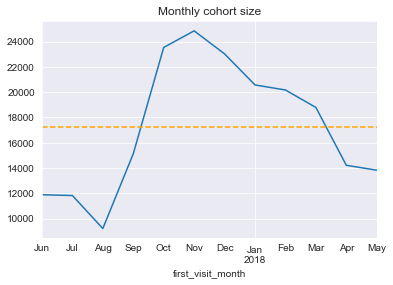

In [126]:
cohort_size_monthly.plot()

plt.axhline(
cohort_pivot_monthly.iloc[:,0].mean()
    ,color = 'orange'
           , linestyle='--'
)


plt.title('Monthly cohort size')

Text(0.5, 1.0, 'Monthly cohort size and total unique visitors')

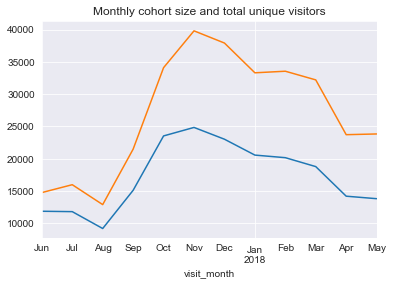

In [127]:
cohort_size_monthly.plot()
visits.groupby('visit_month')['uid'].count().plot()

plt.title('Monthly cohort size and total unique visitors')

In [128]:
cohort_size_monthly / visits.groupby('visit_month')['uid'].count()

first_visit_month
2017-06-01    0.804454
2017-07-01    0.739386
2017-08-01    0.713600
2017-09-01    0.703750
2017-10-01    0.690325
2017-11-01    0.624501
2017-12-01    0.607523
2018-01-01    0.617734
2018-02-01    0.601318
2018-03-01    0.583507
2018-04-01    0.599006
2018-05-01    0.579961
dtype: float64

In [129]:
(cohort_size_monthly / visits.groupby('visit_month')['uid'].count()).mean()

0.6554218624254687

#### on average the new cohort size is about 66% of total unique visitors

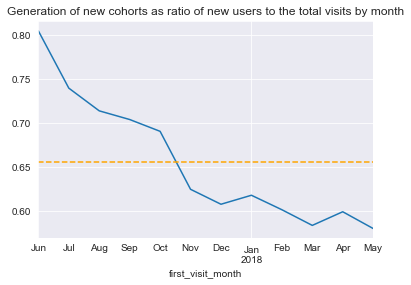

In [130]:
(cohort_size_monthly / visits.groupby('visit_month')['uid'].count()).plot()
plt.title("Generation of new cohorts as ratio of new users to the total visits by month")

plt.axhline((cohort_size_monthly / visits.groupby('visit_month')['uid'].count()).mean()
           ,color = 'orange'
           , linestyle='--'
           )

#### I can notice negative tendency in cohort size ratio

#### Form here I'd like to test the null hypothesis, that the ratio between users from newly generated cohort and total unique visitors didn't change in May 2018 compare to January 2017

In [131]:
v = visits[['visit_month','first_visit_month']].copy()

In [132]:
a = '2018-05-01'

In [133]:
b = '2017-12-01'

In [134]:
v['indicator_for_sample'] = v.apply(lambda row:1 if row['visit_month']== row['first_visit_month'] else 0, axis =1)

In [135]:
sample_a = v[v['visit_month']==a]['indicator_for_sample']

sample_b = v[v['visit_month']==b]['indicator_for_sample']

In [136]:
np.var(sample_a) == np.var(sample_b)

False

In [137]:
np.var(sample_a)

0.22412250838103168

In [138]:
np.var(sample_b)

0.20215276531457013

In [139]:
st.ttest_ind(sample_a, sample_b, equal_var=False)

Ttest_indResult(statistic=-15.078037520661507, pvalue=2.9495248723695955e-51)

In [140]:
p_value = st.ttest_ind(sample_a, sample_b, equal_var=False)[1]

In [141]:
if (p_value < alpha):
        print("Rejecting the null hypothesis")
else:
        print("Failed to reject the null hypothesis")

Rejecting the null hypothesis


#### From here I can conclude with 95% confidence that  the ratio between users from newly generated cohort and total unique visitors is not the same, and according to the tendancy it has negative slope

In [142]:
cohort_pivot_monthly.divide(cohort_size_monthly, axis = 0)

cohort_lifetime_month   0         1         2         3         4         5   \
first_visit_month                                                              
2017-06-01             1.0  0.075726  0.050989  0.059739  0.065377  0.067480   
2017-07-01             1.0  0.054545  0.050402  0.055645  0.056660  0.046512   
2017-08-01             1.0  0.074452  0.060451  0.060451  0.047970  0.041459   
2017-09-01             1.0  0.083570  0.067769  0.049322  0.038083  0.036959   
2017-10-01             1.0  0.078129  0.050811  0.037811  0.033648  0.031184   
2017-11-01             1.0  0.078183  0.042733  0.037824  0.032593  0.021729   
2017-12-01             1.0  0.054668  0.036518  0.030178  0.019453  0.017716   
2018-01-01             1.0  0.057794  0.037817  0.024352  0.019249       NaN   
2018-02-01             1.0  0.056561  0.024290  0.019184       NaN       NaN   
2018-03-01             1.0  0.040760  0.025541       NaN       NaN       NaN   
2018-04-01             1.0  0.047485       NaN       NaN       NaN       NaN   
2018-05-01             1.0       NaN       NaN       NaN       NaN       NaN   

cohort_lifetime_month        6         7         8         9         10  \
first_visit_month                                                         
2017-06-01             0.057720  0.056121  0.050989  0.049727  0.038115   
2017-07-01             0.044059  0.044059  0.037886  0.027315  0.027061   
2017-08-01             0.036249  0.037660  0.027133  0.024745       NaN   
2017-09-01             0.035372  0.022876  0.022744       NaN       NaN   
2017-10-01             0.020775  0.019798       NaN       NaN       NaN   
2017-11-01             0.020602       NaN       NaN       NaN       NaN   
2017-12-01                  NaN       NaN       NaN       NaN       NaN   
2018-01-01                  NaN       NaN       NaN       NaN       NaN   
2018-02-01                  NaN       NaN       NaN       NaN       NaN   
2018-03-01                  NaN       NaN       NaN       NaN       NaN   
2018-04-01                  NaN       NaN       NaN       NaN       NaN   
2018-05-01                  NaN       NaN       NaN       NaN       NaN   

cohort_lifetime_month        11  
first_visit_month                
2017-06-01             0.043921  
2017-07-01                  NaN  
2017-08-01                  NaN  
2017-09-01                  NaN  
2017-10-01                  NaN  
2017-11-01                  NaN  
2017-12-01                  NaN  
2018-01-01                  NaN  
2018-02-01                  NaN  
2018-03-01                  NaN  
2018-04-01                  NaN  
2018-05-01                  NaN

In [143]:
retention_matrix_monthly = cohort_pivot_monthly.divide(cohort_size_monthly, axis = 0)

In [144]:
retention_matrix_monthly.index

DatetimeIndex(['2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01'],
              dtype='datetime64[ns]', name='first_visit_month', freq=None)

In [145]:
retention_matrix_monthly.index = retention_matrix_monthly.index.strftime("%Y-%m")

In [146]:
cohort_size_monthly_df = pd.DataFrame(cohort_size_monthly).rename(columns={0: 'cohort_size'})

In [147]:
cohort_size_monthly_df.index

DatetimeIndex(['2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01'],
              dtype='datetime64[ns]', name='first_visit_month', freq=None)

In [148]:
cohort_size_monthly_df.index = cohort_size_monthly_df.index.strftime("%Y-%m")

#### the gap between the first month and the next one in each cohort is very high and the further volatility is very low. Hence I've decided to ommit it and such we can see more precise analysis

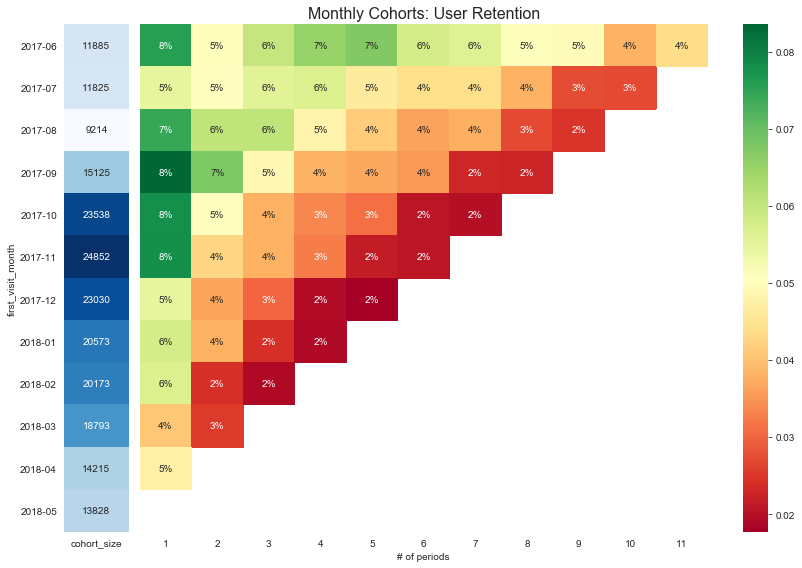

In [149]:
with sns.axes_style("white"):    
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix_monthly.iloc[:,1:], 
                #mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')


    # cohort size
    
    sns.heatmap(cohort_size_monthly_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap='Blues', 
                ax=ax[0])

    fig.tight_layout()

In [150]:
retention_matrix_monthly.unstack(0).unstack()[1:]

first_visit_month       2017-06   2017-07   2017-08   2017-09   2017-10  \
cohort_lifetime_month                                                     
1                      0.075726  0.054545  0.074452  0.083570  0.078129   
2                      0.050989  0.050402  0.060451  0.067769  0.050811   
3                      0.059739  0.055645  0.060451  0.049322  0.037811   
4                      0.065377  0.056660  0.047970  0.038083  0.033648   
5                      0.067480  0.046512  0.041459  0.036959  0.031184   
6                      0.057720  0.044059  0.036249  0.035372  0.020775   
7                      0.056121  0.044059  0.037660  0.022876  0.019798   
8                      0.050989  0.037886  0.027133  0.022744       NaN   
9                      0.049727  0.027315  0.024745       NaN       NaN   
10                     0.038115  0.027061       NaN       NaN       NaN   
11                     0.043921       NaN       NaN       NaN       NaN   

first_visit_month       2017-11   2017-12   2018-01   2018-02   2018-03  \
cohort_lifetime_month                                                     
1                      0.078183  0.054668  0.057794  0.056561  0.040760   
2                      0.042733  0.036518  0.037817  0.024290  0.025541   
3                      0.037824  0.030178  0.024352  0.019184       NaN   
4                      0.032593  0.019453  0.019249       NaN       NaN   
5                      0.021729  0.017716       NaN       NaN       NaN   
6                      0.020602       NaN       NaN       NaN       NaN   
7                           NaN       NaN       NaN       NaN       NaN   
8                           NaN       NaN       NaN       NaN       NaN   
9                           NaN       NaN       NaN       NaN       NaN   
10                          NaN       NaN       NaN       NaN       NaN   
11                          NaN       NaN       NaN       NaN       NaN   

first_visit_month       2018-04  2018-05  
cohort_lifetime_month                     
1                      0.047485      NaN  
2                           NaN      NaN  
3                           NaN      NaN  
4                           NaN      NaN  
5                           NaN      NaN  
6                           NaN      NaN  
7                           NaN      NaN  
8                           NaN      NaN  
9                           NaN      NaN  
10                          NaN      NaN  
11                          NaN      NaN

Text(0.5, 1.0, 'Cohorts monthly retention rate')

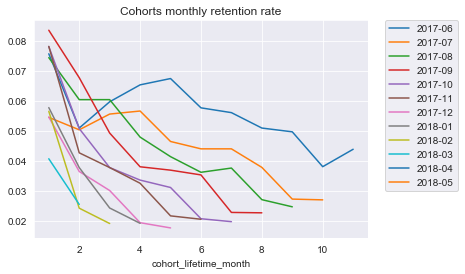

In [151]:
retention_matrix_monthly.unstack(0).unstack()[1:].plot()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.title('Cohorts monthly retention rate')

#### We can see, that 'old' cohorts show higher results

#### Last months we can notice decrease as in the amount of visitors, also in the cohorts activity
#### Oct and Nov 2017 were slightly better than other months
#### Recent months reduction on all cohorts

#### retention weekly

In [152]:
visits.pivot_table(index = 'first_visit_week'
                  ,columns = 'cohort_lifetime_week'
                   ,values = 'uid'
                   ,aggfunc = 'nunique'
                  )

cohort_lifetime_week      0      1      2      3      4      5      6      7   \
first_visit_week                                                                
2017-05-29            1816.0  166.0   89.0   62.0   80.0   72.0   68.0   64.0   
2017-06-05            3534.0  129.0   94.0   80.0   78.0   78.0   76.0   62.0   
2017-06-12            2296.0   89.0   61.0   49.0   52.0   41.0   36.0   37.0   
2017-06-19            2320.0   77.0   61.0   54.0   54.0   32.0   30.0   17.0   
2017-06-26            2430.0   93.0   63.0   46.0   35.0   26.0   27.0   23.0   
2017-07-03            2596.0  114.0   78.0   56.0   37.0   36.0   34.0   26.0   
2017-07-10            3447.0  132.0   60.0   46.0   37.0   41.0   41.0   39.0   
2017-07-17            2987.0   93.0   66.0   44.0   49.0   40.0   42.0   48.0   
2017-07-24            1969.0   47.0   34.0   39.0   28.0   34.0   39.0   30.0   
2017-07-31            1736.0   60.0   27.0   34.0   30.0   40.0   26.0   28.0   
2017-08-07            1807.0   57.0   39.0   32.0   35.0   29.0   27.0   33.0   
2017-08-14            1994.0   67.0   38.0   48.0   29.0   38.0   36.0   27.0   
2017-08-21            2316.0   82.0   74.0   46.0   37.0   54.0   43.0   39.0   
2017-08-28            2745.0  103.0   69.0   54.0   54.0   43.0   48.0   35.0   
2017-09-04            3183.0  119.0   63.0   89.0   66.0   59.0   60.0   51.0   
2017-09-11            3184.0  123.0   89.0   98.0   74.0   72.0   51.0   56.0   
2017-09-18            3618.0  155.0  103.0   84.0   75.0   67.0   62.0   68.0   
2017-09-25            4641.0  179.0  144.0  104.0   88.0   81.0   80.0   72.0   
2017-10-02            5793.0  236.0  175.0  148.0  104.0   90.0  103.0  118.0   
2017-10-09            5142.0  226.0  143.0  131.0  117.0  105.0  118.0   89.0   
2017-10-16            5081.0  220.0  151.0  103.0   94.0  118.0   89.0   72.0   
2017-10-23            5283.0  226.0  163.0   92.0  134.0  109.0   69.0   81.0   
2017-10-30            5269.0  207.0  149.0  159.0   87.0  103.0   81.0   73.0   
2017-11-06            4933.0  210.0  198.0  125.0  123.0   91.0   57.0   67.0   
2017-11-13            5680.0  307.0  159.0  136.0  116.0   78.0   80.0   69.0   
2017-11-20            7357.0  369.0  242.0  234.0  104.0  113.0   97.0  118.0   
2017-11-27            5354.0  321.0  180.0  120.0  101.0   63.0   74.0   76.0   
2017-12-04            5523.0  279.0  131.0  102.0   66.0   70.0   62.0   62.0   
2017-12-11            5305.0  191.0  120.0   78.0   93.0   74.0   70.0   75.0   
2017-12-18            4848.0  191.0  109.0   64.0   71.0   61.0   51.0   61.0   
2017-12-25            5282.0  139.0   95.0   79.0   68.0   55.0   56.0   70.0   
2018-01-01            4814.0  138.0   68.0   62.0   56.0   60.0   36.0   38.0   
2018-01-08            4320.0  176.0   87.0   84.0   85.0   69.0   54.0   62.0   
2018-01-15            4564.0  157.0  122.0   77.0   59.0   79.0   57.0   51.0   
2018-01-22            4607.0  196.0  105.0   78.0   71.0   57.0   52.0   38.0   
2018-01-29            5362.0  245.0  135.0   93.0   92.0   71.0   47.0   59.0   
2018-02-05            5148.0  194.0   86.0   80.0   62.0   51.0   59.0   34.0   
2018-02-12            4978.0  193.0  125.0   70.0   71.0   81.0   58.0   34.0   
2018-02-19            4832.0  158.0   94.0   67.0   66.0   42.0   36.0   40.0   
2018-02-26            4624.0  153.0   82.0   84.0   61.0   44.0   42.0   35.0   
2018-03-05            4381.0  171.0  103.0   55.0   43.0   53.0   46.0   41.0   
2018-03-12            3874.0  151.0   63.0   56.0   46.0   37.0   35.0   28.0   
2018-03-19            5008.0  165.0   84.0   60.0   60.0   44.0   34.0   28.0   
2018-03-26            3027.0   71.0   43.0   33.0   38.0   19.0   30.0   17.0   
2018-04-02            3442.0  112.0   66.0   48.0   36.0   26.0   31.0   28.0   
2018-04-09            3432.0  113.0   57.0   40.0   33.0   29.0   44.0   19.0   
2018-04-16            3614.0  103.0   52.0   59.0   49.0   39.0   28.0    NaN   
2018-04-23            3440.0  1

In [153]:
cohort_pivot_weekly = visits.pivot_table(index = 'first_visit_week'
                  ,columns = 'cohort_lifetime_week'
                   ,values = 'uid'
                   ,aggfunc = 'nunique'
                  )

In [154]:
cohort_pivot_weekly.iloc[:,0]

first_visit_week
2017-05-29    1816.0
2017-06-05    3534.0
2017-06-12    2296.0
2017-06-19    2320.0
2017-06-26    2430.0
2017-07-03    2596.0
2017-07-10    3447.0
2017-07-17    2987.0
2017-07-24    1969.0
2017-07-31    1736.0
2017-08-07    1807.0
2017-08-14    1994.0
2017-08-21    2316.0
2017-08-28    2745.0
2017-09-04    3183.0
2017-09-11    3184.0
2017-09-18    3618.0
2017-09-25    4641.0
2017-10-02    5793.0
2017-10-09    5142.0
2017-10-16    5081.0
2017-10-23    5283.0
2017-10-30    5269.0
2017-11-06    4933.0
2017-11-13    5680.0
2017-11-20    7357.0
2017-11-27    5354.0
2017-12-04    5523.0
2017-12-11    5305.0
2017-12-18    4848.0
2017-12-25    5282.0
2018-01-01    4814.0
2018-01-08    4320.0
2018-01-15    4564.0
2018-01-22    4607.0
2018-01-29    5362.0
2018-02-05    5148.0
2018-02-12    4978.0
2018-02-19    4832.0
2018-02-26    4624.0
2018-03-05    4381.0
2018-03-12    3874.0
2018-03-19    5008.0
2018-03-26    3027.0
2018-04-02    3442.0
2018-04-09    3432.0
2018-04-16    361

In [155]:
cohort_size_weekly = cohort_pivot_weekly.iloc[:,0]

Text(0.5, 1.0, 'Weekly cohort size')

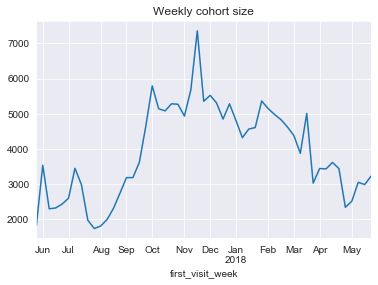

In [156]:
cohort_size_weekly.plot()
plt.title('Weekly cohort size')

Text(0.5, 1.0, 'Weekly unique and cohort users')

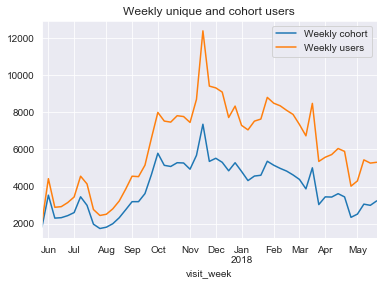

In [157]:
cohort_size_weekly.plot(label= 'Weekly cohort')
visits.groupby('visit_week')['uid'].count().plot(label ='Weekly users')

plt.legend()

plt.title('Weekly unique and cohort users')

In [158]:
cohort_size_weekly / visits.groupby('visit_week')['uid'].count()

first_visit_week
2017-05-29    0.876871
2017-06-05    0.799005
2017-06-12    0.797222
2017-06-19    0.795883
2017-06-26    0.775367
2017-07-03    0.755530
2017-07-10    0.756419
2017-07-17    0.721672
2017-07-24    0.713406
2017-07-31    0.711767
2017-08-07    0.721357
2017-08-14    0.713417
2017-08-21    0.719702
2017-08-28    0.711878
2017-09-04    0.698639
2017-09-11    0.702405
2017-09-18    0.702524
2017-09-25    0.703075
2017-10-02    0.724669
2017-10-09    0.683050
2017-10-16    0.680096
2017-10-23    0.675921
2017-10-30    0.677946
2017-11-06    0.661792
2017-11-13    0.652949
2017-11-20    0.593689
2017-11-27    0.568727
2017-12-04    0.592787
2017-12-11    0.583544
2017-12-18    0.627979
2017-12-25    0.633713
2018-01-01    0.659723
2018-01-08    0.612418
2018-01-15    0.606512
2018-01-22    0.603326
2018-01-29    0.608972
2018-02-05    0.606289
2018-02-12    0.596025
2018-02-19    0.596028
2018-02-26    0.586356
2018-03-05    0.596948
2018-03-12    0.575460
2018-03-19    0.5

In [159]:
(
cohort_size_weekly / visits.groupby('visit_week')['uid'].count()
).mean()

0.6573029880070654

Text(0.5, 1.0, 'Generation of new cohorts as ratio of new users to the total visitors by week')

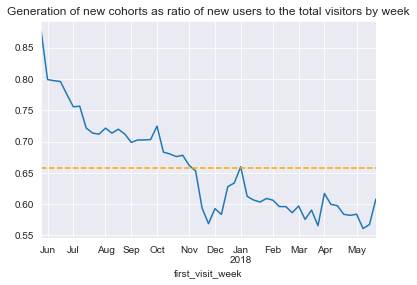

In [160]:
(cohort_size_weekly / visits.groupby('visit_week')['uid'].count()).plot()

plt.axhline(
(
cohort_size_weekly / visits.groupby('visit_week')['uid'].count()
).mean()
    ,color = 'orange'
           , linestyle='--'
)

plt.title("Generation of new cohorts as ratio of new users to the total visitors by week")

Text(0.5, 1.0, 'Cohort generation')

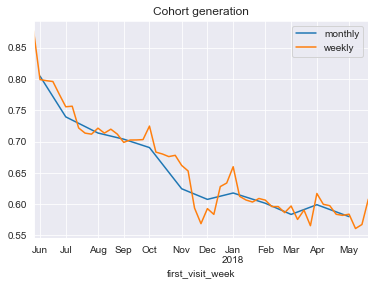

In [161]:
(cohort_size_monthly / visits.groupby('visit_month')['uid'].count()).plot(label='monthly')
#plt.margins(x=0)
(cohort_size_weekly / visits.groupby('visit_week')['uid'].count()).plot(label='weekly')
#plt.margins(x=0)
#plt.axis('tight')
plt.legend()

plt.title('Cohort generation')

#### Interestin moment, that the "minimum" corridor is between 0.55-0.6 and from November 2017 it remains the same

Text(0.5, 1.0, 'General observation')

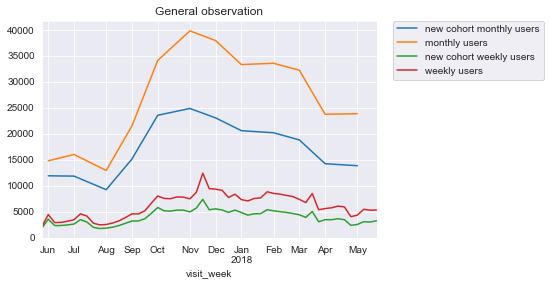

In [162]:

cohort_size_monthly.plot(label='new cohort monthly users')
visits.groupby('visit_month')['uid'].count().plot(label='monthly users')

cohort_size_weekly.plot(label='new cohort weekly users')
visits.groupby('visit_week')['uid'].count().plot(label='weekly users')
#plt.legend()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.title('General observation')

#### visits churn rate

In [163]:
visits.pivot_table(index = 'first_visit_month'
                  ,columns = 'cohort_lifetime_month'
                   ,values = 'uid'
                   ,aggfunc = 'nunique'
                  ).pct_change(fill_method=None,axis=1)

cohort_lifetime_month  0         1         2         3         4         5   \
first_visit_month                                                             
2017-06-01            NaN -0.924274 -0.326667  0.171617  0.094366  0.032175   
2017-07-01            NaN -0.945455 -0.075969  0.104027  0.018237 -0.179104   
2017-08-01            NaN -0.925548 -0.188047  0.000000 -0.206463 -0.135747   
2017-09-01            NaN -0.916430 -0.189082 -0.272195 -0.227882 -0.029514   
2017-10-01            NaN -0.921871 -0.349647 -0.255853 -0.110112 -0.073232   
2017-11-01            NaN -0.921817 -0.453423 -0.114878 -0.138298 -0.333333   
2017-12-01            NaN -0.945332 -0.332010 -0.173603 -0.355396 -0.089286   
2018-01-01            NaN -0.942206 -0.345669 -0.356041 -0.209581       NaN   
2018-02-01            NaN -0.943439 -0.570552 -0.210204       NaN       NaN   
2018-03-01            NaN -0.959240 -0.373368       NaN       NaN       NaN   
2018-04-01            NaN -0.952515       NaN       NaN       NaN       NaN   
2018-05-01            NaN       NaN       NaN       NaN       NaN       NaN   

cohort_lifetime_month        6         7         8         9         10  \
first_visit_month                                                         
2017-06-01            -0.144638 -0.027697 -0.091454 -0.024752 -0.233503   
2017-07-01            -0.052727  0.000000 -0.140115 -0.279018 -0.009288   
2017-08-01            -0.125654  0.038922 -0.279539 -0.088000       NaN   
2017-09-01            -0.042934 -0.353271 -0.005780       NaN       NaN   
2017-10-01            -0.333787 -0.047035       NaN       NaN       NaN   
2017-11-01            -0.051852       NaN       NaN       NaN       NaN   
2017-12-01                  NaN       NaN       NaN       NaN       NaN   
2018-01-01                  NaN       NaN       NaN       NaN       NaN   
2018-02-01                  NaN       NaN       NaN       NaN       NaN   
2018-03-01                  NaN       NaN       NaN       NaN       NaN   
2018-04-01                  NaN       NaN       NaN       NaN       NaN   
2018-05-01                  NaN       NaN       NaN       NaN       NaN   

cohort_lifetime_month        11  
first_visit_month                
2017-06-01             0.152318  
2017-07-01                  NaN  
2017-08-01                  NaN  
2017-09-01                  NaN  
2017-10-01                  NaN  
2017-11-01                  NaN  
2017-12-01                  NaN  
2018-01-01                  NaN  
2018-02-01                  NaN  
2018-03-01                  NaN  
2018-04-01                  NaN  
2018-05-01                  NaN

In [164]:
churn_matrix_monthly = visits.pivot_table(index = 'first_visit_month'
                  ,columns = 'cohort_lifetime_month'
                   ,values = 'uid'
                   ,aggfunc = 'nunique'
                  ).pct_change(fill_method=None,axis=1)

In [165]:
churn_matrix_monthly.index

DatetimeIndex(['2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01'],
              dtype='datetime64[ns]', name='first_visit_month', freq=None)

In [166]:
churn_matrix_monthly.index = churn_matrix_monthly.index.strftime("%Y-%m")

In [167]:
cohort_size_monthly_df

cohort_size
first_visit_month             
2017-06                11885.0
2017-07                11825.0
2017-08                 9214.0
2017-09                15125.0
2017-10                23538.0
2017-11                24852.0
2017-12                23030.0
2018-01                20573.0
2018-02                20173.0
2018-03                18793.0
2018-04                14215.0
2018-05                13828.0

In [168]:
cohort_size_monthly_df.index

Index(['2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11',
       '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05'],
      dtype='object', name='first_visit_month')

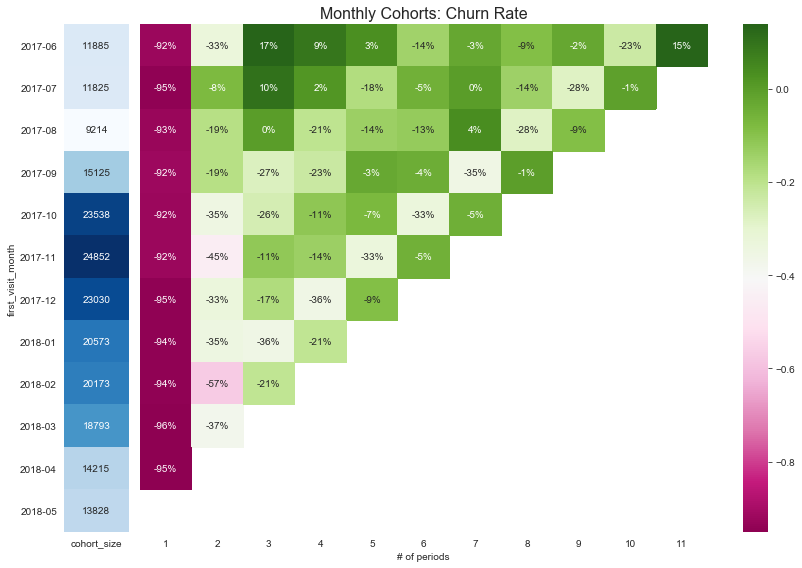

In [169]:
with sns.axes_style("white"):    
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(churn_matrix_monthly.iloc[:,1:], 
                #mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='PiYG',
                robust=True,
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: Churn Rate', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')


    # cohort size
    
    sns.heatmap(cohort_size_monthly_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap='Blues', 
                robust=True,
                ax=ax[0])

    fig.tight_layout()

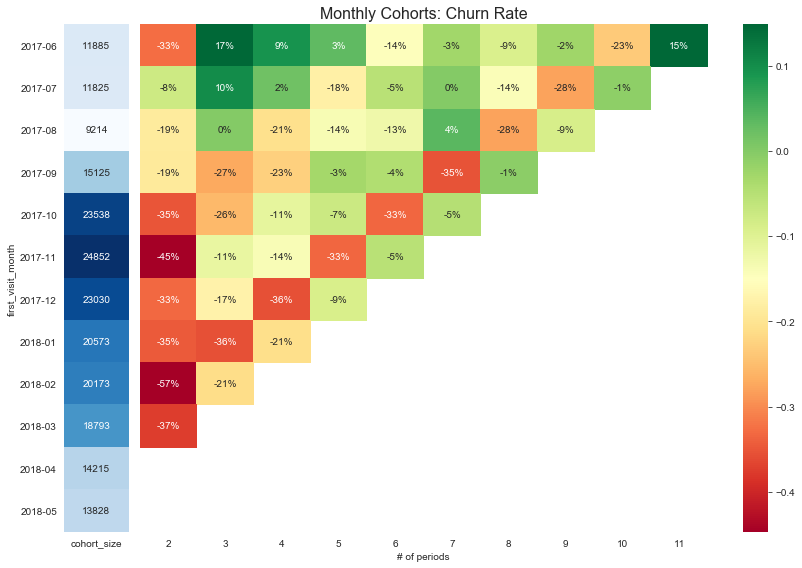

In [170]:
with sns.axes_style("white"):    
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(churn_matrix_monthly.iloc[:,2:], 
                #mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn',
                robust=True,
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: Churn Rate', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')


    # cohort size
    
    sns.heatmap(cohort_size_monthly_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap='Blues', 
                robust=True,
                ax=ax[0])

    fig.tight_layout()

#### we can notice:
#### 1) we have constant reduce of users on the second month from Oct 2017 about 30% and more
#### 2) also something negative happend - we can see it on the diagonal, let's check it


In [171]:
visits.pivot_table(index = 'first_visit_month'
                  ,columns = 'visit_month'
                   ,values = 'uid'
                   ,aggfunc = 'nunique'
                  ).pct_change(fill_method=None,axis=1)

visit_month        2017-06-01  2017-07-01  2017-08-01  2017-09-01  2017-10-01  \
first_visit_month                                                               
2017-06-01                NaN   -0.924274   -0.326667    0.171617    0.094366   
2017-07-01                NaN         NaN   -0.945455   -0.075969    0.104027   
2017-08-01                NaN         NaN         NaN   -0.925548   -0.188047   
2017-09-01                NaN         NaN         NaN         NaN   -0.916430   
2017-10-01                NaN         NaN         NaN         NaN         NaN   
2017-11-01                NaN         NaN         NaN         NaN         NaN   
2017-12-01                NaN         NaN         NaN         NaN         NaN   
2018-01-01                NaN         NaN         NaN         NaN         NaN   
2018-02-01                NaN         NaN         NaN         NaN         NaN   
2018-03-01                NaN         NaN         NaN         NaN         NaN   
2018-04-01                NaN         NaN         NaN         NaN         NaN   
2018-05-01                NaN         NaN         NaN         NaN         NaN   

visit_month        2017-11-01  2017-12-01  2018-01-01  2018-02-01  2018-03-01  \
first_visit_month                                                               
2017-06-01           0.032175   -0.144638   -0.027697   -0.091454   -0.024752   
2017-07-01           0.018237   -0.179104   -0.052727    0.000000   -0.140115   
2017-08-01           0.000000   -0.206463   -0.135747   -0.125654    0.038922   
2017-09-01          -0.189082   -0.272195   -0.227882   -0.029514   -0.042934   
2017-10-01          -0.921871   -0.349647   -0.255853   -0.110112   -0.073232   
2017-11-01                NaN   -0.921817   -0.453423   -0.114878   -0.138298   
2017-12-01                NaN         NaN   -0.945332   -0.332010   -0.173603   
2018-01-01                NaN         NaN         NaN   -0.942206   -0.345669   
2018-02-01                NaN         NaN         NaN         NaN   -0.943439   
2018-03-01                NaN         NaN         NaN         NaN         NaN   
2018-04-01                NaN         NaN         NaN         NaN         NaN   
2018-05-01                NaN         NaN         NaN         NaN         NaN   

visit_month        2018-04-01  2018-05-01  
first_visit_month                          
2017-06-01          -0.233503    0.152318  
2017-07-01          -0.279018   -0.009288  
2017-08-01          -0.279539   -0.088000  
2017-09-01          -0.353271   -0.005780  
2017-10-01          -0.333787   -0.047035  
2017-11-01          -0.333333   -0.051852  
2017-12-01          -0.355396   -0.089286  
2018-01-01          -0.356041   -0.209581  
2018-02-01          -0.570552   -0.210204  
2018-03-01          -0.959240   -0.373368  
2018-04-01                NaN   -0.952515  
2018-05-01                NaN         NaN

In [172]:
vchurn = visits.pivot_table(index = 'first_visit_month'
                  ,columns = 'visit_month'
                   ,values = 'uid'
                   ,aggfunc = 'nunique'
                  ).pct_change(fill_method=None,axis=1)

In [173]:
vchurn.index = vchurn.index.strftime("%Y-%m")

In [174]:
vchurn.columns = vchurn.columns.strftime("%Y-%m")

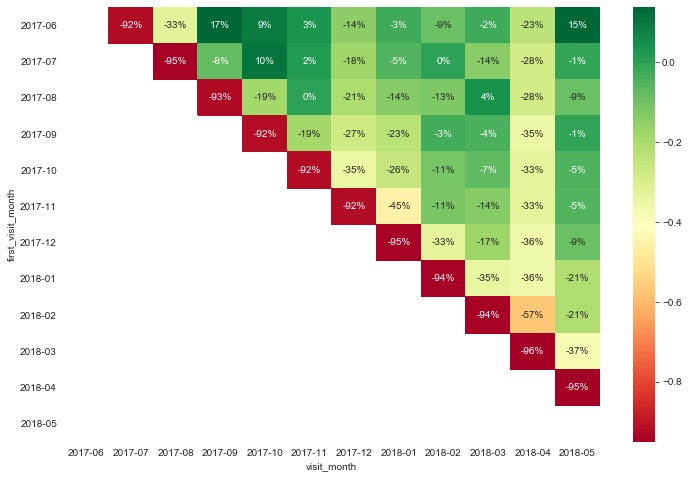

In [175]:

with sns.axes_style("white"):
    plt.figure(figsize=(12, 8))
    sns.heatmap(vchurn,
                
               annot=True, 
                fmt='.0%', 
                cmap='RdYlGn',
                robust=True
               )


#### Yes, on another representation of the montly churn we can see, that something happened on 2018-04: bug fall for all cohorts
####  on Apr 2018 we have decrease 20-50 % on all cohorts.

In [176]:
vchurn_week = visits.pivot_table(index = 'first_visit_week'
                  ,columns = 'visit_week'
                   ,values = 'uid'
                   ,aggfunc = 'nunique'
                  ).pct_change(fill_method=None,axis=1)

In [177]:
vchurn_week.columns

DatetimeIndex(['2017-05-29', '2017-06-05', '2017-06-12', '2017-06-19',
               '2017-06-26', '2017-07-03', '2017-07-10', '2017-07-17',
               '2017-07-24', '2017-07-31', '2017-08-07', '2017-08-14',
               '2017-08-21', '2017-08-28', '2017-09-04', '2017-09-11',
               '2017-09-18', '2017-09-25', '2017-10-02', '2017-10-09',
               '2017-10-16', '2017-10-23', '2017-10-30', '2017-11-06',
               '2017-11-13', '2017-11-20', '2017-11-27', '2017-12-04',
               '2017-12-11', '2017-12-18', '2017-12-25', '2018-01-01',
               '2018-01-08', '2018-01-15', '2018-01-22', '2018-01-29',
               '2018-02-05', '2018-02-12', '2018-02-19', '2018-02-26',
               '2018-03-05', '2018-03-12', '2018-03-19', '2018-03-26',
               '2018-04-02', '2018-04-09', '2018-04-16', '2018-04-23',
               '2018-04-30', '2018-05-07', '2018-05-14', '2018-05-21',
               '2018-05-28'],
              dtype='datetime64[ns]', name='vis

In [178]:
vchurn_week.loc[:, 
                '2018-03-05':'2018-05-28']

visit_week        2018-03-05  2018-03-12  2018-03-19  2018-03-26  2018-04-02  \
first_visit_week                                                               
2017-05-29         -0.200000   -0.076923    0.291667   -0.177419   -0.294118   
2017-06-05         -0.145161    0.056604    0.053571   -0.169492    0.102041   
2017-06-12         -0.232558   -0.121212    0.758621   -0.313725   -0.114286   
2017-06-19         -0.185185    0.363636    0.033333   -0.419355    0.666667   
2017-06-26          0.034483   -0.166667    0.280000   -0.468750    0.294118   
2017-07-03         -0.040000    0.041667    0.120000   -0.107143   -0.280000   
2017-07-10         -0.400000   -0.066667    0.500000   -0.333333   -0.250000   
2017-07-17         -0.152174   -0.076923    0.416667   -0.568627    0.363636   
2017-07-24         -0.117647    0.266667    0.105263   -0.333333   -0.357143   
2017-07-31         -0.310345   -0.350000    1.230769   -0.586207    1.000000   
2017-08-07          0.266667   -0.210526    0.800000   -0.333333   -0.444444   
2017-08-14         -0.043478   -0.545455    0.900000   -0.157895   -0.250000   
2017-08-21         -0.120000   -0.045455    0.333333   -0.428571    0.312500   
2017-08-28          0.096774   -0.205882    0.222222   -0.181818   -0.555556   
2017-09-04         -0.386364    0.000000    0.518519   -0.243902   -0.322581   
2017-09-11          0.107143    0.129032    0.114286   -0.358974   -0.120000   
2017-09-18         -0.052632   -0.138889    0.161290   -0.638889    0.307692   
2017-09-25         -0.297872    0.272727   -0.023810   -0.341463   -0.037037   
2017-10-02         -0.180328    0.000000   -0.080000   -0.478261   -0.041667   
2017-10-09          0.166667   -0.339286    0.378378   -0.490196    0.461538   
2017-10-16         -0.338983   -0.256410    0.655172   -0.333333   -0.125000   
2017-10-23         -0.038462   -0.120000    0.045455   -0.282609   -0.212121   
2017-10-30         -0.054054   -0.028571    0.529412   -0.519231    0.600000   
2017-11-06         -0.066667   -0.261905    0.387097   -0.255814   -0.468750   
2017-11-13          0.022222   -0.086957    0.404762   -0.559322   -0.076923   
2017-11-20         -0.174419    0.028169    0.232877   -0.322222   -0.114754   
2017-11-27         -0.163636   -0.021739    0.266667   -0.385965   -0.028571   
2017-12-04         -0.057692   -0.061224   -0.065217   -0.186047   -0.200000   
2017-12-11         -0.127660   -0.048780    0.333333   -0.326923    0.057143   
2017-12-18         -0.295455    0.290323   -0.100000   -0.444444    0.450000   
2017-12-25         -0.089286   -0.470588    0.777778   -0.541667   -0.181818   
2018-01-01          0.048780   -0.279070    0.129032   -0.485714    0.111111   
2018-01-08         -0.177419    0.117647   -0.192982   -0.391304    0.250000   
2018-01-15         -0.105263    0.000000   -0.098039   -0.195652   -0.297297   
2018-01-22         -0.087719   -0.269231    0.526316   -0.344828   -0.105263   
2018-01-29         -0.228261   -0.338028    0.255319   -0.288136    0.023810   
2018-02-05         -0.225000   -0.177419    0.156863   -0.423729    0.029412   
2018-02-12         -0.440000    0.014286    0.140845   -0.283951   -0.413793   
2018-02-19         -0.405063   -0.287234   -0.014925   -0.363636   -0.142857   
2018-02-26         -0.966912   -0.464052    0.024390   -0.273810   -0.278689   
2018-03-05               NaN   -0.960968   -0.397661   -0.466019   -0.218182   
2018-03-12               NaN         NaN   -0.961022   -0.582781   -0.111111   
2018-03-19               NaN         NaN         NaN   -0.967053   -0.490909   
2018-03-26               NaN         NaN         NaN         NaN   -0.976544   
2018-04-02               NaN         NaN         NaN         NaN         NaN   
2018-04-09               NaN         NaN         NaN         NaN         NaN   
2018-04-16               NaN         NaN         NaN         NaN         NaN   
2018-04-23               NaN         NaN         NaN         NaN         NaN   


In [179]:
vchurn_week.index.strftime("%Y-%m-%d")

Index(['2017-05-29', '2017-06-05', '2017-06-12', '2017-06-19', '2017-06-26',
       '2017-07-03', '2017-07-10', '2017-07-17', '2017-07-24', '2017-07-31',
       '2017-08-07', '2017-08-14', '2017-08-21', '2017-08-28', '2017-09-04',
       '2017-09-11', '2017-09-18', '2017-09-25', '2017-10-02', '2017-10-09',
       '2017-10-16', '2017-10-23', '2017-10-30', '2017-11-06', '2017-11-13',
       '2017-11-20', '2017-11-27', '2017-12-04', '2017-12-11', '2017-12-18',
       '2017-12-25', '2018-01-01', '2018-01-08', '2018-01-15', '2018-01-22',
       '2018-01-29', '2018-02-05', '2018-02-12', '2018-02-19', '2018-02-26',
       '2018-03-05', '2018-03-12', '2018-03-19', '2018-03-26', '2018-04-02',
       '2018-04-09', '2018-04-16', '2018-04-23', '2018-04-30', '2018-05-07',
       '2018-05-14', '2018-05-21', '2018-05-28'],
      dtype='object', name='first_visit_week')

In [180]:
vchurn_week.index = vchurn_week.index.strftime("%Y-%m-%d")

In [181]:
vchurn_week.columns = vchurn_week.columns.strftime("%Y-%m-%d")

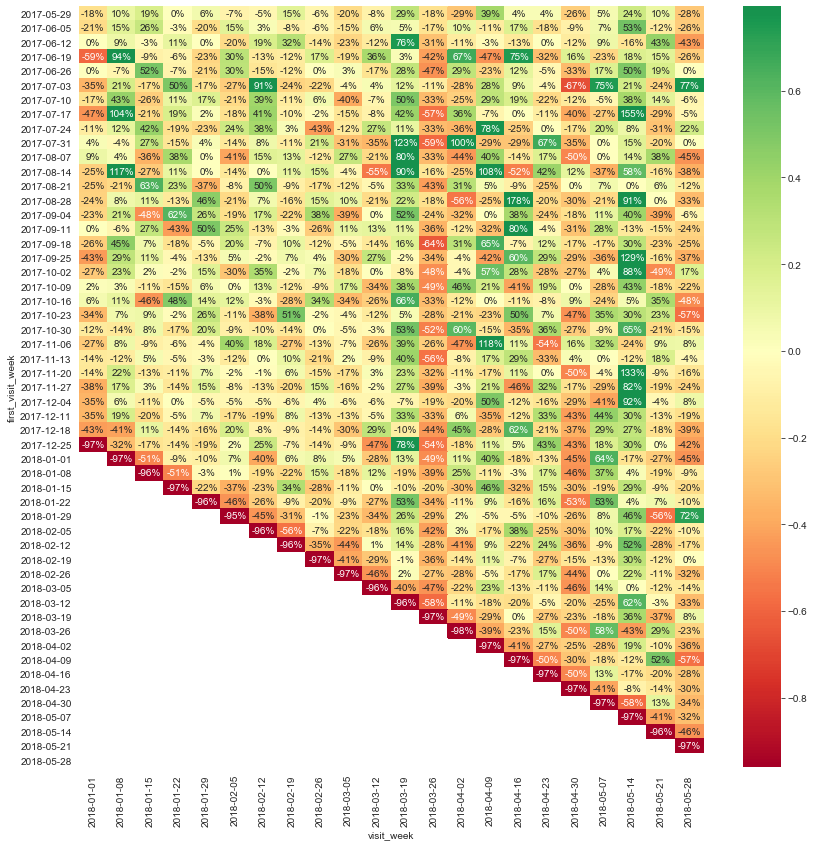

In [182]:
with sns.axes_style("white"):
    plt.figure(figsize=(14, 14))
    sns.heatmap(vchurn_week.loc[:,
                                '2018-01-01':'2018-05-28'],

                annot=True,
                fmt='.0%',
                cmap='RdYlGn',
                robust=True                # ,square=True
                , center=0
                )

#### with higher granularity we can definately see that the negative gap was on the week 2018-03-26 that is close to April and the gap occured for all the cohorts. So I'd like to point it out for the management for providing investigations.

## Sales

### How many orders do they make during a given period of time?
### What is the average purchase size?


In [183]:
orders.head()

buy_ts  revenue                   uid
0 2017-06-01 00:10:00    17.00  10329302124590727494
1 2017-06-01 00:25:00     0.55  11627257723692907447
2 2017-06-01 00:27:00     0.37  17903680561304213844
3 2017-06-01 00:29:00     0.55  16109239769442553005
4 2017-06-01 07:58:00     0.37  14200605875248379450

In [184]:
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

In [185]:
orders[orders['revenue']==0]

buy_ts  revenue                   uid
1802  2017-06-22 18:19:00      0.0  17030528792926543083
2787  2017-07-07 15:54:00      0.0  10281425020415612933
4783  2017-08-02 14:54:00      0.0    184148767273119549
5095  2017-08-09 14:48:00      0.0   5603453646174104178
5863  2017-08-23 13:43:00      0.0   5603453646174104178
6393  2017-08-30 16:30:00      0.0   5603453646174104178
6995  2017-09-06 13:57:00      0.0   5603453646174104178
7104  2017-09-07 14:37:00      0.0   5603453646174104178
7488  2017-09-11 16:53:00      0.0  10169885790465067808
8160  2017-09-18 16:49:00      0.0   2883839899480223178
14664 2017-10-26 11:39:00      0.0   5603453646174104178
14736 2017-10-26 17:31:00      0.0   2883839899480223178
20471 2017-11-27 15:13:00      0.0   8277558335454815700
20488 2017-11-27 16:03:00      0.0   8277558335454815700
20634 2017-11-28 12:43:00      0.0  13594493436687104785
20720 2017-11-28 16:01:00      0.0   8277558335454815700
20783 2017-11-28 19:42:00      0.0   2037345392173160982
20807 2017-11-28 20:58:00      0.0   2636645662067512510
20809 2017-11-28 21:13:00      0.0   8277558335454815700
20964 2017-11-29 17:20:00      0.0   8277558335454815700
20974 2017-11-29 17:55:00      0.0   8277558335454815700
21158 2017-11-30 17:26:00      0.0   2037345392173160982
21180 2017-11-30 18:30:00      0.0   2037345392173160982
21201 2017-11-30 20:05:00      0.0   2037345392173160982
21203 2017-11-30 20:24:00      0.0   9971607959588724150
21220 2017-11-30 21:34:00      0.0   2037345392173160982
21222 2017-11-30 21:49:00      0.0   2037345392173160982
21351 2017-12-01 14:59:00      0.0   2037345392173160982
21386 2017-12-01 16:37:00      0.0   2037345392173160982
21388 2017-12-01 16:44:00      0.0  12296506984642158789
21404 2017-12-01 17:53:00      0.0  15254206642996645755
21407 2017-12-01 18:05:00      0.0   2936104404423239931
21418 2017-12-01 19:10:00      0.0   2037345392173160982
21583 2017-12-02 21:36:00      0.0   2037345392173160982
21586 2017-12-02 21:42:00      0.0   2037345392173160982
21599 2017-12-02 23:58:00      0.0   2037345392173160982
21938 2017-12-04 22:08:00      0.0   6538135401269860305
22014 2017-12-05 11:22:00      0.0   1879819502567241225
23894 2017-12-13 19:36:00      0.0   1149062814762747892
32432 2018-02-01 15:57:00      0.0   5342067285161169772
41060 2018-03-22 04:52:00      0.0  13486014841579728464
44844 2018-04-20 17:33:00      0.0   5570343171257035973
44931 2018-04-21 13:02:00      0.0   4927261749585088199
44957 2018-04-21 16:13:00      0.0   4927261749585088199
44993 2018-04-21 20:14:00      0.0   4927261749585088199
45000 2018-04-21 21:42:00      0.0   4927261749585088199
45050 2018-04-22 13:54:00      0.0   5570343171257035973
45068 2018-04-22 16:16:00      0.0   5570343171257035973
45084 2018-04-22 18:38:00      0.0   5570343171257035973
49040 2018-05-26 12:12:00      0.0  14872085179275033073
49234 2018-05-28 08:55:00      0.0  14973814017160376581

#### I"ll set apart orders with 0 revenue and consider them as mistaken

In [186]:
mistaken_orders = orders[orders['revenue']==0]

In [187]:
orders[orders['revenue']!=0]

buy_ts  revenue                   uid
0     2017-06-01 00:10:00    17.00  10329302124590727494
1     2017-06-01 00:25:00     0.55  11627257723692907447
2     2017-06-01 00:27:00     0.37  17903680561304213844
3     2017-06-01 00:29:00     0.55  16109239769442553005
4     2017-06-01 07:58:00     0.37  14200605875248379450
...                   ...      ...                   ...
50410 2018-05-31 23:50:00     4.64  12296626599487328624
50411 2018-05-31 23:50:00     5.80  11369640365507475976
50412 2018-05-31 23:54:00     0.30   1786462140797698849
50413 2018-05-31 23:56:00     3.67   3993697860786194247
50414 2018-06-01 00:02:00     3.42     83872787173869366

[50364 rows x 3 columns]

In [188]:
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

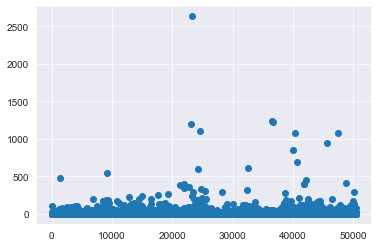

In [189]:
plt.scatter(orders.index,orders['revenue'])

In [190]:
np.percentile(orders['revenue'],[90,95,99])

array([ 9.17, 13.75, 36.67])

In [191]:
np.percentile(orders['revenue'],[25,50,75])

array([1.22, 2.5 , 4.89])

In [192]:
orders[orders['revenue']>=14].head()

buy_ts  revenue                   uid
0   2017-06-01 00:10:00    17.00  10329302124590727494
42  2017-06-01 17:27:00   110.00  11218073356336199381
91  2017-06-01 22:49:00    18.33   1448747731515840830
105 2017-06-02 09:24:00    14.67   4428482928085636621
137 2017-06-02 12:40:00    22.00  17648921517901779207

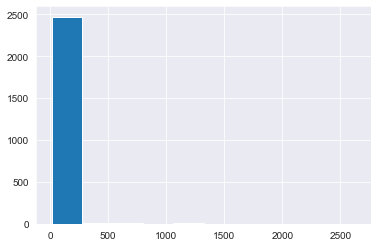

In [193]:
orders[orders['revenue']>=14]['revenue'].hist()

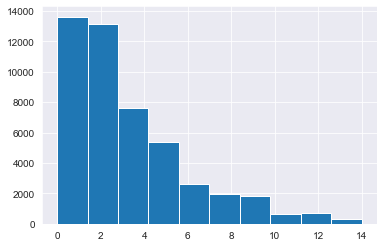

In [194]:
orders[orders['revenue']<14]['revenue'].hist()

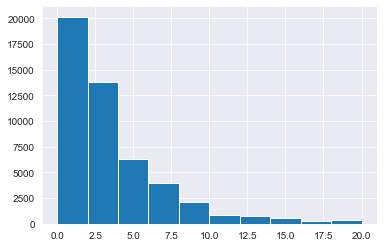

In [195]:
orders[orders['revenue']<=20]['revenue'].hist()

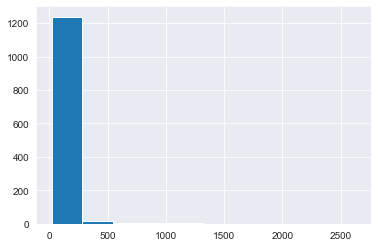

In [196]:
orders[orders['revenue']>20]['revenue'].hist()

In [197]:
usual_orders = orders[orders['revenue']<=14]

In [198]:
expensive_orders = orders[orders['revenue']>14]

In [199]:
usual_orders['revenue'].describe()

count    47927.000000
mean         3.297944
std          2.785788
min          0.000000
25%          1.220000
50%          2.440000
75%          4.475000
max         14.000000
Name: revenue, dtype: float64

In [200]:
expensive_orders['revenue'].describe()

count    2488.0000
mean       37.7800
std        91.4849
min        14.0200
25%        16.7400
50%        20.1700
75%        31.1700
max      2633.2800
Name: revenue, dtype: float64

In [201]:
np.percentile(expensive_orders['revenue'] ,[90,95,99])

array([ 58.236 ,  96.76  , 294.5783])

C:\Users\Yuri\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


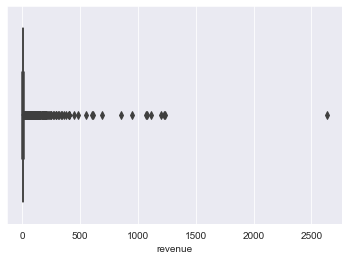

In [202]:
sns.boxplot(orders['revenue'])
plt.show()

C:\Users\Yuri\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


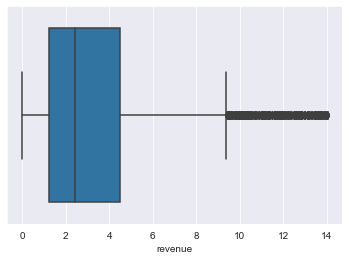

In [203]:
sns.boxplot(usual_orders['revenue'])
plt.show()

C:\Users\Yuri\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


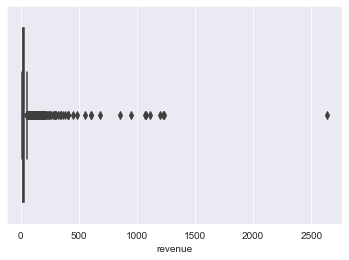

In [204]:
sns.boxplot(expensive_orders['revenue'])
plt.show()

#### I've decided to divide order size on two big gropus: less than 14 and more. We have huge volatility here:
50% of buyers procced with with the order size 2.5
75% with less, than 5
and 95% with less, than 14
From the other side we have maximum order that is more than 2600


In [205]:
orders['order_day'] = orders['buy_ts'].astype('datetime64[D]')

orders['order_week'] = orders['order_day'] - pd.to_timedelta(orders['buy_ts'].dt.dayofweek, unit='d')

orders['order_month'] = orders['order_day'].astype('datetime64[M]')

In [206]:
orders['order_month'].max()

Timestamp('2018-06-01 00:00:00')

In [207]:
orders[orders['order_month'] == '2018-06-01']

buy_ts  revenue                uid  order_day order_week  \
50414 2018-06-01 00:02:00     3.42  83872787173869366 2018-06-01 2018-05-28   

      order_month  
50414  2018-06-01

#### we have only one order on June 2018 so I'd like to ommit this row

In [208]:
orders = orders[orders['order_month'] < '2018-06-01']

In [209]:
orders.groupby('order_day')['revenue'].median().mean()

2.6840771349862305

In [210]:
orders.groupby('order_week')['revenue'].median().mean()

2.675943396226415

In [211]:
orders.groupby('order_month')['revenue'].median()

order_month
2017-06-01    2.44
2017-07-01    3.05
2017-08-01    2.78
2017-09-01    2.44
2017-10-01    2.44
2017-11-01    2.44
2017-12-01    2.69
2018-01-01    2.44
2018-02-01    2.69
2018-03-01    2.44
2018-04-01    2.75
2018-05-01    2.44
Name: revenue, dtype: float64

In [212]:
orders.groupby('order_month')['revenue'].median().mean()

2.586666666666667

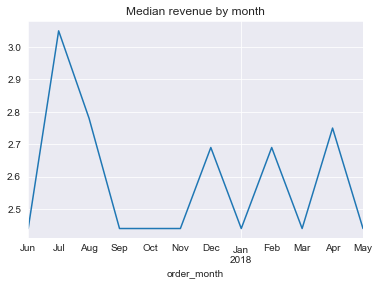

In [213]:
orders.groupby('order_month')['revenue'].median().plot()

plt.title('Median revenue by month')
plt.show()

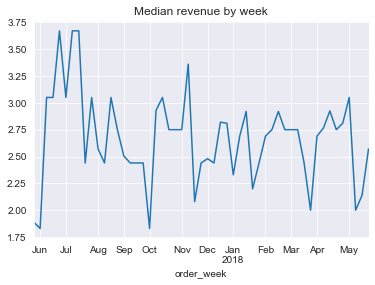

In [214]:
orders.groupby('order_week')['revenue'].median().plot()

plt.title("Median revenue by week")
plt.show()

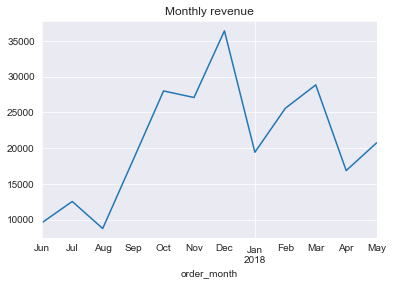

In [215]:
orders.groupby('order_month')['revenue'].sum().plot()

plt.title('Monthly revenue')
plt.show()

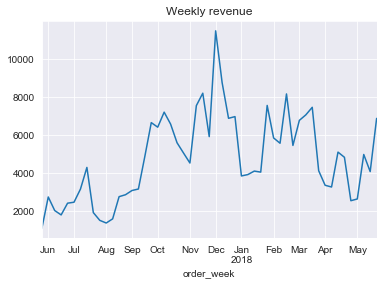

In [216]:
orders.groupby('order_week')['revenue'].sum().plot()

plt.title('Weekly revenue')
plt.show()

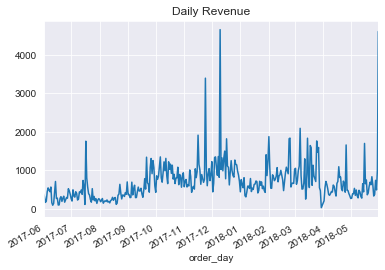

In [217]:
orders.groupby('order_day')['revenue'].sum().plot()
plt.margins(x=0)

plt.title("Daily Revenue")
plt.show()

#### on the last period in spite of decrease in visitors there is a positive tendency in revenue growth. From the other side the median indicator stay on the "corridor", so it could be connected with a few expensive deals.

#### what is also interesting that even on "good" months like Oct,Nov, Dec 2017 the volatility of median revenue is very low, so all the extra profit is could be generated or by "big deals", or by number of orders.

### How many orders do they make during a given period of time?

#### buyers analysis

In [218]:
orders.head()

buy_ts  revenue                   uid  order_day order_week  \
0 2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01 2017-05-29   
1 2017-06-01 00:25:00     0.55  11627257723692907447 2017-06-01 2017-05-29   
2 2017-06-01 00:27:00     0.37  17903680561304213844 2017-06-01 2017-05-29   
3 2017-06-01 00:29:00     0.55  16109239769442553005 2017-06-01 2017-05-29   
4 2017-06-01 07:58:00     0.37  14200605875248379450 2017-06-01 2017-05-29   

  order_month  
0  2017-06-01  
1  2017-06-01  
2  2017-06-01  
3  2017-06-01  
4  2017-06-01

#### users who made purchases more than once

In [219]:
orders.groupby('uid')['buy_ts'].nunique().head()

uid
313578113262317     1
1575281904278712    2
2429014661409475    1
2464366381792757    1
2551852515556206    2
Name: buy_ts, dtype: int64

In [220]:
orders['uid'].nunique()

36522

In [221]:
np.sum(orders.groupby('uid')['buy_ts'].nunique()>1) / orders['uid'].nunique()

0.17227972181151088

In [222]:
(orders.groupby('uid')['buy_ts'].nunique()).describe()

count    36522.000000
mean         1.380373
std          3.454508
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        239.000000
Name: buy_ts, dtype: float64

In [223]:
n_orders = orders.groupby('uid')['buy_ts'].nunique()

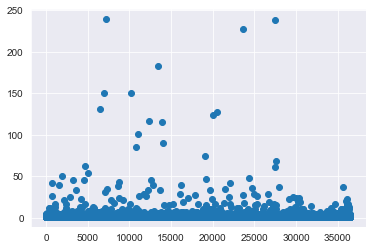

In [224]:
plt.scatter(n_orders.reset_index().index,n_orders.reset_index()['buy_ts'])
plt.show()

In [225]:
np.percentile(n_orders.reset_index()['buy_ts'], [90, 95, 99])

array([2., 3., 5.])

#### about 17% of buyers do the purchasing more than once and only 1% do more than 5

In [226]:
orders = pd.merge(orders
                 , orders.groupby(['uid'])['order_week'].min().rename('first_order_week')
                 , left_on='uid', right_index=True , how='left')

In [227]:
orders = pd.merge(orders
                 , orders.groupby(['uid'])['order_month'].min().rename('first_order_month')
                 , left_on='uid', right_index=True , how='left')

In [228]:
orders['cohort_lifetime_month'] = orders['order_month'] - orders['first_order_month']

orders['cohort_lifetime_month'] = orders['cohort_lifetime_month'] / np.timedelta64(1,'M')

orders['cohort_lifetime_month'] = orders['cohort_lifetime_month'].round().astype(int)


In [229]:
orders['cohort_lifetime_week'] = orders['order_week'] - orders['first_order_week']
orders['cohort_lifetime_week'] = orders['cohort_lifetime_week'] / np.timedelta64(1,'W')
orders['cohort_lifetime_week'] = orders['cohort_lifetime_week'].round().astype(int)

In [230]:
orders.head()

buy_ts  revenue                   uid  order_day order_week  \
0 2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01 2017-05-29   
1 2017-06-01 00:25:00     0.55  11627257723692907447 2017-06-01 2017-05-29   
2 2017-06-01 00:27:00     0.37  17903680561304213844 2017-06-01 2017-05-29   
3 2017-06-01 00:29:00     0.55  16109239769442553005 2017-06-01 2017-05-29   
4 2017-06-01 07:58:00     0.37  14200605875248379450 2017-06-01 2017-05-29   

  order_month first_order_week first_order_month  cohort_lifetime_month  \
0  2017-06-01       2017-05-29        2017-06-01                      0   
1  2017-06-01       2017-05-29        2017-06-01                      0   
2  2017-06-01       2017-05-29        2017-06-01                      0   
3  2017-06-01       2017-05-29        2017-06-01                      0   
4  2017-06-01       2017-05-29        2017-06-01                      0   

   cohort_lifetime_week  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0

In [231]:
orders.pivot_table(index = 'first_order_month',
                                     columns = 'cohort_lifetime_month',
                                     values = 'uid'
                  ,aggfunc='nunique')

cohort_lifetime_month      0      1      2      3     4     5     6     7   \
first_order_month                                                            
2017-06-01             2023.0   61.0   50.0   54.0  88.0  67.0  62.0  47.0   
2017-07-01             1923.0   52.0   57.0   64.0  49.0  38.0  36.0  39.0   
2017-08-01             1370.0   58.0   53.0   44.0  40.0  32.0  30.0  44.0   
2017-09-01             2581.0  130.0  100.0   74.0  52.0  64.0  66.0  37.0   
2017-10-01             4340.0  206.0  123.0   92.0  93.0  72.0  56.0  67.0   
2017-11-01             4081.0  222.0  120.0  106.0  81.0  48.0  62.0   NaN   
2017-12-01             4383.0  146.0  103.0   97.0  50.0  63.0   NaN   NaN   
2018-01-01             3373.0  114.0   83.0   43.0  45.0   NaN   NaN   NaN   
2018-02-01             3651.0  118.0   58.0   39.0   NaN   NaN   NaN   NaN   
2018-03-01             3533.0   90.0   58.0    NaN   NaN   NaN   NaN   NaN   
2018-04-01             2276.0   69.0    NaN    NaN   NaN   NaN   NaN   NaN   
2018-05-01             2988.0    NaN    NaN    NaN   NaN   NaN   NaN   NaN   

cohort_lifetime_month    8     9     10    11  
first_order_month                              
2017-06-01             58.0  45.0  45.0  53.0  
2017-07-01             42.0  22.0  26.0   NaN  
2017-08-01             19.0  31.0   NaN   NaN  
2017-09-01             43.0   NaN   NaN   NaN  
2017-10-01              NaN   NaN   NaN   NaN  
2017-11-01              NaN   NaN   NaN   NaN  
2017-12-01              NaN   NaN   NaN   NaN  
2018-01-01              NaN   NaN   NaN   NaN  
2018-02-01              NaN   NaN   NaN   NaN  
2018-03-01              NaN   NaN   NaN   NaN  
2018-04-01              NaN   NaN   NaN   NaN  
2018-05-01              NaN   NaN   NaN   NaN

In [232]:
cohort_orders_monthly_pivot = orders.pivot_table(index = 'first_order_month',
                                     columns = 'cohort_lifetime_month',
                                     values = 'uid'
                  ,aggfunc='nunique')

In [233]:
cohort_orders_monthly_pivot.iloc[:,0]

first_order_month
2017-06-01    2023.0
2017-07-01    1923.0
2017-08-01    1370.0
2017-09-01    2581.0
2017-10-01    4340.0
2017-11-01    4081.0
2017-12-01    4383.0
2018-01-01    3373.0
2018-02-01    3651.0
2018-03-01    3533.0
2018-04-01    2276.0
2018-05-01    2988.0
Name: 0, dtype: float64

In [234]:
cohort_orders_monthly_size = cohort_orders_monthly_pivot.iloc[:,0]

In [235]:
cohort_orders_monthly_pivot.divide(cohort_orders_monthly_size, axis = 0)

cohort_lifetime_month   0         1         2         3         4         5   \
first_order_month                                                              
2017-06-01             1.0  0.030153  0.024716  0.026693  0.043500  0.033119   
2017-07-01             1.0  0.027041  0.029641  0.033281  0.025481  0.019761   
2017-08-01             1.0  0.042336  0.038686  0.032117  0.029197  0.023358   
2017-09-01             1.0  0.050368  0.038745  0.028671  0.020147  0.024797   
2017-10-01             1.0  0.047465  0.028341  0.021198  0.021429  0.016590   
2017-11-01             1.0  0.054398  0.029405  0.025974  0.019848  0.011762   
2017-12-01             1.0  0.033311  0.023500  0.022131  0.011408  0.014374   
2018-01-01             1.0  0.033798  0.024607  0.012748  0.013341       NaN   
2018-02-01             1.0  0.032320  0.015886  0.010682       NaN       NaN   
2018-03-01             1.0  0.025474  0.016417       NaN       NaN       NaN   
2018-04-01             1.0  0.030316       NaN       NaN       NaN       NaN   
2018-05-01             1.0       NaN       NaN       NaN       NaN       NaN   

cohort_lifetime_month        6         7         8         9         10  \
first_order_month                                                         
2017-06-01             0.030648  0.023233  0.028670  0.022244  0.022244   
2017-07-01             0.018721  0.020281  0.021841  0.011440  0.013521   
2017-08-01             0.021898  0.032117  0.013869  0.022628       NaN   
2017-09-01             0.025571  0.014336  0.016660       NaN       NaN   
2017-10-01             0.012903  0.015438       NaN       NaN       NaN   
2017-11-01             0.015192       NaN       NaN       NaN       NaN   
2017-12-01                  NaN       NaN       NaN       NaN       NaN   
2018-01-01                  NaN       NaN       NaN       NaN       NaN   
2018-02-01                  NaN       NaN       NaN       NaN       NaN   
2018-03-01                  NaN       NaN       NaN       NaN       NaN   
2018-04-01                  NaN       NaN       NaN       NaN       NaN   
2018-05-01                  NaN       NaN       NaN       NaN       NaN   

cohort_lifetime_month        11  
first_order_month                
2017-06-01             0.026199  
2017-07-01                  NaN  
2017-08-01                  NaN  
2017-09-01                  NaN  
2017-10-01                  NaN  
2017-11-01                  NaN  
2017-12-01                  NaN  
2018-01-01                  NaN  
2018-02-01                  NaN  
2018-03-01                  NaN  
2018-04-01                  NaN  
2018-05-01                  NaN

In [236]:
retention_visits_matrix_monthly = cohort_orders_monthly_pivot.divide(cohort_orders_monthly_size, axis = 0)

In [237]:
cohort_orders_monthly_size_df = pd.DataFrame(cohort_orders_monthly_size).rename(columns={0: 'cohort_size'})

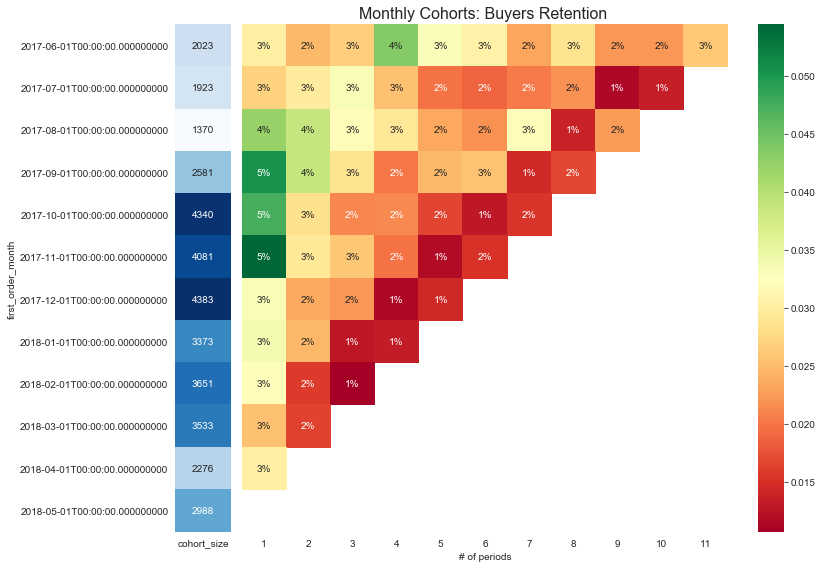

In [238]:
with sns.axes_style("white"):    
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_visits_matrix_monthly.iloc[:,1:], 
                #mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: Buyers Retention ', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')


    # cohort size
    
    sns.heatmap(cohort_orders_monthly_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap='Blues', 
                ax=ax[0])

    fig.tight_layout()

In [239]:
orders.pivot_table(index = 'first_order_month',
                                     columns = 'cohort_lifetime_month',
                                     values = 'uid'
                  ,aggfunc='nunique').pct_change(fill_method=None,axis=1)

cohort_lifetime_month  0         1         2         3         4         5   \
first_order_month                                                             
2017-06-01            NaN -0.969847 -0.180328  0.080000  0.629630 -0.238636   
2017-07-01            NaN -0.972959  0.096154  0.122807 -0.234375 -0.224490   
2017-08-01            NaN -0.957664 -0.086207 -0.169811 -0.090909 -0.200000   
2017-09-01            NaN -0.949632 -0.230769 -0.260000 -0.297297  0.230769   
2017-10-01            NaN -0.952535 -0.402913 -0.252033  0.010870 -0.225806   
2017-11-01            NaN -0.945602 -0.459459 -0.116667 -0.235849 -0.407407   
2017-12-01            NaN -0.966689 -0.294521 -0.058252 -0.484536  0.260000   
2018-01-01            NaN -0.966202 -0.271930 -0.481928  0.046512       NaN   
2018-02-01            NaN -0.967680 -0.508475 -0.327586       NaN       NaN   
2018-03-01            NaN -0.974526 -0.355556       NaN       NaN       NaN   
2018-04-01            NaN -0.969684       NaN       NaN       NaN       NaN   
2018-05-01            NaN       NaN       NaN       NaN       NaN       NaN   

cohort_lifetime_month        6         7         8         9         10  \
first_order_month                                                         
2017-06-01            -0.074627 -0.241935  0.234043 -0.224138  0.000000   
2017-07-01            -0.052632  0.083333  0.076923 -0.476190  0.181818   
2017-08-01            -0.062500  0.466667 -0.568182  0.631579       NaN   
2017-09-01             0.031250 -0.439394  0.162162       NaN       NaN   
2017-10-01            -0.222222  0.196429       NaN       NaN       NaN   
2017-11-01             0.291667       NaN       NaN       NaN       NaN   
2017-12-01                  NaN       NaN       NaN       NaN       NaN   
2018-01-01                  NaN       NaN       NaN       NaN       NaN   
2018-02-01                  NaN       NaN       NaN       NaN       NaN   
2018-03-01                  NaN       NaN       NaN       NaN       NaN   
2018-04-01                  NaN       NaN       NaN       NaN       NaN   
2018-05-01                  NaN       NaN       NaN       NaN       NaN   

cohort_lifetime_month        11  
first_order_month                
2017-06-01             0.177778  
2017-07-01                  NaN  
2017-08-01                  NaN  
2017-09-01                  NaN  
2017-10-01                  NaN  
2017-11-01                  NaN  
2017-12-01                  NaN  
2018-01-01                  NaN  
2018-02-01                  NaN  
2018-03-01                  NaN  
2018-04-01                  NaN  
2018-05-01                  NaN

In [240]:
visits_churn_matrix_monthly = orders.pivot_table(index = 'first_order_month',
                                     columns = 'cohort_lifetime_month',
                                     values = 'uid'
                  ,aggfunc='nunique').pct_change(fill_method=None,axis=1)

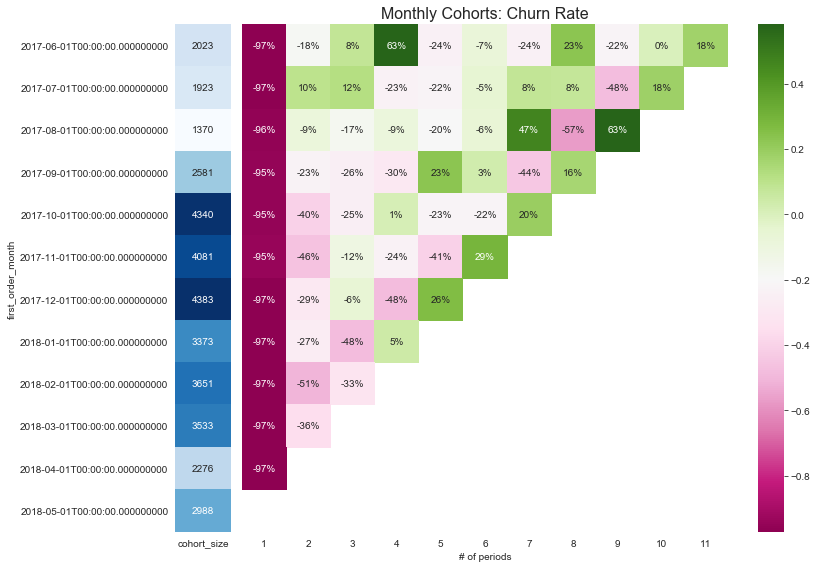

In [241]:
with sns.axes_style("white"):    
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(visits_churn_matrix_monthly.iloc[:,1:], 
                #mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='PiYG',
                robust=True,
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: Churn Rate', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')


    # cohort size
    
    sns.heatmap(cohort_orders_monthly_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap='Blues', 
                robust=True,
                ax=ax[0])

    fig.tight_layout()

#### volatlity here is higher and no need to ommit the first month:
#### I can see, that also after the initial month (on the second one) we have a negative gap for the most of cohorts

In [242]:
orders.pivot_table(index = 'first_order_month',
                                     columns = 'order_month',
                                     values = 'uid'
                  ,aggfunc='nunique').pct_change(fill_method=None,axis=1)

order_month        2017-06-01  2017-07-01  2017-08-01  2017-09-01  2017-10-01  \
first_order_month                                                               
2017-06-01                NaN   -0.969847   -0.180328    0.080000    0.629630   
2017-07-01                NaN         NaN   -0.972959    0.096154    0.122807   
2017-08-01                NaN         NaN         NaN   -0.957664   -0.086207   
2017-09-01                NaN         NaN         NaN         NaN   -0.949632   
2017-10-01                NaN         NaN         NaN         NaN         NaN   
2017-11-01                NaN         NaN         NaN         NaN         NaN   
2017-12-01                NaN         NaN         NaN         NaN         NaN   
2018-01-01                NaN         NaN         NaN         NaN         NaN   
2018-02-01                NaN         NaN         NaN         NaN         NaN   
2018-03-01                NaN         NaN         NaN         NaN         NaN   
2018-04-01                NaN         NaN         NaN         NaN         NaN   
2018-05-01                NaN         NaN         NaN         NaN         NaN   

order_month        2017-11-01  2017-12-01  2018-01-01  2018-02-01  2018-03-01  \
first_order_month                                                               
2017-06-01          -0.238636   -0.074627   -0.241935    0.234043   -0.224138   
2017-07-01          -0.234375   -0.224490   -0.052632    0.083333    0.076923   
2017-08-01          -0.169811   -0.090909   -0.200000   -0.062500    0.466667   
2017-09-01          -0.230769   -0.260000   -0.297297    0.230769    0.031250   
2017-10-01          -0.952535   -0.402913   -0.252033    0.010870   -0.225806   
2017-11-01                NaN   -0.945602   -0.459459   -0.116667   -0.235849   
2017-12-01                NaN         NaN   -0.966689   -0.294521   -0.058252   
2018-01-01                NaN         NaN         NaN   -0.966202   -0.271930   
2018-02-01                NaN         NaN         NaN         NaN   -0.967680   
2018-03-01                NaN         NaN         NaN         NaN         NaN   
2018-04-01                NaN         NaN         NaN         NaN         NaN   
2018-05-01                NaN         NaN         NaN         NaN         NaN   

order_month        2018-04-01  2018-05-01  
first_order_month                          
2017-06-01           0.000000    0.177778  
2017-07-01          -0.476190    0.181818  
2017-08-01          -0.568182    0.631579  
2017-09-01          -0.439394    0.162162  
2017-10-01          -0.222222    0.196429  
2017-11-01          -0.407407    0.291667  
2017-12-01          -0.484536    0.260000  
2018-01-01          -0.481928    0.046512  
2018-02-01          -0.508475   -0.327586  
2018-03-01          -0.974526   -0.355556  
2018-04-01                NaN   -0.969684  
2018-05-01                NaN         NaN

In [243]:
vchurn_orders = orders.pivot_table(index = 'first_order_month',
                                     columns = 'order_month',
                                     values = 'uid'
                  ,aggfunc='nunique').pct_change(fill_method=None,axis=1)

In [244]:
vchurn_orders.columns = vchurn_orders.columns.strftime("%Y-%m")
vchurn_orders.index = vchurn_orders.index.strftime("%Y-%m")

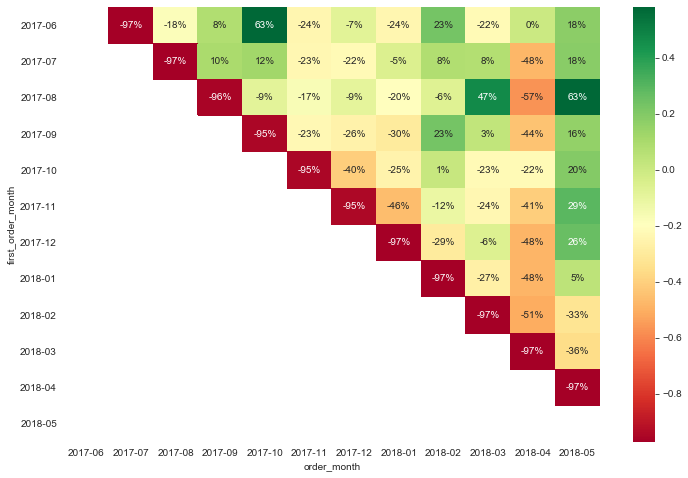

In [245]:

with sns.axes_style("white"):
    plt.figure(figsize=(12, 8))
    sns.heatmap(vchurn_orders,
                
               annot=True, 
                fmt='.0%', 
                cmap='RdYlGn',
                robust=True
               )


#### we have a negative gap for the most of cohort on april 2018, the same picture as it was for visitors

### total number of orders

In [246]:
orders.groupby('order_month')['uid'].count()

order_month
2017-06-01    2354
2017-07-01    2363
2017-08-01    1807
2017-09-01    3387
2017-10-01    5679
2017-11-01    5659
2017-12-01    6218
2018-01-01    4721
2018-02-01    5281
2018-03-01    5326
2018-04-01    3273
2018-05-01    4346
Name: uid, dtype: int64

In [247]:
orders.groupby('order_month')['uid'].count().mean()

4201.166666666667

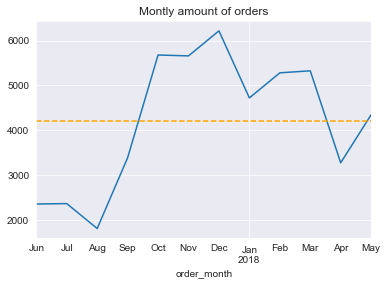

In [248]:
orders.groupby('order_month')['uid'].count().plot()

plt.axhline(orders.groupby('order_month')['uid'].count().mean(), color='orange'
           , linestyle='--'
           ,label='Average Montly amount of orders'
           )

plt.title('Montly amount of orders')

plt.show()

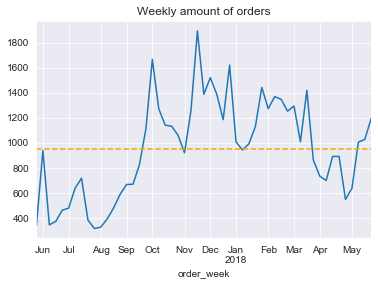

In [249]:
orders.groupby('order_week')['uid'].count().plot()

plt.axhline(orders.groupby('order_week')['uid'].count().mean(), color='orange'
           , linestyle='--'
           ,label='Average Weekly amount of orders'
           )

plt.title('Weekly amount of orders')

plt.show()

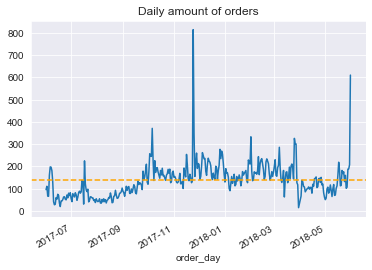

In [250]:
orders.groupby('order_day')['uid'].count().plot()

plt.axhline(orders.groupby('order_day')['uid'].count().mean(), color='orange'
           , linestyle='--'
           ,label='Average Daily amount of orders'
           )

plt.title('Daily amount of orders')

plt.show()

In [251]:
orders.pivot_table(index = 'first_order_month',
                                     columns = 'cohort_lifetime_month',
                                     values = 'uid'
                  ,aggfunc='count')


cohort_lifetime_month      0      1      2      3      4      5      6   \
first_order_month                                                         
2017-06-01             2354.0  177.0  174.0  226.0  292.0  218.0  276.0   
2017-07-01             2186.0  100.0  120.0  104.0   72.0   82.0   61.0   
2017-08-01             1533.0  108.0  100.0   81.0   85.0   62.0   49.0   
2017-09-01             2933.0  219.0  161.0  164.0   67.0  109.0  108.0   
2017-10-01             4964.0  314.0  162.0  122.0  129.0  103.0   86.0   
2017-11-01             4813.0  397.0  182.0  211.0  136.0   59.0  102.0   
2017-12-01             5052.0  270.0  202.0  179.0   86.0  105.0    NaN   
2018-01-01             3783.0  224.0  159.0   64.0   78.0    NaN    NaN   
2018-02-01             4095.0  222.0   83.0   70.0    NaN    NaN    NaN   
2018-03-01             4130.0  178.0  176.0    NaN    NaN    NaN    NaN   
2018-04-01             2495.0  195.0    NaN    NaN    NaN    NaN    NaN   
2018-05-01             3249.0    NaN    NaN    NaN    NaN    NaN    NaN   

cohort_lifetime_month     7      8      9     10    11  
first_order_month                                       
2017-06-01             174.0  212.0  153.0  96.0  86.0  
2017-07-01              50.0   58.0   24.0  53.0   NaN  
2017-08-01              78.0   46.0   46.0   NaN   NaN  
2017-09-01              56.0   61.0    NaN   NaN   NaN  
2017-10-01             125.0    NaN    NaN   NaN   NaN  
2017-11-01               NaN    NaN    NaN   NaN   NaN  
2017-12-01               NaN    NaN    NaN   NaN   NaN  
2018-01-01               NaN    NaN    NaN   NaN   NaN  
2018-02-01               NaN    NaN    NaN   NaN   NaN  
2018-03-01               NaN    NaN    NaN   NaN   NaN  
2018-04-01               NaN    NaN    NaN   NaN   NaN  
2018-05-01               NaN    NaN    NaN   NaN   NaN

In [252]:
o_pivot = orders.pivot_table(index = 'first_order_month',
                                     columns = 'cohort_lifetime_month',
                                     values = 'uid'
                  ,aggfunc='count')

In [253]:
cohort_o_monthly_size = o_pivot.iloc[:,0]

In [254]:
cohort_o_monthly_size_df = pd.DataFrame(cohort_o_monthly_size).rename(columns={0: 'cohort_size'})

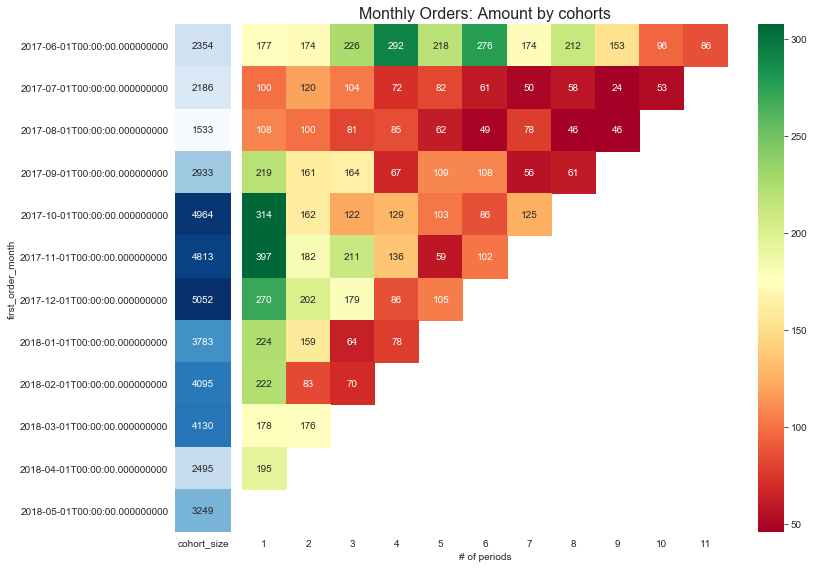

In [255]:
with sns.axes_style("white"):    
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(o_pivot.iloc[:,1:], 
                #mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0f', 
                cmap='RdYlGn',
                robust=True,
                ax=ax[1])
    ax[1].set_title('Monthly Orders: Amount by cohorts', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')


    # cohort size
    
    sns.heatmap(cohort_o_monthly_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap='Blues', 
                robust=True,
                ax=ax[0])

    fig.tight_layout()

In [256]:
o_pivot.divide(cohort_o_monthly_size, axis = 0)

cohort_lifetime_month   0         1         2         3         4         5   \
first_order_month                                                              
2017-06-01             1.0  0.075191  0.073917  0.096007  0.124044  0.092608   
2017-07-01             1.0  0.045746  0.054895  0.047575  0.032937  0.037511   
2017-08-01             1.0  0.070450  0.065232  0.052838  0.055447  0.040444   
2017-09-01             1.0  0.074668  0.054893  0.055915  0.022844  0.037163   
2017-10-01             1.0  0.063255  0.032635  0.024577  0.025987  0.020749   
2017-11-01             1.0  0.082485  0.037814  0.043840  0.028257  0.012258   
2017-12-01             1.0  0.053444  0.039984  0.035432  0.017023  0.020784   
2018-01-01             1.0  0.059212  0.042030  0.016918  0.020619       NaN   
2018-02-01             1.0  0.054212  0.020269  0.017094       NaN       NaN   
2018-03-01             1.0  0.043099  0.042615       NaN       NaN       NaN   
2018-04-01             1.0  0.078156       NaN       NaN       NaN       NaN   
2018-05-01             1.0       NaN       NaN       NaN       NaN       NaN   

cohort_lifetime_month        6         7         8         9         10  \
first_order_month                                                         
2017-06-01             0.117247  0.073917  0.090059  0.064996  0.040782   
2017-07-01             0.027905  0.022873  0.026532  0.010979  0.024245   
2017-08-01             0.031963  0.050881  0.030007  0.030007       NaN   
2017-09-01             0.036822  0.019093  0.020798       NaN       NaN   
2017-10-01             0.017325  0.025181       NaN       NaN       NaN   
2017-11-01             0.021193       NaN       NaN       NaN       NaN   
2017-12-01                  NaN       NaN       NaN       NaN       NaN   
2018-01-01                  NaN       NaN       NaN       NaN       NaN   
2018-02-01                  NaN       NaN       NaN       NaN       NaN   
2018-03-01                  NaN       NaN       NaN       NaN       NaN   
2018-04-01                  NaN       NaN       NaN       NaN       NaN   
2018-05-01                  NaN       NaN       NaN       NaN       NaN   

cohort_lifetime_month        11  
first_order_month                
2017-06-01             0.036534  
2017-07-01                  NaN  
2017-08-01                  NaN  
2017-09-01                  NaN  
2017-10-01                  NaN  
2017-11-01                  NaN  
2017-12-01                  NaN  
2018-01-01                  NaN  
2018-02-01                  NaN  
2018-03-01                  NaN  
2018-04-01                  NaN  
2018-05-01                  NaN

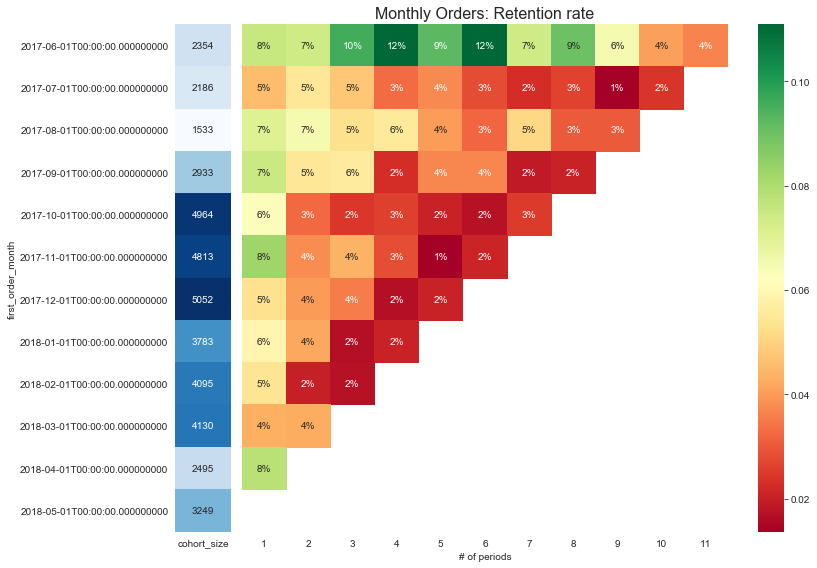

In [257]:
with sns.axes_style("white"):    
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(o_pivot.divide(cohort_o_monthly_size, axis = 0).iloc[:,1:], 
                #mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn',
                robust=True,
                ax=ax[1])
    ax[1].set_title('Monthly Orders: Retention rate', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')


    # cohort size
    
    sns.heatmap(cohort_o_monthly_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap='Blues', 
                robust=True,
                ax=ax[0])

    fig.tight_layout()

#### We can see as in general, also by cohorts a slight resurection on the last period by number of orders

#### I could assume that the number of generating buyers is the vital indicator, because the number of extra big orders is relatively small and the median revenue is constant enough. So the main way to bring profit is to boost the number of deals.

### Conversion

Text(0.5, 1.0, 'Monthly observing of conversion factors')

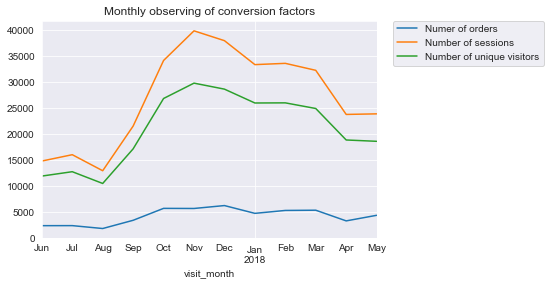

In [258]:
orders.groupby('order_month')['uid'].count().plot(label='Numer of orders')
visits.groupby('visit_month')['uid'].count().plot(label='Number of sessions')
visits.groupby('visit_month')['uid'].nunique().plot(label='Number of unique visitors')

#plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.title('Monthly observing of conversion factors')

In [259]:
(orders.groupby('order_month')['uid'].nunique() / visits.groupby('visit_month')['uid'].nunique()).mean()

0.16223284582924322

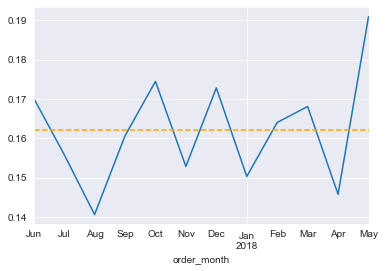

In [260]:
(orders.groupby('order_month')['uid'].nunique() / visits.groupby('visit_month')['uid'].nunique()).plot()

plt.axhline((orders.groupby('order_month')['uid'].nunique() / visits.groupby('visit_month')['uid'].nunique()).mean()
           ,color = 'orange'
           , linestyle='--'
           ,label='Average monthly conversion'
           )

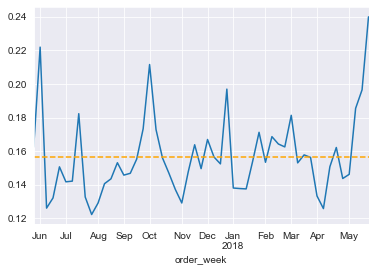

In [261]:
(orders.groupby('order_week')['uid'].nunique() / visits.groupby('visit_week')['uid'].nunique()).plot()

plt.axhline((orders.groupby('order_week')['uid'].nunique() / visits.groupby('visit_week')['uid'].nunique()).mean()
           ,color = 'orange'
           , linestyle='--'
           ,label='Average weekly conversion'
           )

plt.show()

In [262]:
cohort_o_monthly_size / cohort_size_monthly

first_order_month
2017-06-01    0.198065
2017-07-01    0.184863
2017-08-01    0.166377
2017-09-01    0.193917
2017-10-01    0.210893
2017-11-01    0.193667
2017-12-01    0.219366
2018-01-01    0.183882
2018-02-01    0.202994
2018-03-01    0.219763
2018-04-01    0.175519
2018-05-01    0.234958
Name: 0, dtype: float64

#### average monthly conversion is about 16% and on recent periods we can notice positive tendency

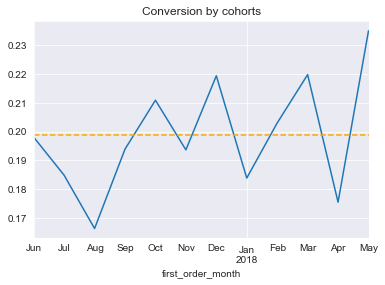

In [263]:
(cohort_o_monthly_size / cohort_size_monthly).plot()

plt.axhline((cohort_o_monthly_size / cohort_size_monthly).mean()
           ,color = 'orange'
           , linestyle='--'
           ,label='Average monthly cohort conversion')
plt.title('Conversion by cohorts')
plt.show()

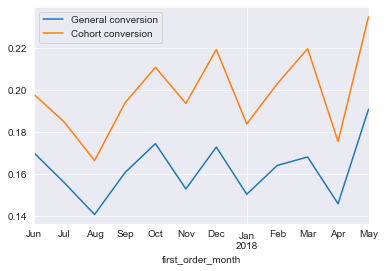

In [264]:
(orders.groupby('order_month')['uid'].nunique() / visits.groupby('visit_month')['uid'].nunique()).plot(label='General conversion')

(cohort_o_monthly_size / cohort_size_monthly).plot(label='Cohort conversion')

plt.legend()

plt.show()

#### also it is noticable, that we have positive tendence in conversion among the cohorts' buyers, that is even slightly higher, that simple monthly

In [265]:
(cohort_o_monthly_size / cohort_size_monthly) / (orders.groupby('order_month')['uid'].nunique() / visits.groupby('visit_month')['uid'].nunique())

first_order_month
2017-06-01    1.163618
2017-07-01    1.185674
2017-08-01    1.182838
2017-09-01    1.207012
2017-10-01    1.208699
2017-11-01    1.266903
2017-12-01    1.269189
2018-01-01    1.223205
2018-02-01    1.237368
2018-03-01    1.307328
2018-04-01    1.203877
2018-05-01    1.230878
dtype: float64

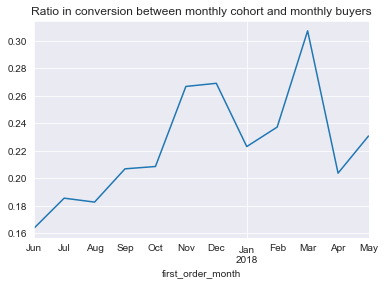

In [266]:
((cohort_o_monthly_size / cohort_size_monthly) / (orders.groupby('order_month')['uid'].nunique() / visits.groupby('visit_month')['uid'].nunique())-1).plot()

plt.title('Ratio in conversion between monthly cohort and monthly buyers')

plt.show()

#### this graph shows, that conversion in cohorts is higher than for users in general over all the observing period

### How much money do they bring? LTV

In [267]:
orders_revenue_pivot_monthly = orders.pivot_table(index = 'first_order_month',
                                     columns = 'cohort_lifetime_month',
                                     values = 'revenue'
                  ,aggfunc='sum')

In [268]:
orders_revenue_pivot_monthly.round()

cohort_lifetime_month       0       1       2        3       4       5   \
first_order_month                                                         
2017-06-01              9557.0   982.0   885.0   1931.0  2069.0  1488.0   
2017-07-01             11558.0   645.0  1199.0    690.0   340.0   300.0   
2017-08-01              7229.0   647.0   628.0    536.0   677.0   388.0   
2017-09-01             14569.0  2884.0  1345.0  10262.0  1034.0  1670.0   
2017-10-01             21716.0  2325.0   831.0    682.0   658.0   522.0   
2017-11-01             21036.0  1629.0   814.0   1326.0   604.0   220.0   
2017-12-01             20767.0  1141.0  4055.0   4669.0  1372.0  1482.0   
2018-01-01             13949.0   994.0  1026.0    482.0   211.0     NaN   
2018-02-01             15177.0  1016.0   287.0    271.0     NaN     NaN   
2018-03-01             17095.0  1063.0  1115.0      NaN     NaN     NaN   
2018-04-01             10601.0  1210.0     NaN      NaN     NaN     NaN   
2018-05-01             13926.0     NaN     NaN      NaN     NaN     NaN   

cohort_lifetime_month      6       7       8       9       10     11  
first_order_month                                                     
2017-06-01             1923.0  1177.0  1119.0  1226.0  1156.0  520.0  
2017-07-01              231.0   273.0   310.0   283.0   299.0    NaN  
2017-08-01              289.0   555.0   400.0   258.0     NaN    NaN  
2017-09-01             1811.0   628.0   475.0     NaN     NaN    NaN  
2017-10-01              368.0   501.0     NaN     NaN     NaN    NaN  
2017-11-01              469.0     NaN     NaN     NaN     NaN    NaN  
2017-12-01                NaN     NaN     NaN     NaN     NaN    NaN  
2018-01-01                NaN     NaN     NaN     NaN     NaN    NaN  
2018-02-01                NaN     NaN     NaN     NaN     NaN    NaN  
2018-03-01                NaN     NaN     NaN     NaN     NaN    NaN  
2018-04-01                NaN     NaN     NaN     NaN     NaN    NaN  
2018-05-01                NaN     NaN     NaN     NaN     NaN    NaN

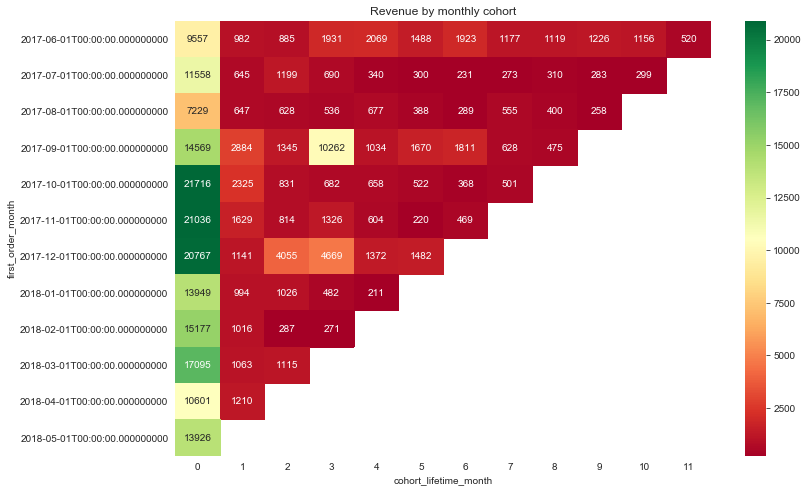

In [269]:
with sns.axes_style("white"):
    plt.figure(figsize=(12, 8))
    sns.heatmap(orders_revenue_pivot_monthly,
                
               annot=True, 
                fmt='.0f', 
                cmap='RdYlGn',
                robust=True
               )
    
    plt.title('Revenue by monthly cohort')

In [270]:
orders.pivot_table(index = 'first_order_month',
                                     columns = 'cohort_lifetime_month',
                                     values = 'revenue'
                  ,aggfunc='sum').cumsum(axis=1)

cohort_lifetime_month        0         1         2         3         4   \
first_order_month                                                         
2017-06-01              9557.49  10539.31  11424.65  13355.95  15424.53   
2017-07-01             11557.65  12202.26  13401.31  14091.62  14431.59   
2017-08-01              7228.83   7875.46   8503.58   9039.63   9716.48   
2017-09-01             14568.53  17453.02  18797.54  29059.06  30092.90   
2017-10-01             21716.20  24041.41  24872.06  25554.07  26211.84   
2017-11-01             21036.26  22665.53  23479.92  24806.05  25410.09   
2017-12-01             20767.49  21908.71  25963.41  30632.51  32004.08   
2018-01-01             13949.50  14943.72  15970.06  16451.65  16663.13   
2018-02-01             15177.16  16193.14  16479.80  16750.50       NaN   
2018-03-01             17095.49  18158.54  19273.41       NaN       NaN   
2018-04-01             10600.69  11810.61       NaN       NaN       NaN   
2018-05-01             13925.76       NaN       NaN       NaN       NaN   

cohort_lifetime_month        5         6         7         8         9   \
first_order_month                                                         
2017-06-01             16912.45  18835.19  20011.75  21130.90  22356.41   
2017-07-01             14731.67  14962.83  15235.55  15545.60  15828.56   
2017-08-01             10104.93  10393.54  10948.40  11348.73  11606.26   
2017-09-01             31762.98  33573.83  34201.40  34676.32       NaN   
2017-10-01             26734.21  27102.31  27603.45       NaN       NaN   
2017-11-01             25629.97  26098.99       NaN       NaN       NaN   
2017-12-01             33485.74       NaN       NaN       NaN       NaN   
2018-01-01                  NaN       NaN       NaN       NaN       NaN   
2018-02-01                  NaN       NaN       NaN       NaN       NaN   
2018-03-01                  NaN       NaN       NaN       NaN       NaN   
2018-04-01                  NaN       NaN       NaN       NaN       NaN   
2018-05-01                  NaN       NaN       NaN       NaN       NaN   

cohort_lifetime_month        10        11  
first_order_month                          
2017-06-01             23512.07  24031.69  
2017-07-01             16127.92       NaN  
2017-08-01                  NaN       NaN  
2017-09-01                  NaN       NaN  
2017-10-01                  NaN       NaN  
2017-11-01                  NaN       NaN  
2017-12-01                  NaN       NaN  
2018-01-01                  NaN       NaN  
2018-02-01                  NaN       NaN  
2018-03-01                  NaN       NaN  
2018-04-01                  NaN       NaN  
2018-05-01                  NaN       NaN

In [271]:
orders.pivot_table(index = 'first_order_month',
                                     columns = 'cohort_lifetime_month',
                                     values = 'revenue'
                  ,aggfunc='sum').sum(axis=1)

first_order_month
2017-06-01    24031.69
2017-07-01    16127.92
2017-08-01    11606.26
2017-09-01    34676.32
2017-10-01    27603.45
2017-11-01    26098.99
2017-12-01    33485.74
2018-01-01    16663.13
2018-02-01    16750.50
2018-03-01    19273.41
2018-04-01    11810.61
2018-05-01    13925.76
dtype: float64

In [272]:
ltv_monthly = orders.pivot_table(index = 'first_order_month',
                                     columns = 'cohort_lifetime_month',
                                     values = 'revenue'
                  ,aggfunc='sum').sum(axis=1)

In [273]:
ltv_monthly.index = ltv_monthly.index.strftime('%Y-%m')

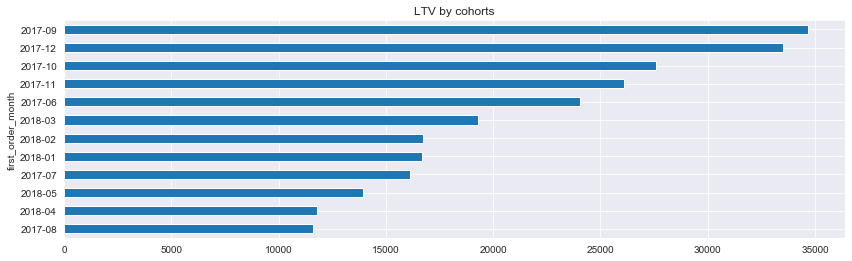

In [274]:
plt.figure(figsize=(14,4))

ltv_monthly.sort_values().plot(kind='barh')

plt.title('LTV by cohorts')

plt.show()

#### Cohorts from Sep and Dec 2017 show best results by LTV. Deeper analysis showed that for both of them crucial part of revenue was brought by some outstanding months.

In [275]:
retention_matrix_monthly.unstack(0).unstack()[1:]

first_visit_month       2017-06   2017-07   2017-08   2017-09   2017-10  \
cohort_lifetime_month                                                     
1                      0.075726  0.054545  0.074452  0.083570  0.078129   
2                      0.050989  0.050402  0.060451  0.067769  0.050811   
3                      0.059739  0.055645  0.060451  0.049322  0.037811   
4                      0.065377  0.056660  0.047970  0.038083  0.033648   
5                      0.067480  0.046512  0.041459  0.036959  0.031184   
6                      0.057720  0.044059  0.036249  0.035372  0.020775   
7                      0.056121  0.044059  0.037660  0.022876  0.019798   
8                      0.050989  0.037886  0.027133  0.022744       NaN   
9                      0.049727  0.027315  0.024745       NaN       NaN   
10                     0.038115  0.027061       NaN       NaN       NaN   
11                     0.043921       NaN       NaN       NaN       NaN   

first_visit_month       2017-11   2017-12   2018-01   2018-02   2018-03  \
cohort_lifetime_month                                                     
1                      0.078183  0.054668  0.057794  0.056561  0.040760   
2                      0.042733  0.036518  0.037817  0.024290  0.025541   
3                      0.037824  0.030178  0.024352  0.019184       NaN   
4                      0.032593  0.019453  0.019249       NaN       NaN   
5                      0.021729  0.017716       NaN       NaN       NaN   
6                      0.020602       NaN       NaN       NaN       NaN   
7                           NaN       NaN       NaN       NaN       NaN   
8                           NaN       NaN       NaN       NaN       NaN   
9                           NaN       NaN       NaN       NaN       NaN   
10                          NaN       NaN       NaN       NaN       NaN   
11                          NaN       NaN       NaN       NaN       NaN   

first_visit_month       2018-04  2018-05  
cohort_lifetime_month                     
1                      0.047485      NaN  
2                           NaN      NaN  
3                           NaN      NaN  
4                           NaN      NaN  
5                           NaN      NaN  
6                           NaN      NaN  
7                           NaN      NaN  
8                           NaN      NaN  
9                           NaN      NaN  
10                          NaN      NaN  
11                          NaN      NaN

In [276]:
orders.pivot_table(index = 'first_order_month',
                                     columns = 'cohort_lifetime_month',
                                     values = 'revenue'
                  ,aggfunc='sum').cumsum(axis=1)

cohort_lifetime_month        0         1         2         3         4   \
first_order_month                                                         
2017-06-01              9557.49  10539.31  11424.65  13355.95  15424.53   
2017-07-01             11557.65  12202.26  13401.31  14091.62  14431.59   
2017-08-01              7228.83   7875.46   8503.58   9039.63   9716.48   
2017-09-01             14568.53  17453.02  18797.54  29059.06  30092.90   
2017-10-01             21716.20  24041.41  24872.06  25554.07  26211.84   
2017-11-01             21036.26  22665.53  23479.92  24806.05  25410.09   
2017-12-01             20767.49  21908.71  25963.41  30632.51  32004.08   
2018-01-01             13949.50  14943.72  15970.06  16451.65  16663.13   
2018-02-01             15177.16  16193.14  16479.80  16750.50       NaN   
2018-03-01             17095.49  18158.54  19273.41       NaN       NaN   
2018-04-01             10600.69  11810.61       NaN       NaN       NaN   
2018-05-01             13925.76       NaN       NaN       NaN       NaN   

cohort_lifetime_month        5         6         7         8         9   \
first_order_month                                                         
2017-06-01             16912.45  18835.19  20011.75  21130.90  22356.41   
2017-07-01             14731.67  14962.83  15235.55  15545.60  15828.56   
2017-08-01             10104.93  10393.54  10948.40  11348.73  11606.26   
2017-09-01             31762.98  33573.83  34201.40  34676.32       NaN   
2017-10-01             26734.21  27102.31  27603.45       NaN       NaN   
2017-11-01             25629.97  26098.99       NaN       NaN       NaN   
2017-12-01             33485.74       NaN       NaN       NaN       NaN   
2018-01-01                  NaN       NaN       NaN       NaN       NaN   
2018-02-01                  NaN       NaN       NaN       NaN       NaN   
2018-03-01                  NaN       NaN       NaN       NaN       NaN   
2018-04-01                  NaN       NaN       NaN       NaN       NaN   
2018-05-01                  NaN       NaN       NaN       NaN       NaN   

cohort_lifetime_month        10        11  
first_order_month                          
2017-06-01             23512.07  24031.69  
2017-07-01             16127.92       NaN  
2017-08-01                  NaN       NaN  
2017-09-01                  NaN       NaN  
2017-10-01                  NaN       NaN  
2017-11-01                  NaN       NaN  
2017-12-01                  NaN       NaN  
2018-01-01                  NaN       NaN  
2018-02-01                  NaN       NaN  
2018-03-01                  NaN       NaN  
2018-04-01                  NaN       NaN  
2018-05-01                  NaN       NaN

In [277]:
orders.pivot_table(index = 'first_order_month',
                                     columns = 'cohort_lifetime_month',
                                     values = 'revenue'
                  ,aggfunc='sum').cumsum(axis=1).unstack(0).unstack()

first_order_month      2017-06-01  2017-07-01  2017-08-01  2017-09-01  \
cohort_lifetime_month                                                   
0                         9557.49    11557.65     7228.83    14568.53   
1                        10539.31    12202.26     7875.46    17453.02   
2                        11424.65    13401.31     8503.58    18797.54   
3                        13355.95    14091.62     9039.63    29059.06   
4                        15424.53    14431.59     9716.48    30092.90   
5                        16912.45    14731.67    10104.93    31762.98   
6                        18835.19    14962.83    10393.54    33573.83   
7                        20011.75    15235.55    10948.40    34201.40   
8                        21130.90    15545.60    11348.73    34676.32   
9                        22356.41    15828.56    11606.26         NaN   
10                       23512.07    16127.92         NaN         NaN   
11                       24031.69         NaN         NaN         NaN   

first_order_month      2017-10-01  2017-11-01  2017-12-01  2018-01-01  \
cohort_lifetime_month                                                   
0                        21716.20    21036.26    20767.49    13949.50   
1                        24041.41    22665.53    21908.71    14943.72   
2                        24872.06    23479.92    25963.41    15970.06   
3                        25554.07    24806.05    30632.51    16451.65   
4                        26211.84    25410.09    32004.08    16663.13   
5                        26734.21    25629.97    33485.74         NaN   
6                        27102.31    26098.99         NaN         NaN   
7                        27603.45         NaN         NaN         NaN   
8                             NaN         NaN         NaN         NaN   
9                             NaN         NaN         NaN         NaN   
10                            NaN         NaN         NaN         NaN   
11                            NaN         NaN         NaN         NaN   

first_order_month      2018-02-01  2018-03-01  2018-04-01  2018-05-01  
cohort_lifetime_month                                                  
0                        15177.16    17095.49    10600.69    13925.76  
1                        16193.14    18158.54    11810.61         NaN  
2                        16479.80    19273.41         NaN         NaN  
3                        16750.50         NaN         NaN         NaN  
4                             NaN         NaN         NaN         NaN  
5                             NaN         NaN         NaN         NaN  
6                             NaN         NaN         NaN         NaN  
7                             NaN         NaN         NaN         NaN  
8                             NaN         NaN         NaN         NaN  
9                             NaN         NaN         NaN         NaN  
10                            NaN         NaN         NaN         NaN  
11                            NaN         NaN         NaN         NaN

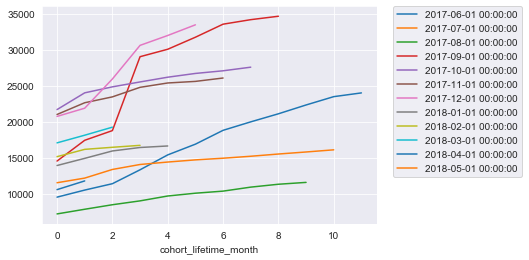

In [278]:
orders.pivot_table(index = 'first_order_month',
                                     columns = 'cohort_lifetime_month',
                                     values = 'revenue'
                  ,aggfunc='sum').cumsum(axis=1).unstack(0).unstack().plot()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### cohorts from Oct, Nov 2017 and Mar 2018 show good overall results: indicators are stable and relatively high   

In [279]:
orders_revenue_pivot_monthly / cohort_orders_monthly_pivot

cohort_lifetime_month        0          1          2           3          4   \
first_order_month                                                              
2017-06-01             4.724414  16.095410  17.706800   35.764815  23.506591   
2017-07-01             6.010218  12.396346  21.035965   10.786094   6.938163   
2017-08-01             5.276518  11.148793  11.851321   12.182955  16.921250   
2017-09-01             5.644529  22.188385  13.445200  138.669189  19.881538   
2017-10-01             5.003733  11.287427   6.753252    7.413152   7.072796   
2017-11-01             5.154683   7.339054   6.786583   12.510660   7.457284   
2017-12-01             4.738191   7.816575  39.366019   48.135052  27.431400   
2018-01-01             4.135636   8.721228  12.365542   11.199767   4.699556   
2018-02-01             4.156987   8.610000   4.942414    6.941026        NaN   
2018-03-01             4.838803  11.811667  19.221897         NaN        NaN   
2018-04-01             4.657597  17.535072        NaN         NaN        NaN   
2018-05-01             4.660562        NaN        NaN         NaN        NaN   

cohort_lifetime_month         5          6          7          8          9   \
first_order_month                                                              
2017-06-01             22.207761  31.011935  25.033191  19.295690  27.233556   
2017-07-01              7.896842   6.421111   6.992821   7.382143  12.861818   
2017-08-01             12.139063   9.620333  12.610455  21.070000   8.307419   
2017-09-01             26.095000  27.437121  16.961351  11.044651        NaN   
2017-10-01              7.255139   6.573214   7.479701        NaN        NaN   
2017-11-01              4.580833   7.564839        NaN        NaN        NaN   
2017-12-01             23.518413        NaN        NaN        NaN        NaN   
2018-01-01                   NaN        NaN        NaN        NaN        NaN   
2018-02-01                   NaN        NaN        NaN        NaN        NaN   
2018-03-01                   NaN        NaN        NaN        NaN        NaN   
2018-04-01                   NaN        NaN        NaN        NaN        NaN   
2018-05-01                   NaN        NaN        NaN        NaN        NaN   

cohort_lifetime_month         10        11  
first_order_month                           
2017-06-01             25.681333  9.804151  
2017-07-01             11.513846       NaN  
2017-08-01                   NaN       NaN  
2017-09-01                   NaN       NaN  
2017-10-01                   NaN       NaN  
2017-11-01                   NaN       NaN  
2017-12-01                   NaN       NaN  
2018-01-01                   NaN       NaN  
2018-02-01                   NaN       NaN  
2018-03-01                   NaN       NaN  
2018-04-01                   NaN       NaN  
2018-05-01                   NaN       NaN

In [280]:
pivot_revenue_per_user = orders_revenue_pivot_monthly / cohort_orders_monthly_pivot

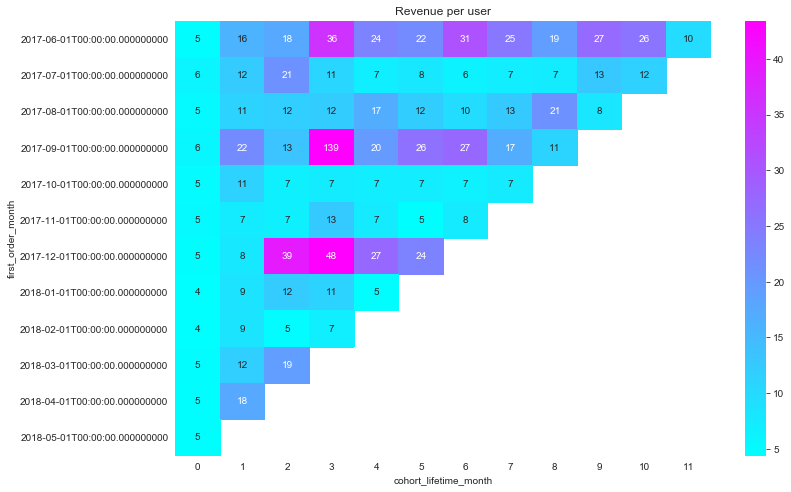

In [281]:
with sns.axes_style("white"):
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_revenue_per_user,
                
               annot=True, 
                fmt='.0f', 
                cmap='cool',
                robust=True
               )
    
    plt.title('Revenue per user')

#### As I assumed previously Sep and Dec 2017 had some months with "big purchases". In addition to that the first cohort shows very good constant results.

### When do people start buying?

In [282]:
users_first_time = visits.sort_values('start_ts').groupby('uid').first()[['start_ts','source_id']]

In [283]:
orders_full = pd.merge(orders, users_first_time, left_on='uid', right_index=True)

### !!! Important general assumption. for this project I assume that this simple merge quite correct, because on my previous investigation I've noticed, that:
1) we can't have a deal "out" of the session time
2) some users on the same "first" day arrived from different sources.
3) We have some "strange" sessions with huge session time, where start_ts day is not equal to buy_ts

And if proceed with all these verifications it will be only about 35000 matches between visitors and buyers


In [284]:
orders_full[orders_full['buy_ts']<=orders_full['start_ts']]

buy_ts  revenue                   uid  order_day  \
5     2017-06-01 08:43:00     0.18  10402394430196413321 2017-06-01   
7     2017-06-01 09:22:00     1.22   3644482766749211722 2017-06-01   
24    2017-06-01 14:14:00     1.22   6749200142647927813 2017-06-01   
45    2017-06-01 18:07:00     9.17   3963367130094376110 2017-06-01   
52    2017-06-01 19:27:00     1.10  11819047673449139952 2017-06-01   
...                   ...      ...                   ...        ...   
50308 2018-05-31 18:51:00     6.60   6232944553128890218 2018-05-31   
50330 2018-05-31 19:42:00     2.32   3341427958880475005 2018-05-31   
50332 2018-05-31 19:43:00     1.77   4194075740388201505 2018-05-31   
50355 2018-05-31 21:04:00     2.20  12484396335714047199 2018-05-31   
50364 2018-05-31 21:26:00     8.25   3284532416210755505 2018-05-31   

      order_week order_month first_order_week first_order_month  \
5     2017-05-29  2017-06-01       2017-05-29        2017-06-01   
7     2017-05-29  2017-06-01       2017-05-29        2017-06-01   
24    2017-05-29  2017-06-01       2017-05-29        2017-06-01   
45    2017-05-29  2017-06-01       2017-05-29        2017-06-01   
52    2017-05-29  2017-06-01       2017-05-29        2017-06-01   
...          ...         ...              ...               ...   
50308 2018-05-28  2018-05-01       2018-05-28        2018-05-01   
50330 2018-05-28  2018-05-01       2018-05-28        2018-05-01   
50332 2018-05-28  2018-05-01       2018-05-28        2018-05-01   
50355 2018-05-28  2018-05-01       2018-05-28        2018-05-01   
50364 2018-05-28  2018-05-01       2018-05-28        2018-05-01   

       cohort_lifetime_month  cohort_lifetime_week            start_ts  \
5                          0                     0 2017-06-01 08:43:00   
7                          0                     0 2017-06-01 09:22:00   
24                         0                     0 2017-06-01 14:14:00   
45                         0                     0 2017-06-01 18:07:00   
52                         0                     0 2017-06-01 19:27:00   
...                      ...                   ...                 ...   
50308                      0                     0 2018-05-31 18:51:00   
50330                      0                     0 2018-05-31 19:42:00   
50332                      0                     0 2018-05-31 19:43:00   
50355                      0                     0 2018-05-31 21:04:00   
50364                      0                     0 2018-05-31 21:26:00   

       source_id  
5              3  
7              1  
24             5  
45             1  
52             5  
...          ...  
50308          2  
50330          3  
50332          3  
50355          2  
50364          4  

[2551 rows x 12 columns]

#### Orders, which have buy time earlier than the start time are incorrect

In [285]:
strange_orders = orders_full[orders_full['buy_ts']<=orders_full['start_ts']]

In [286]:
orders_full = orders_full[orders_full['buy_ts']>orders_full['start_ts']]

In [287]:
orders_full['buy_gap_min'] = (orders_full['buy_ts']-orders_full['start_ts'])/np.timedelta64(1,'m')

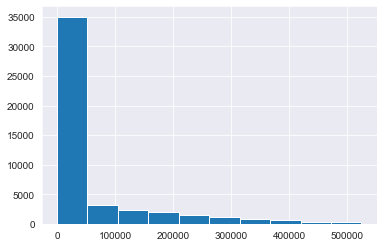

In [288]:
orders_full['buy_gap_min'].hist()

In [289]:
orders_full['buy_gap_min'].describe()

count     47389.000000
mean      54562.936947
std      102471.166405
min           1.000000
25%           8.000000
50%         348.000000
75%       59449.000000
max      524669.000000
Name: buy_gap_min, dtype: float64

In [290]:
orders_full['buy_gap_min'].max()/60

8744.483333333334

In [291]:
orders_full['buy_gap_min'].max()/(60*24)

364.3534722222222

In [292]:
np.percentile(orders_full['buy_gap_min'],[90,95,99])

array([211879.8 , 298383.8 , 437787.32])

#### some orders were made much after the initial visits, the maximum gap is about a year

#### I'd like to check intervals accordind to standart calendar intervals:
1) hour = 60 min 
2) day = 1440 min (1500)
3) week = 10080 min (10000)
4) month = 43200 min (45000)


In [293]:
def len_group(x):
    if x['buy_gap_min']<=60:
        return 'in_hour'
    elif x['buy_gap_min']<=1500:
        return 'in_day'
    elif x['buy_gap_min']<=10000:
        return 'in_week'
    elif x['buy_gap_min']<=45000:
        return 'in_month'
    else:
        return 'in_year'

In [294]:
orders_full['len_group'] = orders_full.apply(len_group,axis=1)

orders_full['len_group'].value_counts(dropna=False)

in_hour     20885
in_year     12921
in_day       5209
in_month     4494
in_week      3880
Name: len_group, dtype: int64

In [295]:
orders_full.head()

buy_ts  revenue                   uid  order_day order_week  \
0 2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01 2017-05-29   
1 2017-06-01 00:25:00     0.55  11627257723692907447 2017-06-01 2017-05-29   
2 2017-06-01 00:27:00     0.37  17903680561304213844 2017-06-01 2017-05-29   
3 2017-06-01 00:29:00     0.55  16109239769442553005 2017-06-01 2017-05-29   
4 2017-06-01 07:58:00     0.37  14200605875248379450 2017-06-01 2017-05-29   

  order_month first_order_week first_order_month  cohort_lifetime_month  \
0  2017-06-01       2017-05-29        2017-06-01                      0   
1  2017-06-01       2017-05-29        2017-06-01                      0   
2  2017-06-01       2017-05-29        2017-06-01                      0   
3  2017-06-01       2017-05-29        2017-06-01                      0   
4  2017-06-01       2017-05-29        2017-06-01                      0   

   cohort_lifetime_week            start_ts  source_id  buy_gap_min len_group  
0                     0 2017-06-01 00:09:00          1          1.0   in_hour  
1                     0 2017-06-01 00:14:00          2         11.0   in_hour  
2                     0 2017-06-01 00:25:00          2          2.0   in_hour  
3                     0 2017-06-01 00:14:00          2         15.0   in_hour  
4                     0 2017-06-01 07:31:00          3         27.0   in_hour

C:\Users\Yuri\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


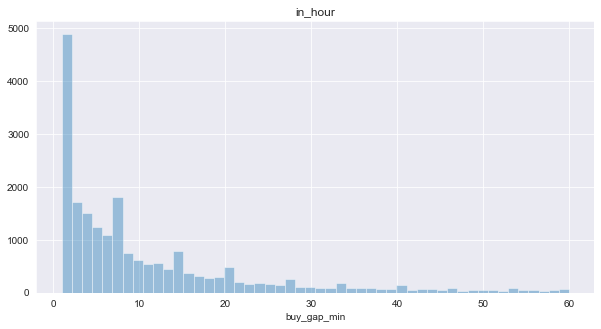

C:\Users\Yuri\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


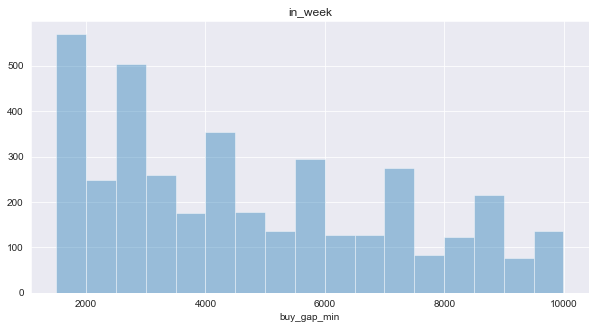

C:\Users\Yuri\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


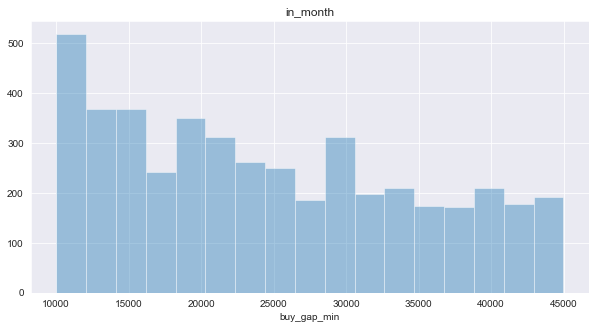

C:\Users\Yuri\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


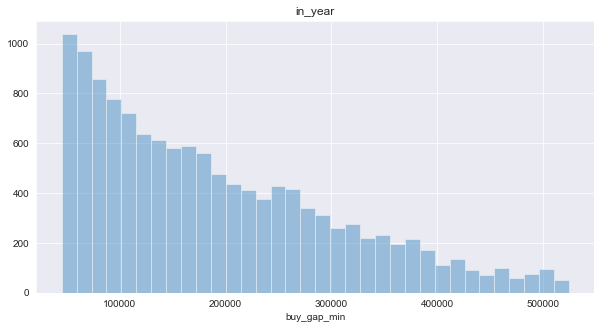

C:\Users\Yuri\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


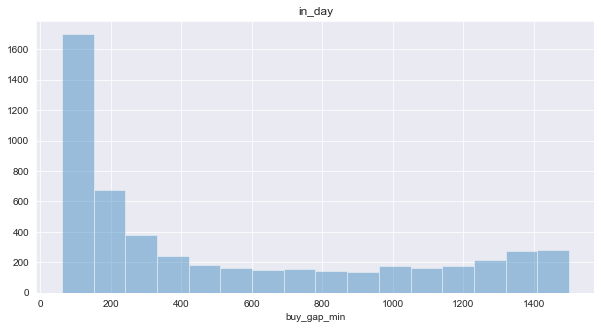

In [296]:
for i in orders_full['len_group'].unique().tolist():
    plt.figure(figsize=(10,5))
    plt.title(i)
    sns.distplot(orders_full[orders_full['len_group']==i]['buy_gap_min'], kde=False)
    plt.show()

#### for each time period we can see different distribution picture and it is needed a deeper investigation:

In [297]:
orders_full['buy_gap_min'].describe()

count     47389.000000
mean      54562.936947
std      102471.166405
min           1.000000
25%           8.000000
50%         348.000000
75%       59449.000000
max      524669.000000
Name: buy_gap_min, dtype: float64

#### interesting point at 8 minutes 

In [298]:
orders_full['len_group'].unique().tolist()

['in_hour', 'in_week', 'in_month', 'in_year', 'in_day']

In [299]:
orders_full[orders_full['len_group']=='in_hour']['buy_gap_min'].describe()

count    20885.000000
mean        11.152310
std         12.294117
min          1.000000
25%          3.000000
50%          7.000000
75%         15.000000
max         60.000000
Name: buy_gap_min, dtype: float64

C:\Users\Yuri\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


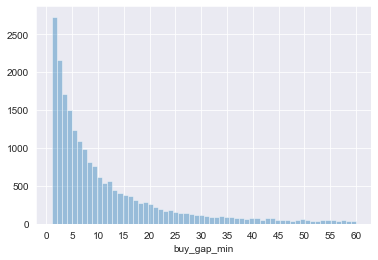

In [300]:
g = sns.distplot(orders_full[orders_full['len_group']=='in_hour']['buy_gap_min'], kde=False, bins=60)
g.set_xticks(range(0,61,5))
plt.show()

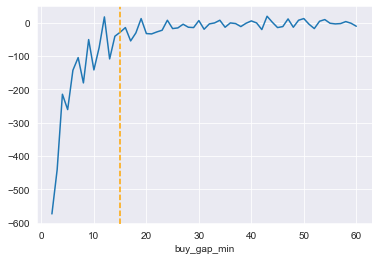

In [301]:
orders_full[orders_full['len_group']=='in_hour'].groupby('buy_gap_min')['buy_gap_min'].count().diff().plot()

plt.axvline(15
            ,color = 'orange'
           , linestyle='--'
           ,label='Start of consolidation')

#### as I can see: there is no peak at 8 min, but it 7-8 min is important point, because In general 25% of visitors buy at that time, and 50% of "buyers of the first hour" do the same.

15 min is the point, when for the "hourly" buyers it is about the same

#### for the better representation I've converted min to h

In [302]:
orders_full['buy_gap_h'] = (orders_full['buy_gap_min']/60).round()

In [303]:
orders_full[orders_full['len_group']=='in_day']['buy_gap_h'].describe()

count    5209.000000
mean        8.754463
std         7.995906
min         1.000000
25%         2.000000
50%         5.000000
75%        16.000000
max        25.000000
Name: buy_gap_h, dtype: float64

C:\Users\Yuri\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


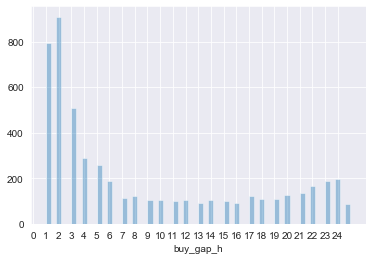

In [304]:
g = sns.distplot(orders_full[orders_full['len_group']=='in_day']['buy_gap_h'], kde=False, bins=60)
g.set_xticks(range(0,25,1))
plt.show()

In [305]:
orders_full[orders_full['len_group']=='in_day'].groupby('buy_gap_h')['buy_gap_h'].count().diff()

buy_gap_h
1.0       NaN
2.0     117.0
3.0    -401.0
4.0    -220.0
5.0     -31.0
6.0     -71.0
7.0     -72.0
8.0      10.0
9.0     -18.0
10.0     -3.0
11.0     -4.0
12.0      5.0
13.0    -11.0
14.0     10.0
15.0     -5.0
16.0     -7.0
17.0     30.0
18.0    -13.0
19.0      1.0
20.0     19.0
21.0      7.0
22.0     30.0
23.0     22.0
24.0      9.0
25.0   -111.0
Name: buy_gap_h, dtype: float64

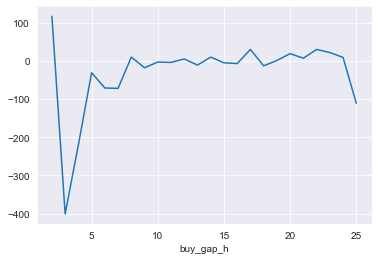

In [306]:
orders_full[orders_full['len_group']=='in_day'].groupby('buy_gap_h')['buy_gap_h'].count().diff().plot()


#### For the "daily buyers" half of buyers do I it in the first 5 hours and there is an interesting peak exactly around 24 hours (22-24)

C:\Users\Yuri\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


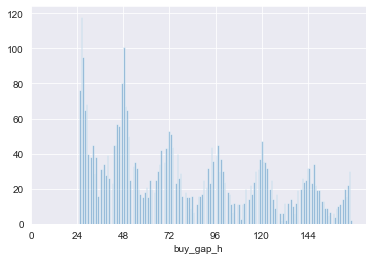

In [307]:
g = sns.distplot(orders_full[orders_full['len_group']=='in_week']['buy_gap_h'], kde=False, bins=168)
g.set_xticks(range(0,168,24))
plt.show()

In [308]:
orders_full[orders_full['len_group']=='in_week']['buy_gap_h'].describe()

count    3880.000000
mean       78.877835
std        40.820920
min        25.000000
25%        45.000000
50%        71.000000
75%       114.000000
max       167.000000
Name: buy_gap_h, dtype: float64

#### For the "weekly buyers" 25% of buyers do I it in the first 2 days and we can see peaks exactly every 24 hours

In [309]:
orders_full['buy_gap_d'] = (orders_full['buy_gap_h']/24).round()

In [310]:
orders_full[orders_full['len_group']=='in_month']['buy_gap_d'].describe()

count    4494.000000
mean       17.063195
std         7.083491
min         7.000000
25%        11.000000
50%        16.000000
75%        23.000000
max        31.000000
Name: buy_gap_d, dtype: float64

C:\Users\Yuri\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


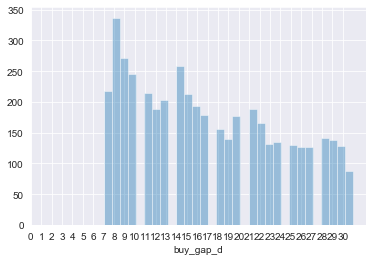

In [311]:
g = sns.distplot(orders_full[orders_full['len_group']=='in_month']['buy_gap_d'], kde=False, bins=31)
g.set_xticks(range(0,31,1))
plt.show()

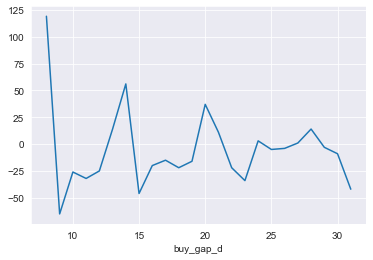

In [312]:
orders_full[orders_full['len_group']=='in_month'].groupby('buy_gap_d')['buy_gap_d'].count().diff().plot()

#### For the "monthly buyers" we can see peaks at the end of the second and the third week

C:\Users\Yuri\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


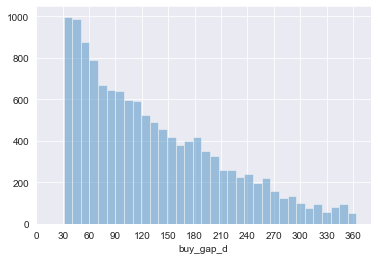

In [313]:
g = sns.distplot(orders_full[orders_full['len_group']=='in_year']['buy_gap_d'], kde=False
                 #, bins=365
                )
g.set_xticks(range(0,365,30))
plt.show()

In [314]:
orders_full['buy_gap_m'] = (orders_full['buy_gap_d']/30).round()

C:\Users\Yuri\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

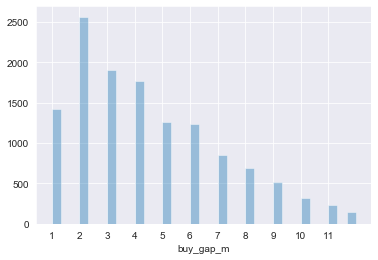

In [315]:
g = sns.distplot(orders_full[orders_full['len_group']=='in_year']['buy_gap_m'], kde=False
                 #, bins=12
                )
g.set_xticks(range(0,12,1))
plt.plot()

In [316]:
orders_full[orders_full['len_group']=='in_year']['buy_gap_m'].value_counts()

2.0     2563
3.0     1909
4.0     1773
1.0     1420
5.0     1254
6.0     1241
7.0      856
8.0      696
9.0      514
10.0     314
11.0     233
12.0     148
Name: buy_gap_m, dtype: int64

In [317]:
orders_full[orders_full['len_group']=='in_year']['buy_gap_d'].value_counts()

36.0     124
49.0     124
43.0     117
33.0     117
34.0     115
        ... 
361.0      2
337.0      2
359.0      2
362.0      1
360.0      1
Name: buy_gap_d, Length: 334, dtype: int64

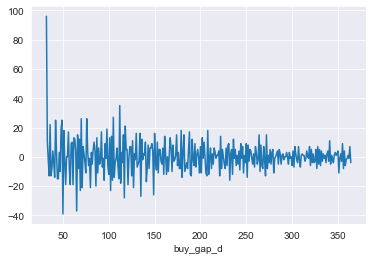

In [318]:
orders_full[orders_full['len_group']=='in_year'].groupby('buy_gap_d')['buy_gap_d'].count().diff().plot()

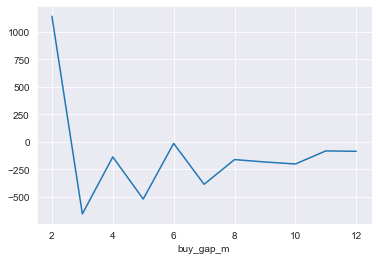

In [319]:
orders_full[orders_full['len_group']=='in_year'].groupby('buy_gap_m')['buy_gap_m'].count().diff().plot()

In [320]:
orders_full[orders_full['len_group']=='in_year'].groupby('buy_gap_m')['buy_gap_m'].count().diff()

buy_gap_m
1.0        NaN
2.0     1143.0
3.0     -654.0
4.0     -136.0
5.0     -519.0
6.0      -13.0
7.0     -385.0
8.0     -160.0
9.0     -182.0
10.0    -200.0
11.0     -81.0
12.0     -85.0
Name: buy_gap_m, dtype: float64

In [321]:
orders_full[orders_full['len_group']=='in_year'].groupby('buy_gap_d')['buy_gap_d'].count().diff()

buy_gap_d
31.0      NaN
32.0     96.0
33.0     11.0
34.0     -2.0
35.0    -13.0
         ... 
360.0    -1.0
361.0     1.0
362.0    -1.0
363.0     7.0
364.0    -4.0
Name: buy_gap_d, Length: 334, dtype: float64

In [322]:
orders_full[orders_full['len_group']=='in_year']['buy_gap_d'].describe()

count    12921.000000
mean       131.876171
std         79.500590
min         31.000000
25%         65.000000
50%        114.000000
75%        183.000000
max        364.000000
Name: buy_gap_d, dtype: float64

In [323]:
orders_full[orders_full['len_group']=='in_year']['buy_gap_m'].describe()

count    12921.000000
mean         4.391765
std          2.683785
min          1.000000
25%          2.000000
50%          4.000000
75%          6.000000
max         12.000000
Name: buy_gap_m, dtype: float64

#### For the "yearly buyers" we can see interesting peak around 2nd month and 25% of buers do it on this period, also few positive gaps on the 6 month  and at the end of the year. This little peak could be well recognised before rounding.

## Marketing

### How much money was spent? Overall/per source/over time

In [324]:
costs.head()

source_id         dt  costs
0          1 2017-06-01  75.20
1          1 2017-06-02  62.25
2          1 2017-06-03  36.53
3          1 2017-06-04  55.00
4          1 2017-06-05  57.08

In [325]:
costs['cost_week'] = costs['dt'] - pd.to_timedelta(costs['dt'].dt.dayofweek, unit='d')

In [326]:
costs['cost_month'] = costs['dt'].astype('datetime64[M]')

In [327]:
costs.groupby('cost_month')['costs'].sum()

cost_month
2017-06-01    18015.00
2017-07-01    18240.59
2017-08-01    14790.54
2017-09-01    24368.91
2017-10-01    36322.88
2017-11-01    37907.88
2017-12-01    38315.35
2018-01-01    33518.52
2018-02-01    32723.03
2018-03-01    30415.27
2018-04-01    22289.38
2018-05-01    22224.27
Name: costs, dtype: float64

In [328]:
costs.groupby('cost_month')['costs'].sum().mean()

27427.634999999995

Text(0.5, 1.0, 'Costs per month')

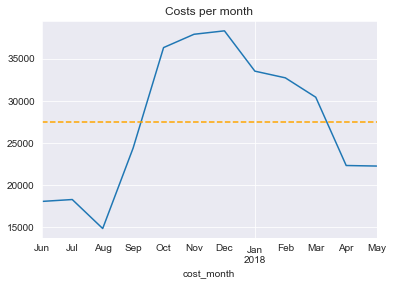

In [329]:
costs.groupby('cost_month')['costs'].sum().plot()

plt.axhline(costs.groupby('cost_month')['costs'].sum().mean()
           ,color = 'orange'
           , linestyle='--'
           )

plt.title('Costs per month')

Text(0.5, 1.0, 'Costs per month')

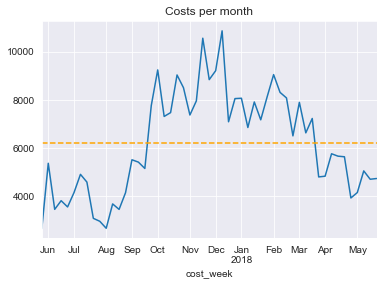

In [330]:
costs.groupby('cost_week')['costs'].sum().plot()

plt.axhline(costs.groupby('cost_week')['costs'].sum().mean()
           ,color = 'orange'
           , linestyle='--'
           )

plt.title('Costs per month')

In [331]:
costs.groupby('source_id')['costs'].sum().sort_values(ascending=False)

source_id
3     141321.63
4      61073.60
5      51757.10
2      42806.04
1      20833.27
10      5822.49
9       5517.49
Name: costs, dtype: float64

Text(0.5, 1.0, 'Investments by source')

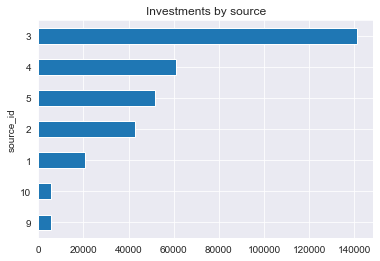

In [332]:
costs.groupby('source_id')['costs'].sum().sort_values().plot(kind='barh')

plt.title("Investments by source")

In [333]:
costs.groupby('source_id')['costs'].sum() / costs['costs'].sum()

source_id
1     0.063298
2     0.130058
3     0.429377
4     0.185560
5     0.157254
9     0.016764
10    0.017690
Name: costs, dtype: float64

In [334]:
costs['costs'].sum()

329131.62

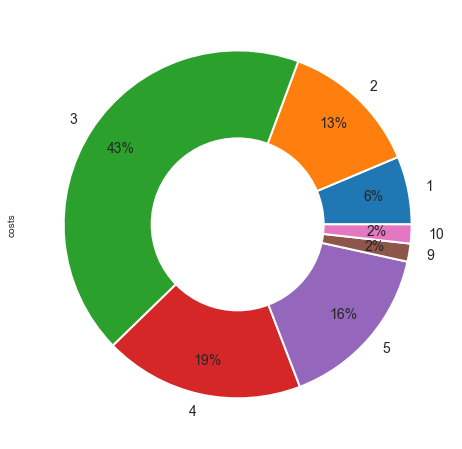

In [335]:
plt.figure(figsize=(8,8))

(costs.groupby('source_id')['costs'].sum() / costs['costs'].sum()).plot.pie(
        autopct='%1.0f%%'
        ,pctdistance=0.8
        ,textprops={'fontsize': 14}
 
       ,wedgeprops = {'linewidth': 2})

centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)

fig = plt.gcf()
fig.gca().add_artist(centre_circle)

### the source N3 is the most expensive, after it sources N4, N5 and N2

In [336]:
costs.pivot_table(index='source_id', columns='cost_month', values='costs',aggfunc='sum')

cost_month  2017-06-01  2017-07-01  2017-08-01  2017-09-01  2017-10-01  \
source_id                                                                
1              1125.61     1072.88      951.81     1502.01     2315.75   
2              2427.38     2333.11     1811.05     2985.66     4845.00   
3              7731.65     7674.37     6143.54     9963.55    15737.24   
4              3514.80     3529.73     3217.36     5192.26     6420.84   
5              2616.12     2998.14     2185.28     3849.14     5767.40   
9               285.22      302.54      248.93      415.62      609.41   
10              314.22      329.82      232.57      460.67      627.24   

cost_month  2017-11-01  2017-12-01  2018-01-01  2018-02-01  2018-03-01  \
source_id                                                                
1              2445.16     2341.20     2186.18     2204.48     1893.09   
2              5247.68     4897.80     4157.74     4474.34     3943.14   
3             17025.34    16219.52    14808.78    14228.56    13080.85   
4              5388.82     7680.47     5832.79     5711.96     5961.87   
5              6325.34     5872.52     5371.52     5071.31     4529.62   
9               683.18      657.98      547.16      551.50      480.29   
10              792.36      645.86      614.35      480.88      526.41   

cost_month  2018-04-01  2018-05-01  
source_id                           
1              1327.49     1467.61  
2              2993.70     2689.44  
3              9296.81     9411.42  
4              4408.49     4214.21  
5              3501.15     3669.56  
9               373.49      362.17  
10              388.25      409.86

In [337]:
costs_pivot = costs.pivot_table(index='source_id', columns='cost_month', values='costs',aggfunc='sum')

In [338]:
costs_pivot.columns = costs_pivot.columns.strftime("%Y-%m")

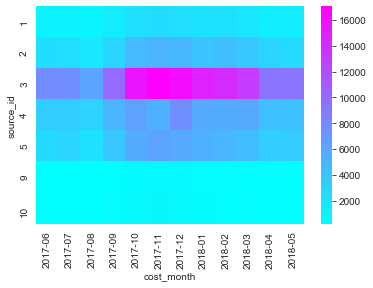

In [339]:
sns.heatmap(costs_pivot, cmap='cool')

#### the source 3 has about 45% of the whole budget abd it is most expensive. In addition to that that it has its own peak from Oct 2017 till Mar 2018.

In [340]:
costs.groupby(['source_id','cost_month'])['costs'].sum().reset_index().sort_values(by='costs',ascending=False)

source_id cost_month     costs
29          3 2017-11-01  17025.34
30          3 2017-12-01  16219.52
28          3 2017-10-01  15737.24
31          3 2018-01-01  14808.78
32          3 2018-02-01  14228.56
..        ...        ...       ...
72         10 2017-06-01    314.22
61          9 2017-07-01    302.54
60          9 2017-06-01    285.22
62          9 2017-08-01    248.93
74         10 2017-08-01    232.57

[84 rows x 3 columns]

In [341]:
costs.groupby(['source_id','cost_month'])['costs'].sum().reset_index().sort_values(by='costs',ascending=False).head(10)

source_id cost_month     costs
29          3 2017-11-01  17025.34
30          3 2017-12-01  16219.52
28          3 2017-10-01  15737.24
31          3 2018-01-01  14808.78
32          3 2018-02-01  14228.56
33          3 2018-03-01  13080.85
27          3 2017-09-01   9963.55
35          3 2018-05-01   9411.42
34          3 2018-04-01   9296.81
24          3 2017-06-01   7731.65

In [342]:
import squarify

In [343]:
monthly_costs = costs.groupby(['source_id','cost_month'])['costs'].sum().reset_index().sort_values(by='costs',ascending=False)

In [344]:
monthly_costs.head()

source_id cost_month     costs
29          3 2017-11-01  17025.34
30          3 2017-12-01  16219.52
28          3 2017-10-01  15737.24
31          3 2018-01-01  14808.78
32          3 2018-02-01  14228.56

In [345]:
costs_pivot.max()

cost_month
2017-06     7731.65
2017-07     7674.37
2017-08     6143.54
2017-09     9963.55
2017-10    15737.24
2017-11    17025.34
2017-12    16219.52
2018-01    14808.78
2018-02    14228.56
2018-03    13080.85
2018-04     9296.81
2018-05     9411.42
dtype: float64

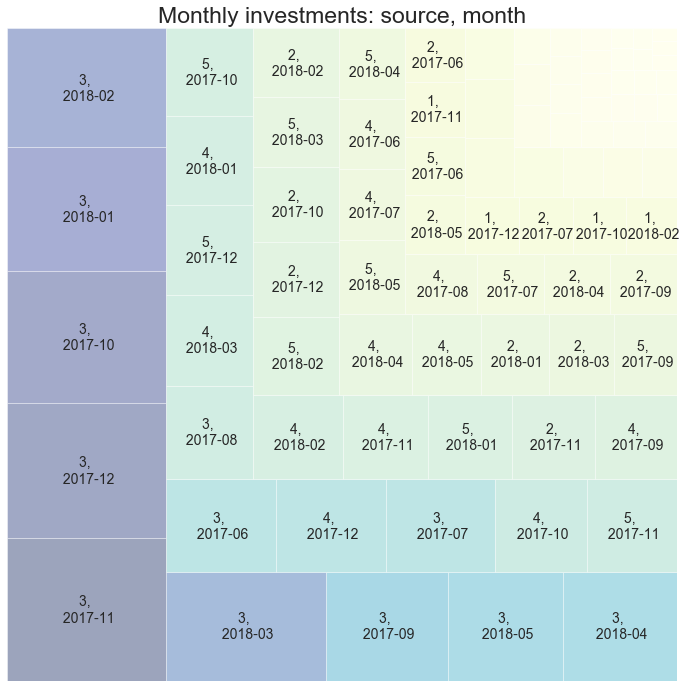

In [346]:
plt.figure(figsize=(12,12))


labels = monthly_costs['source_id'][:50]
labels2 = monthly_costs['cost_month']
sizes = monthly_costs['costs']


lbl = [str(i)+', \n '+j.strftime("%Y-%m") for i,j in zip(labels, labels2)]

cmap = matplotlib.cm.YlGnBu
mini=min(sizes)
maxi=max(sizes)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)

colors = [cmap(norm(value)) for value in sizes]


squarify.plot(sizes=sizes
              , label=lbl
              #, label=labels
             , alpha=0.4
              ,color=colors
              , text_kwargs={'fontsize':14}
             #, pad=True
             )
plt.axis('off')

plt.title('Monthly investments: source, month',fontsize=23
          #,fontweight="bold"
         )
plt.show()

### How much did customer acquisition from each of the sources cost?

In [347]:
costs['costs'].sum()

329131.62

In [348]:
visits['uid'].nunique()

207051

In [349]:
costs['costs'].sum() / visits['uid'].nunique()

1.589616181520495

#### on average generally CAC of 1 visitor is about 1.6

In [350]:
visits.groupby('first_visit_month')['uid'].nunique()

first_visit_month
2017-06-01    11885
2017-07-01    11825
2017-08-01     9214
2017-09-01    15125
2017-10-01    23538
2017-11-01    24852
2017-12-01    23030
2018-01-01    20573
2018-02-01    20173
2018-03-01    18793
2018-04-01    14215
2018-05-01    13828
Name: uid, dtype: int64

In [351]:
costs.groupby('cost_month')['costs'].sum()

cost_month
2017-06-01    18015.00
2017-07-01    18240.59
2017-08-01    14790.54
2017-09-01    24368.91
2017-10-01    36322.88
2017-11-01    37907.88
2017-12-01    38315.35
2018-01-01    33518.52
2018-02-01    32723.03
2018-03-01    30415.27
2018-04-01    22289.38
2018-05-01    22224.27
Name: costs, dtype: float64

In [352]:
costs.groupby('cost_month')['costs'].sum() / visits.groupby('first_visit_month')['uid'].nunique()

cost_month
2017-06-01    1.515776
2017-07-01    1.542545
2017-08-01    1.605225
2017-09-01    1.611168
2017-10-01    1.543159
2017-11-01    1.525345
2017-12-01    1.663715
2018-01-01    1.629248
2018-02-01    1.622120
2018-03-01    1.618436
2018-04-01    1.568018
2018-05-01    1.607193
dtype: float64

In [353]:
(costs.groupby('cost_month')['costs'].sum() / visits.groupby('first_visit_month')['uid'].nunique()).mean()

1.5876623466470683

Text(0.5, 1.0, 'Monthly cost of user acquisition')

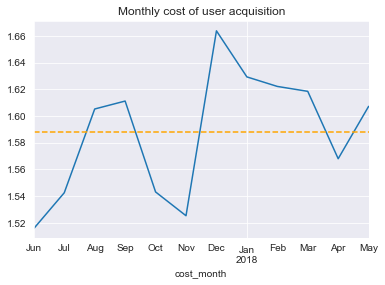

In [354]:
(costs.groupby('cost_month')['costs'].sum() / visits.groupby('first_visit_month')['uid'].nunique()).plot()

plt.axhline((costs.groupby('cost_month')['costs'].sum() / visits.groupby('first_visit_month')['uid'].nunique()).mean()
            ,color = 'orange'
           , linestyle='--'
            )

plt.title('Monthly cost of user acquisition')

In [355]:
(costs.groupby('cost_week')['costs'].sum() / visits.groupby('first_visit_week')['uid'].nunique()).mean()

1.5902642361864194

Text(0.5, 1.0, 'Weekly cost of user acquisition')

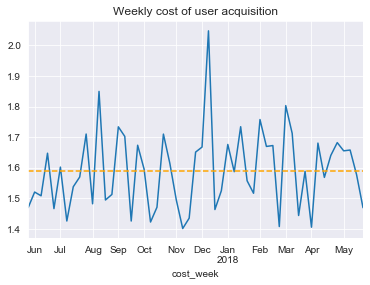

In [356]:
(costs.groupby('cost_week')['costs'].sum() / visits.groupby('first_visit_week')['uid'].nunique()).plot()


plt.axhline(
    (costs.groupby('cost_week')['costs'].sum() / visits.groupby('first_visit_week')['uid'].nunique()).mean()
            ,color = 'orange'
           , linestyle='--'
            )

plt.title('Weekly cost of user acquisition')

Text(0.5, 1.0, 'CAC')

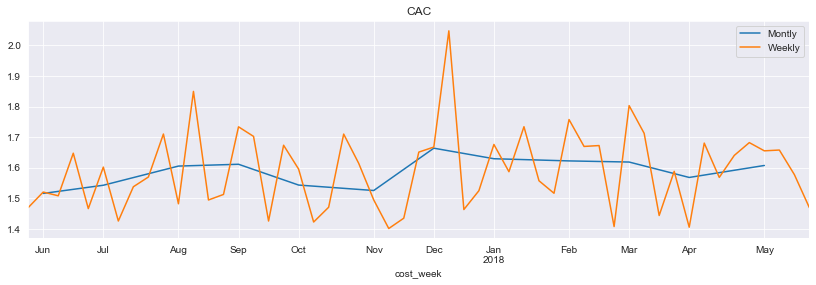

In [357]:
plt.figure(figsize=(14,4))

(costs.groupby('cost_month')['costs'].sum() / visits.groupby('first_visit_month')['uid'].nunique()).plot(label='Montly')
plt.margins(x=0)

(costs.groupby('cost_week')['costs'].sum() / visits.groupby('first_visit_week')['uid'].nunique()).plot(label='Weekly')

#plt.tight_layout()

plt.legend()

plt.title("CAC")

In [358]:
visits.groupby('source_id')['uid'].nunique()

source_id
1     17960
2     24152
3     67284
4     75080
5     50921
6         5
7        33
9      8504
10     7208
Name: uid, dtype: int64

In [359]:
costs.groupby('source_id')['costs'].sum()

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

In [360]:
(costs.groupby('source_id')['costs'].sum() / visits.groupby('source_id')['uid'].nunique()).sort_values(ascending=False)

source_id
3     2.100375
2     1.772360
1     1.159982
5     1.016420
4     0.813447
10    0.807782
9     0.648811
6          NaN
7          NaN
dtype: float64

In [361]:
(costs.groupby('source_id')['costs'].sum() / visits.groupby('source_id')['uid'].nunique()).mean()

1.1884537110696198

#### we have very few visitors from sources 6 and 7, but we didn't invested in these sources

#### average CAC by source is 1.2, but variation here is very high 

Text(0.5, 1.0, 'Cost of user acquisition by source')

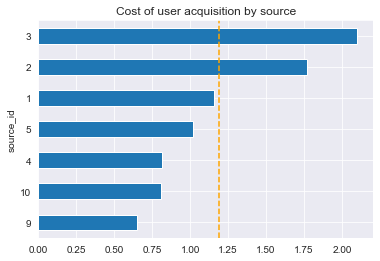

In [362]:
((costs.groupby('source_id')['costs'].sum() / visits.groupby('source_id')['uid'].nunique()).dropna().sort_values()).plot(kind='barh')


plt.axvline(
    (costs.groupby('source_id')['costs'].sum() / visits.groupby('source_id')['uid'].nunique()).mean()
  ,color = 'orange'
           , linestyle='--'
)

plt.title('Cost of user acquisition by source')

#### sources 3 and 2 are the most expensive

In [363]:
visits.pivot_table(index='source_id', columns='first_visit_month', values='uid',aggfunc='nunique')

first_visit_month  2017-06-01  2017-07-01  2017-08-01  2017-09-01  2017-10-01  \
source_id                                                                       
1                      1372.0      1210.0       847.0      1441.0      2091.0   
2                      1956.0      1794.0      1138.0      1958.0      2892.0   
3                      4577.0      4069.0      3215.0      5371.0      7646.0   
4                      4066.0      4162.0      3083.0      5112.0      8498.0   
5                      3164.0      3516.0      2892.0      4532.0      6732.0   
6                         1.0         1.0         NaN         NaN         NaN   
7                         2.0         2.0         2.0         2.0         6.0   
9                       933.0       658.0       567.0       751.0       955.0   
10                      487.0       362.0       259.0       503.0       869.0   

first_visit_month  2017-11-01  2017-12-01  2018-01-01  2018-02-01  2018-03-01  \
source_id                                                                       
1                      2396.0      2011.0      1564.0      1485.0      1442.0   
2                      3185.0      2413.0      2006.0      1942.0      1888.0   
3                      8652.0      7476.0      6658.0      6598.0      5587.0   
4                      9254.0      9148.0      7743.0      7099.0      7013.0   
5                      5697.0      5025.0      4700.0      4574.0      3541.0   
6                         1.0         1.0         1.0         NaN         NaN   
7                         1.0         9.0         4.0         1.0         1.0   
9                      1146.0       844.0       628.0       552.0       873.0   
10                      755.0       512.0       745.0       828.0       886.0   

first_visit_month  2018-04-01  2018-05-01  
source_id                                  
1                      1063.0      1038.0  
2                      1337.0      1643.0  
3                      3850.0      3585.0  
4                      5022.0      4880.0  
5                      3711.0      2837.0  
6                         NaN         NaN  
7                         1.0         2.0  
9                       293.0       304.0  
10                      433.0       569.0

In [364]:
costs.pivot_table(index='source_id', columns = 'cost_month', values='costs', aggfunc='sum')

cost_month  2017-06-01  2017-07-01  2017-08-01  2017-09-01  2017-10-01  \
source_id                                                                
1              1125.61     1072.88      951.81     1502.01     2315.75   
2              2427.38     2333.11     1811.05     2985.66     4845.00   
3              7731.65     7674.37     6143.54     9963.55    15737.24   
4              3514.80     3529.73     3217.36     5192.26     6420.84   
5              2616.12     2998.14     2185.28     3849.14     5767.40   
9               285.22      302.54      248.93      415.62      609.41   
10              314.22      329.82      232.57      460.67      627.24   

cost_month  2017-11-01  2017-12-01  2018-01-01  2018-02-01  2018-03-01  \
source_id                                                                
1              2445.16     2341.20     2186.18     2204.48     1893.09   
2              5247.68     4897.80     4157.74     4474.34     3943.14   
3             17025.34    16219.52    14808.78    14228.56    13080.85   
4              5388.82     7680.47     5832.79     5711.96     5961.87   
5              6325.34     5872.52     5371.52     5071.31     4529.62   
9               683.18      657.98      547.16      551.50      480.29   
10              792.36      645.86      614.35      480.88      526.41   

cost_month  2018-04-01  2018-05-01  
source_id                           
1              1327.49     1467.61  
2              2993.70     2689.44  
3              9296.81     9411.42  
4              4408.49     4214.21  
5              3501.15     3669.56  
9               373.49      362.17  
10              388.25      409.86

In [365]:
costs.pivot_table(index='source_id', columns = 'cost_month', values='costs', aggfunc='sum') \
/ visits.pivot_table(index='source_id', columns='first_visit_month', values='uid',aggfunc='nunique')

cost_month  2017-06-01  2017-07-01  2017-08-01  2017-09-01  2017-10-01  \
source_id                                                                
1             0.820415    0.886678    1.123743    1.042339    1.107484   
2             1.240992    1.300507    1.591432    1.524852    1.675311   
3             1.689240    1.886058    1.910899    1.855064    2.058232   
4             0.864437    0.848085    1.043581    1.015700    0.755571   
5             0.826839    0.852713    0.755629    0.849325    0.856714   
6                  NaN         NaN         NaN         NaN         NaN   
7                  NaN         NaN         NaN         NaN         NaN   
9             0.305702    0.459787    0.439030    0.553422    0.638126   
10            0.645216    0.911105    0.897954    0.915845    0.721795   

cost_month  2017-11-01  2017-12-01  2018-01-01  2018-02-01  2018-03-01  \
source_id                                                                
1             1.020518    1.164197    1.397813    1.484498    1.312822   
2             1.647623    2.029755    2.072652    2.303986    2.088528   
3             1.967792    2.169545    2.224208    2.156496    2.341301   
4             0.582323    0.839579    0.753298    0.804615    0.850117   
5             1.110293    1.168661    1.142877    1.108725    1.279192   
6                  NaN         NaN         NaN         NaN         NaN   
7                  NaN         NaN         NaN         NaN         NaN   
9             0.596143    0.779597    0.871274    0.999094    0.550160   
10            1.049483    1.261445    0.824631    0.580773    0.594142   

cost_month  2018-04-01  2018-05-01  
source_id                           
1             1.248815    1.413882  
2             2.239117    1.636908  
3             2.414756    2.625222  
4             0.877836    0.863568  
5             0.943452    1.293465  
6                  NaN         NaN  
7                  NaN         NaN  
9             1.274710    1.191349  
10            0.896651    0.720316

In [366]:
(costs.pivot_table(index='source_id', columns = 'cost_month', values='costs', aggfunc='sum') \
/ visits.pivot_table(index='source_id', columns='first_visit_month', values='uid',aggfunc='nunique')).dropna()

cost_month  2017-06-01  2017-07-01  2017-08-01  2017-09-01  2017-10-01  \
source_id                                                                
1             0.820415    0.886678    1.123743    1.042339    1.107484   
2             1.240992    1.300507    1.591432    1.524852    1.675311   
3             1.689240    1.886058    1.910899    1.855064    2.058232   
4             0.864437    0.848085    1.043581    1.015700    0.755571   
5             0.826839    0.852713    0.755629    0.849325    0.856714   
9             0.305702    0.459787    0.439030    0.553422    0.638126   
10            0.645216    0.911105    0.897954    0.915845    0.721795   

cost_month  2017-11-01  2017-12-01  2018-01-01  2018-02-01  2018-03-01  \
source_id                                                                
1             1.020518    1.164197    1.397813    1.484498    1.312822   
2             1.647623    2.029755    2.072652    2.303986    2.088528   
3             1.967792    2.169545    2.224208    2.156496    2.341301   
4             0.582323    0.839579    0.753298    0.804615    0.850117   
5             1.110293    1.168661    1.142877    1.108725    1.279192   
9             0.596143    0.779597    0.871274    0.999094    0.550160   
10            1.049483    1.261445    0.824631    0.580773    0.594142   

cost_month  2018-04-01  2018-05-01  
source_id                           
1             1.248815    1.413882  
2             2.239117    1.636908  
3             2.414756    2.625222  
4             0.877836    0.863568  
5             0.943452    1.293465  
9             1.274710    1.191349  
10            0.896651    0.720316

In [367]:
cac_matrix = (costs.pivot_table(index='source_id', columns = 'cost_month', values='costs', aggfunc='sum') \
/ visits.pivot_table(index='source_id', columns='first_visit_month', values='uid',aggfunc='nunique')).dropna()

In [368]:
cac_matrix.columns = cac_matrix.columns.strftime("%Y-%m")

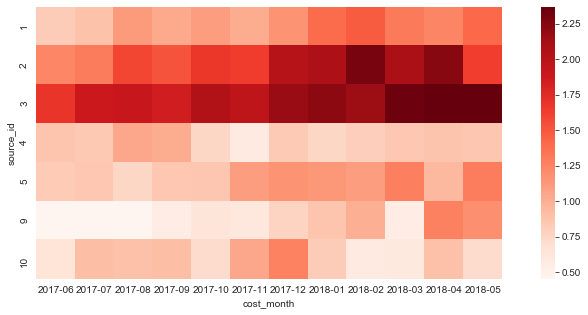

In [369]:
plt.figure(figsize=(14,5))
sns.heatmap(cac_matrix
           ,cmap='Reds'
            , robust=True #colors
             ,square=True #size
           )

In [370]:
cac_matrix.unstack().reset_index()

cost_month  source_id         0
0     2017-06          1  0.820415
1     2017-06          2  1.240992
2     2017-06          3  1.689240
3     2017-06          4  0.864437
4     2017-06          5  0.826839
..        ...        ...       ...
79    2018-05          3  2.625222
80    2018-05          4  0.863568
81    2018-05          5  1.293465
82    2018-05          9  1.191349
83    2018-05         10  0.720316

[84 rows x 3 columns]

In [371]:
cac_monthly = cac_matrix.unstack().reset_index()

In [372]:
cac_monthly.columns = ['cost_month','source_id','cac']

In [373]:
cac_monthly = cac_monthly.sort_values(by='cac',ascending=False)

In [374]:
cac_monthly.head()

cost_month  source_id       cac
79    2018-05          3  2.625222
72    2018-04          3  2.414756
65    2018-03          3  2.341301
57    2018-02          2  2.303986
71    2018-04          2  2.239117

In [375]:
cac_monthly['cac'].mean()

1.2099765301670617

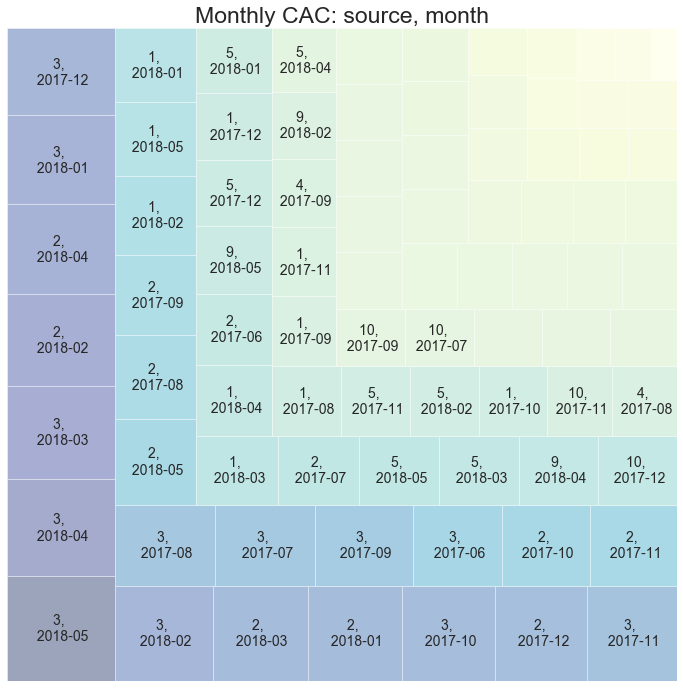

In [376]:
plt.figure(figsize=(12,12))


labels = cac_monthly['source_id'][:50]
labels2 = cac_monthly['cost_month']
sizes = cac_monthly['cac']


lbl = [str(i)+', \n '+j for i,j in zip(labels, labels2)]

cmap = matplotlib.cm.YlGnBu
mini=min(sizes)
maxi=max(sizes)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)

colors = [cmap(norm(value)) for value in sizes]


squarify.plot(sizes=sizes
              , label=lbl
              #, label=labels
             , alpha=0.4
              ,color=colors
              , text_kwargs={'fontsize':14}
             #, pad=True
             )
plt.axis('off')

plt.title('Monthly CAC: source, month',fontsize=23
          #,fontweight="bold"
         )
plt.show()

### How worthwhile where the investments? ROI

#### ROI in general

In [377]:
orders['revenue'].sum()

252053.77999999997

In [378]:
costs['costs'].sum()

329131.62

In [379]:
orders['revenue'].sum() / costs['costs'].sum()

0.7658145394842342

#### in general we have ROI about 77%, that means that our product is still not profitable

#### ROI by month

In [380]:
orders_full.groupby('order_month')['revenue'].sum() / costs.groupby('cost_month')['costs'].sum()

order_month
2017-06-01    0.489456
2017-07-01    0.640207
2017-08-01    0.549750
2017-09-01    0.708095
2017-10-01    0.730667
2017-11-01    0.686657
2017-12-01    0.918877
2018-01-01    0.554310
2018-02-01    0.750911
2018-03-01    0.905835
2018-04-01    0.729449
2018-05-01    0.884002
dtype: float64

In [381]:
(orders_full.groupby('order_month')['revenue'].sum() / costs.groupby('cost_month')['costs'].sum()).mean()

0.7123513879129618

Text(0.5, 1.0, 'Montly ROI')

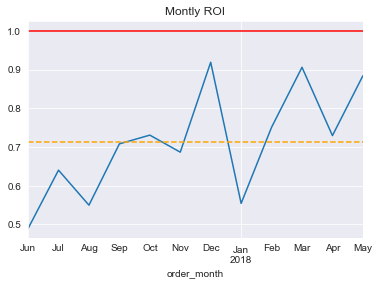

In [382]:
(orders_full.groupby('order_month')['revenue'].sum() / costs.groupby('cost_month')['costs'].sum()).plot()

plt.axhline((orders_full.groupby('order_month')['revenue'].sum() / costs.groupby('cost_month')['costs'].sum()).mean()
            ,color = 'orange'
           , linestyle='--'
           )

plt.axhline(1
            ,color = 'red'
           , linestyle='-'
           )

plt.title('Montly ROI')

#### the lack of profitability is constant: no profitable months

#### ROI by source

In [383]:
orders_full.groupby('source_id')['revenue'].sum() / costs.groupby('source_id')['costs'].sum()

source_id
1     1.394417
2     1.070784
3     0.358816
4     0.879165
5     0.986468
7          NaN
9     1.003025
10    0.753320
dtype: float64

In [384]:
(orders_full.groupby('source_id')['revenue'].sum() / costs.groupby('source_id')['costs'].sum()).mean()

0.92085649608236

Text(0.5, 1.0, 'ROI by Source_ID')

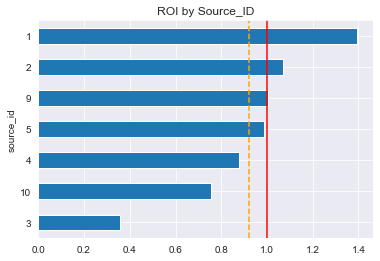

In [385]:
(
    (orders_full.groupby('source_id')['revenue'].sum() / costs.groupby('source_id')['costs'].sum()).dropna().sort_values()
).plot(kind='barh')

plt.axvline(
    (orders_full.groupby('source_id')['revenue'].sum() / costs.groupby('source_id')['costs'].sum()).mean()
            ,color = 'orange'
           , linestyle='--'
           )

plt.axvline(1
            ,color = 'red'
           , linestyle='-'
           )

plt.title('ROI by Source_ID')

#### from all sources the 1 and 2 are recoupment, the 9 and 5 are close to it.

#### ROI by monthly cohort

In [386]:
orders_full.groupby('first_order_month')['revenue'].sum() / costs.groupby('cost_month')['costs'].sum()

first_order_month
2017-06-01    1.292909
2017-07-01    0.836066
2017-08-01    0.742105
2017-09-01    1.377943
2017-10-01    0.718474
2017-11-01    0.662377
2017-12-01    0.842940
2018-01-01    0.472697
2018-02-01    0.479579
2018-03-01    0.591923
2018-04-01    0.503189
2018-05-01    0.580856
dtype: float64

In [387]:
monthly_cohort_roi= orders_full.groupby('first_order_month')['revenue'].sum() / costs.groupby('cost_month')['costs'].sum()

In [388]:
monthly_cohort_roi.mean()

0.7584215530543864

In [389]:
monthly_cohort_roi.index = monthly_cohort_roi.index.strftime("%Y-%m")

Text(0.5, 1.0, 'ROI by monthly cohort')

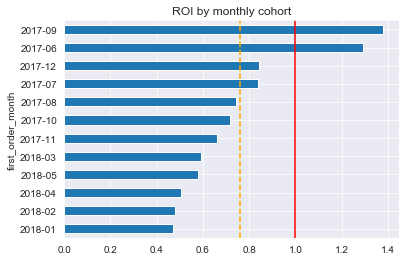

In [390]:
(
    monthly_cohort_roi.sort_values()
).plot(kind='barh')

plt.axvline(
    monthly_cohort_roi.mean()
            ,color = 'orange'
           , linestyle='--'
           )

plt.axvline(1
            ,color = 'red'
           , linestyle='-'
           )

plt.title('ROI by monthly cohort')

#### cohorts from Sep and June 2017 are recoupments 

#### ROI by source and month

In [391]:
orders_full.pivot_table(index='source_id', columns='order_month', values='revenue',aggfunc='sum')

order_month  2017-06-01  2017-07-01  2017-08-01  2017-09-01  2017-10-01  \
source_id                                                                 
1               1192.54     1521.95     1343.57     2754.66     3344.39   
2                940.66     1727.61      872.13     2308.69     4974.64   
3               2635.95     2957.86     1831.48     4180.70     5662.46   
4               1832.98     2730.72     1645.03     2971.49     5789.17   
5               1785.79     2348.16     1862.40     4291.40     5435.18   
7                   NaN         NaN        1.22         NaN         NaN   
9                218.00      209.86      289.93      449.15      780.30   
10               211.63      181.60      285.34      299.41      553.80   

order_month  2017-11-01  2017-12-01  2018-01-01  2018-02-01  2018-03-01  \
source_id                                                                 
1               3417.73     2567.08     2331.22     2152.61     3678.80   
2               4424.45     4518.09     2913.85     6495.10     7797.49   
3               6166.49     5643.30     4482.48     4619.11     4786.07   
4               6828.99     7147.86     4219.44     5490.86     6475.78   
5               3916.52    14346.53     3985.24     4927.87     3511.78   
7                   NaN         NaN         NaN         NaN         NaN   
9                690.24      639.74      365.49      568.16      673.48   
10               585.29      344.49      281.93      318.37      627.82   

order_month  2018-04-01  2018-05-01  
source_id                            
1               2364.62     2381.09  
2               3413.14     5450.19  
3               3203.08     4539.49  
4               4477.19     4084.28  
5               2251.84     2394.00  
7                   NaN         NaN  
9                282.82      367.01  
10               266.28      430.24

In [392]:
costs.pivot_table(index = 'source_id', columns = 'cost_month', values='costs', aggfunc='sum'
                 )

cost_month  2017-06-01  2017-07-01  2017-08-01  2017-09-01  2017-10-01  \
source_id                                                                
1              1125.61     1072.88      951.81     1502.01     2315.75   
2              2427.38     2333.11     1811.05     2985.66     4845.00   
3              7731.65     7674.37     6143.54     9963.55    15737.24   
4              3514.80     3529.73     3217.36     5192.26     6420.84   
5              2616.12     2998.14     2185.28     3849.14     5767.40   
9               285.22      302.54      248.93      415.62      609.41   
10              314.22      329.82      232.57      460.67      627.24   

cost_month  2017-11-01  2017-12-01  2018-01-01  2018-02-01  2018-03-01  \
source_id                                                                
1              2445.16     2341.20     2186.18     2204.48     1893.09   
2              5247.68     4897.80     4157.74     4474.34     3943.14   
3             17025.34    16219.52    14808.78    14228.56    13080.85   
4              5388.82     7680.47     5832.79     5711.96     5961.87   
5              6325.34     5872.52     5371.52     5071.31     4529.62   
9               683.18      657.98      547.16      551.50      480.29   
10              792.36      645.86      614.35      480.88      526.41   

cost_month  2018-04-01  2018-05-01  
source_id                           
1              1327.49     1467.61  
2              2993.70     2689.44  
3              9296.81     9411.42  
4              4408.49     4214.21  
5              3501.15     3669.56  
9               373.49      362.17  
10              388.25      409.86

In [393]:
orders_full.pivot_table(index='source_id', columns='order_month', values='revenue',aggfunc='sum') \
/ costs.pivot_table(index = 'source_id', columns = 'cost_month', values='costs', aggfunc='sum'                 )

order_month  2017-06-01  2017-07-01  2017-08-01  2017-09-01  2017-10-01  \
source_id                                                                 
1              1.059461    1.418565    1.411595    1.833982    1.444193   
2              0.387521    0.740475    0.481560    0.773260    1.026757   
3              0.340930    0.385421    0.298115    0.419599    0.359813   
4              0.521503    0.773634    0.511298    0.572292    0.901622   
5              0.682610    0.783206    0.852248    1.114898    0.942397   
7                   NaN         NaN         NaN         NaN         NaN   
9              0.764322    0.693660    1.164705    1.080675    1.280419   
10             0.673509    0.550603    1.226899    0.649945    0.882916   

order_month  2017-11-01  2017-12-01  2018-01-01  2018-02-01  2018-03-01  \
source_id                                                                 
1              1.397753    1.096480    1.066344    0.976471    1.943278   
2              0.843125    0.922473    0.700825    1.451633    1.977482   
3              0.362195    0.347933    0.302691    0.324637    0.365884   
4              1.267251    0.930654    0.723400    0.961292    1.086199   
5              0.619179    2.442994    0.741920    0.971715    0.775292   
7                   NaN         NaN         NaN         NaN         NaN   
9              1.010334    0.972279    0.667976    1.030209    1.402236   
10             0.738667    0.533382    0.458908    0.662057    1.192645   

order_month  2018-04-01  2018-05-01  
source_id                            
1              1.781271    1.622427  
2              1.140108    2.026515  
3              0.344535    0.482338  
4              1.015584    0.969169  
5              0.643172    0.652394  
7                   NaN         NaN  
9              0.757236    1.013364  
10             0.685847    1.049724

#### source 7 brings a couple buyers "automatically"

In [394]:
m_s_roi_pivot = orders_full.pivot_table(index='source_id', columns='order_month', values='revenue',aggfunc='sum') \
/ costs.pivot_table(index = 'source_id', columns = 'cost_month', values='costs', aggfunc='sum'                 )

In [395]:
m_s_roi_pivot = m_s_roi_pivot.dropna()

In [396]:
m_s_roi_pivot.columns = m_s_roi_pivot.columns.strftime('%Y-%m')

Text(0.5, 1, 'Monthly ROI matrix heatmap')

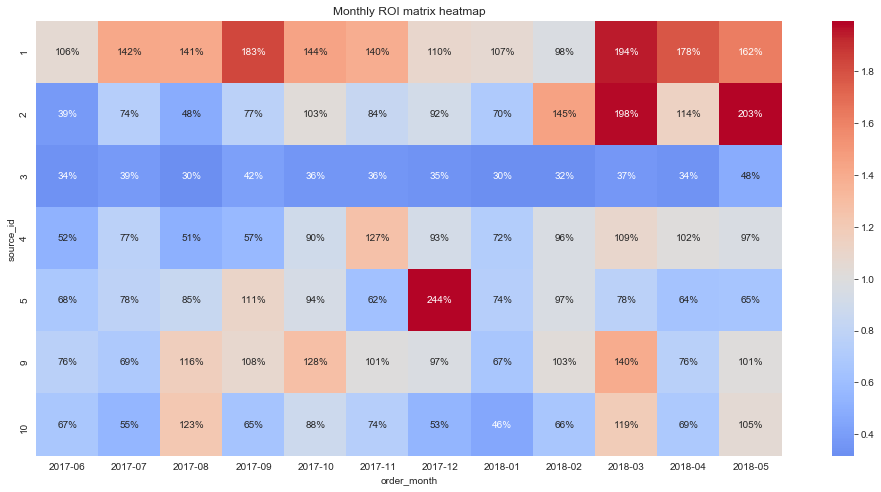

In [397]:
plt.figure(figsize=(18,8))
sns.heatmap(m_s_roi_pivot
           ,cmap='coolwarm'
            , robust=True #colors
             ,square=True #size
            ,center=1
                 ,annot=True
                ,fmt='.0%'
           )

plt.title('Monthly ROI matrix heatmap')

#### source 1 has best constant positive ROI indicators 
#### source 2 has good increase tendency and it is profitable recent periods
#### source 9 is not stable
#### source 5 had one boost month

#### source 3  has constant negative result

In [398]:
m_s_roi_pivot.unstack().reset_index()

order_month  source_id         0
0      2017-06          1  1.059461
1      2017-06          2  0.387521
2      2017-06          3  0.340930
3      2017-06          4  0.521503
4      2017-06          5  0.682610
..         ...        ...       ...
79     2018-05          3  0.482338
80     2018-05          4  0.969169
81     2018-05          5  0.652394
82     2018-05          9  1.013364
83     2018-05         10  1.049724

[84 rows x 3 columns]

In [399]:
m_s_roi = m_s_roi_pivot.unstack().reset_index()

In [400]:
m_s_roi.columns=['order_month','source_id','roi']

In [401]:
m_s_roi[m_s_roi['roi']>1].sort_values(by='roi',ascending=False)

order_month  source_id       roi
46     2017-12          5  2.442994
78     2018-05          2  2.026515
64     2018-03          2  1.977482
63     2018-03          1  1.943278
21     2017-09          1  1.833982
70     2018-04          1  1.781271
77     2018-05          1  1.622427
57     2018-02          2  1.451633
28     2017-10          1  1.444193
7      2017-07          1  1.418565
14     2017-08          1  1.411595
68     2018-03          9  1.402236
35     2017-11          1  1.397753
33     2017-10          9  1.280419
38     2017-11          4  1.267251
20     2017-08         10  1.226899
69     2018-03         10  1.192645
19     2017-08          9  1.164705
71     2018-04          2  1.140108
25     2017-09          5  1.114898
42     2017-12          1  1.096480
66     2018-03          4  1.086199
26     2017-09          9  1.080675
49     2018-01          1  1.066344
0      2017-06          1  1.059461
83     2018-05         10  1.049724
61     2018-02          9  1.030209
29     2017-10          2  1.026757
73     2018-04          4  1.015584
82     2018-05          9  1.013364
40     2017-11          9  1.010334

In [402]:
m_s_roi[m_s_roi['roi']>1].shape[0] 

31

In [403]:
m_s_roi[m_s_roi['roi']<=1].shape[0]

53

In [404]:
m_s_roi[m_s_roi['roi']>1].shape[0] / m_s_roi[m_s_roi['roi']<=1].shape[0]

0.5849056603773585

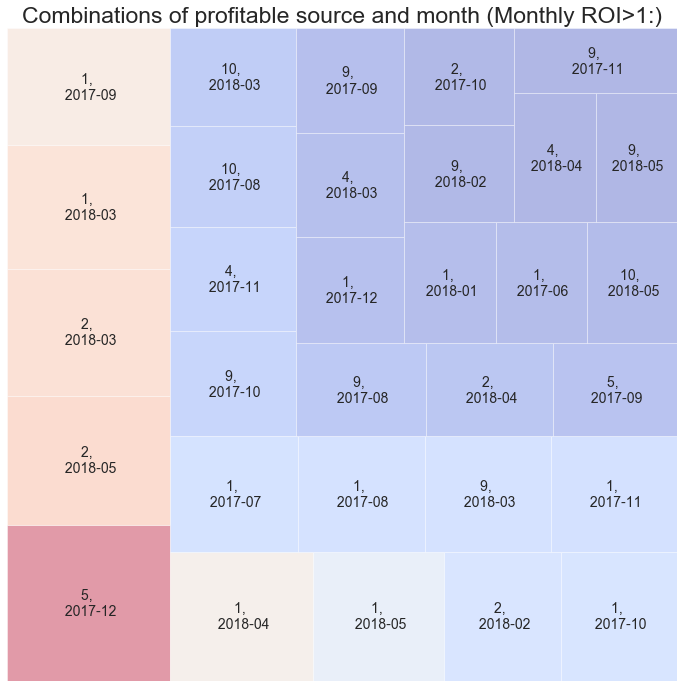

In [405]:
plt.figure(figsize=(12,12))


labels = m_s_roi[m_s_roi['roi']>1].sort_values(by='roi',ascending=False)['source_id']
labels2 = m_s_roi[m_s_roi['roi']>1].sort_values(by='roi',ascending=False)['order_month']
sizes = m_s_roi[m_s_roi['roi']>1].sort_values(by='roi',ascending=False)['roi']


lbl = [str(i)+', \n '+j for i,j in zip(labels, labels2)]

cmap = matplotlib.cm.coolwarm
mini=min(sizes)
maxi=max(sizes)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)

colors = [cmap(norm(value)) for value in sizes]


squarify.plot(sizes=sizes
              , label=lbl
              #, label=labels
             , alpha=0.4
              ,color=colors
              , text_kwargs={'fontsize':14}
             #, pad=True
             )
plt.axis('off')

plt.title('Combinations of profitable source and month (Monthly ROI>1:)',fontsize=23
          #,fontweight="bold"

         )
plt.show()

#### it is the signal to analyse what happen in the source 5  on the 2017-12, but in general sourcer 2 and 1 show best results by ROI

In [406]:
m_s_roi_pivot.pct_change(axis=1)

order_month  2017-06   2017-07   2017-08   2017-09   2017-10   2017-11  \
source_id                                                                
1                NaN  0.338950 -0.004914  0.299227 -0.212537 -0.032156   
2                NaN  0.910802 -0.349660  0.605737  0.327830 -0.178847   
3                NaN  0.130498 -0.226521  0.407510 -0.142485  0.006620   
4                NaN  0.483469 -0.339096  0.119293  0.575457  0.405524   
5                NaN  0.147369  0.088153  0.308186 -0.154724 -0.342974   
9                NaN -0.092450  0.679071 -0.072147  0.184833 -0.210935   
10               NaN -0.182486  1.228282 -0.470254  0.358447 -0.163378   

order_month   2017-12   2018-01   2018-02   2018-03   2018-04   2018-05  
source_id                                                                
1           -0.215541 -0.027485 -0.084282  0.990104 -0.083368 -0.089175  
2            0.094112 -0.240276  1.071319  0.362247 -0.423455  0.777477  
3           -0.039377 -0.130031  0.072502  0.127057 -0.058347  0.399968  
4           -0.265612 -0.222697  0.328852  0.129937 -0.065012 -0.045703  
5            2.945535 -0.696307  0.309730 -0.202140 -0.170414  0.014340  
9           -0.037666 -0.312978  0.542283  0.361119 -0.459980  0.338241  
10          -0.277913 -0.139626  0.442680  0.801423 -0.424936  0.530552

Text(0.5, 1, 'Monthly ROI percentage change by source to the previous period')

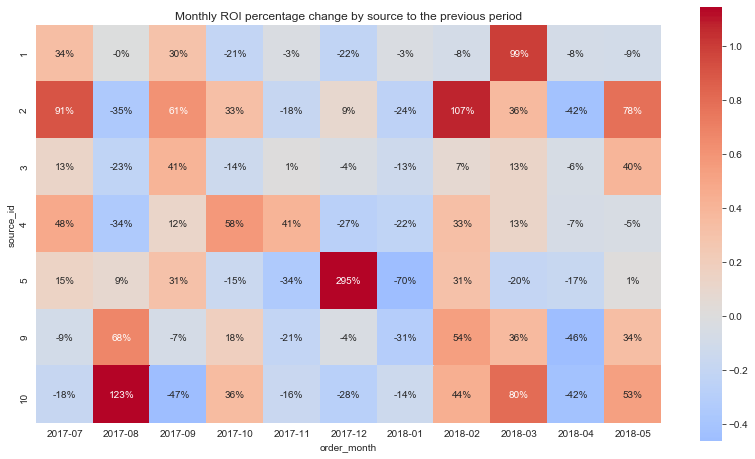

In [407]:
plt.figure(figsize=(14,8))
sns.heatmap(
m_s_roi_pivot.pct_change(axis=1).iloc[:,1:]
    ,center=0
    ,cmap='coolwarm'
            , robust=True #colors
             ,square=True #size
     ,annot=True
                ,fmt='.0%'
    
)
plt.title('Monthly ROI percentage change by source to the previous period')

#### despite source 9 is not stable, it has positive tendency recent months



### when a cohort arrived to breakeven?

In [408]:
recoupment = orders.pivot_table(index = 'first_order_month',
                                     columns = 'cohort_lifetime_month',
                                     values = 'revenue'
                  ,aggfunc='sum').cumsum(axis=1)

In [409]:
cohort_investments = costs.groupby('cost_month')['costs'].sum()

In [410]:
recoupment.divide(cohort_investments, axis = 0)

cohort_lifetime_month        0         1         2         3         4   \
first_order_month                                                         
2017-06-01             0.530530  0.585030  0.634174  0.741379  0.856205   
2017-07-01             0.633623  0.668962  0.734697  0.772542  0.791180   
2017-08-01             0.488747  0.532466  0.574934  0.611176  0.656939   
2017-09-01             0.597833  0.716200  0.771374  1.192464  1.234889   
2017-10-01             0.597866  0.661881  0.684749  0.703525  0.721634   
2017-11-01             0.554931  0.597911  0.619394  0.654377  0.670312   
2017-12-01             0.542015  0.571800  0.677624  0.799484  0.835281   
2018-01-01             0.416173  0.445835  0.476455  0.490823  0.497132   
2018-02-01             0.463807  0.494855  0.503615  0.511887       NaN   
2018-03-01             0.562069  0.597021  0.633675       NaN       NaN   
2018-04-01             0.475594  0.529876       NaN       NaN       NaN   
2018-05-01             0.626601       NaN       NaN       NaN       NaN   

cohort_lifetime_month        5         6         7         8         9   \
first_order_month                                                         
2017-06-01             0.938798  1.045528  1.110838  1.172961  1.240989   
2017-07-01             0.807631  0.820304  0.835255  0.852253  0.867766   
2017-08-01             0.683202  0.702715  0.740230  0.767297  0.784708   
2017-09-01             1.303422  1.377732  1.403485  1.422974       NaN   
2017-10-01             0.736016  0.746150  0.759947       NaN       NaN   
2017-11-01             0.676112  0.688485       NaN       NaN       NaN   
2017-12-01             0.873951       NaN       NaN       NaN       NaN   
2018-01-01                  NaN       NaN       NaN       NaN       NaN   
2018-02-01                  NaN       NaN       NaN       NaN       NaN   
2018-03-01                  NaN       NaN       NaN       NaN       NaN   
2018-04-01                  NaN       NaN       NaN       NaN       NaN   
2018-05-01                  NaN       NaN       NaN       NaN       NaN   

cohort_lifetime_month        10        11  
first_order_month                          
2017-06-01             1.305138  1.333982  
2017-07-01             0.884178       NaN  
2017-08-01                  NaN       NaN  
2017-09-01                  NaN       NaN  
2017-10-01                  NaN       NaN  
2017-11-01                  NaN       NaN  
2017-12-01                  NaN       NaN  
2018-01-01                  NaN       NaN  
2018-02-01                  NaN       NaN  
2018-03-01                  NaN       NaN  
2018-04-01                  NaN       NaN  
2018-05-01                  NaN       NaN

In [411]:
n = recoupment.divide(cohort_investments, axis = 0)

In [412]:
n[n>1]

cohort_lifetime_month  0   1   2         3         4         5         6   \
first_order_month                                                           
2017-06-01            NaN NaN NaN       NaN       NaN       NaN  1.045528   
2017-07-01            NaN NaN NaN       NaN       NaN       NaN       NaN   
2017-08-01            NaN NaN NaN       NaN       NaN       NaN       NaN   
2017-09-01            NaN NaN NaN  1.192464  1.234889  1.303422  1.377732   
2017-10-01            NaN NaN NaN       NaN       NaN       NaN       NaN   
2017-11-01            NaN NaN NaN       NaN       NaN       NaN       NaN   
2017-12-01            NaN NaN NaN       NaN       NaN       NaN       NaN   
2018-01-01            NaN NaN NaN       NaN       NaN       NaN       NaN   
2018-02-01            NaN NaN NaN       NaN       NaN       NaN       NaN   
2018-03-01            NaN NaN NaN       NaN       NaN       NaN       NaN   
2018-04-01            NaN NaN NaN       NaN       NaN       NaN       NaN   
2018-05-01            NaN NaN NaN       NaN       NaN       NaN       NaN   

cohort_lifetime_month        7         8         9         10        11  
first_order_month                                                        
2017-06-01             1.110838  1.172961  1.240989  1.305138  1.333982  
2017-07-01                  NaN       NaN       NaN       NaN       NaN  
2017-08-01                  NaN       NaN       NaN       NaN       NaN  
2017-09-01             1.403485  1.422974       NaN       NaN       NaN  
2017-10-01                  NaN       NaN       NaN       NaN       NaN  
2017-11-01                  NaN       NaN       NaN       NaN       NaN  
2017-12-01                  NaN       NaN       NaN       NaN       NaN  
2018-01-01                  NaN       NaN       NaN       NaN       NaN  
2018-02-01                  NaN       NaN       NaN       NaN       NaN  
2018-03-01                  NaN       NaN       NaN       NaN       NaN  
2018-04-01                  NaN       NaN       NaN       NaN       NaN  
2018-05-01                  NaN       NaN       NaN       NaN       NaN

#### cohort 2017-06 started to payoff on the 6th month, 2017-09 on the third month: that is the same calendar month

# conclusion: advise marketing experts how much money to invest and where.
What sources/platforms would you recommend? Back up your choice: what
metrics did you focus on? Why? What conclusions did you draw after finding
the metric values?

### as the main indicators for the overal conclusion I'd like to point out these 4:

Text(0.5, 1.0, 'Monthly observing of conversion factors')

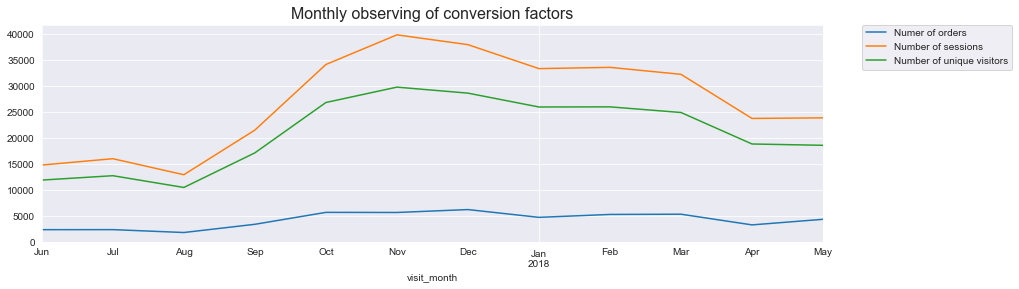

In [413]:
plt.figure(figsize=(14,4))
orders.groupby('order_month')['uid'].count().plot(label='Numer of orders')
visits.groupby('visit_month')['uid'].count().plot(label='Number of sessions')
visits.groupby('visit_month')['uid'].nunique().plot(label='Number of unique visitors')

#plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.title('Monthly observing of conversion factors', fontsize=16)

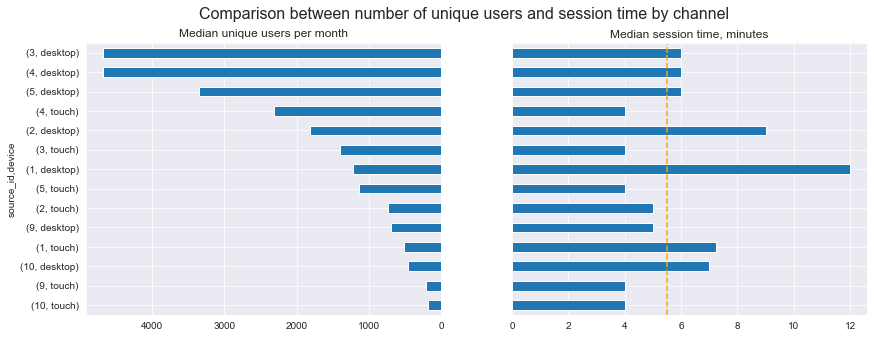

In [414]:
fig, axs = plt.subplots(ncols=2, sharey=True,figsize=(14,5))

fig.suptitle("Comparison between number of unique users and session time by channel", fontsize=16)

pivot_visits_month.mean().sort_values(#ascending=False
).plot(kind='barh'
       , ax=axs[0]
      )

axs[0].invert_xaxis()
axs[0].title.set_text('Median unique users per month')


pivot_visits_month_length.median().reindex(pivot_visits_month.mean().sort_values().index).plot(kind='barh'
                                                                                               , ax=axs[1]
                                                                                              )


axs[1].title.set_text('Median session time, minutes')

plt.axvline(pivot_visits_month_length.median().median()
            ,color = 'orange'
           , linestyle='--'
           ,label='Average ratio')

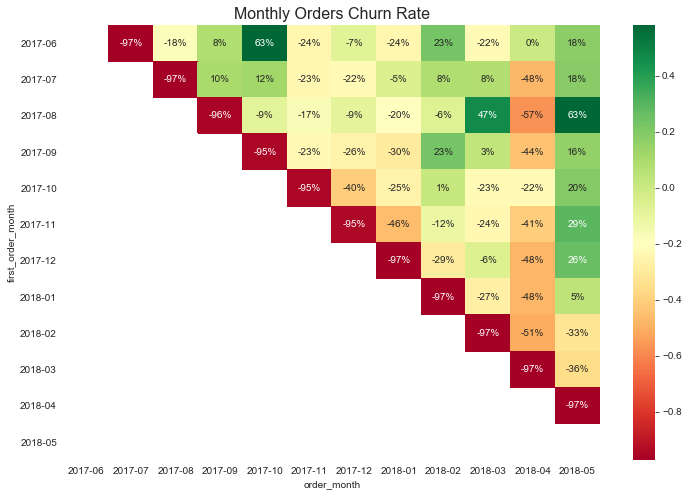

In [415]:

with sns.axes_style("white"):
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(vchurn_orders,
                
               annot=True, 
                fmt='.0%', 
                cmap='RdYlGn',
                robust=True
               )
    plt.title('Monthly Orders Churn Rate', fontsize=16)

Text(0.5, 1, 'Monthly ROI matrix heatmap')

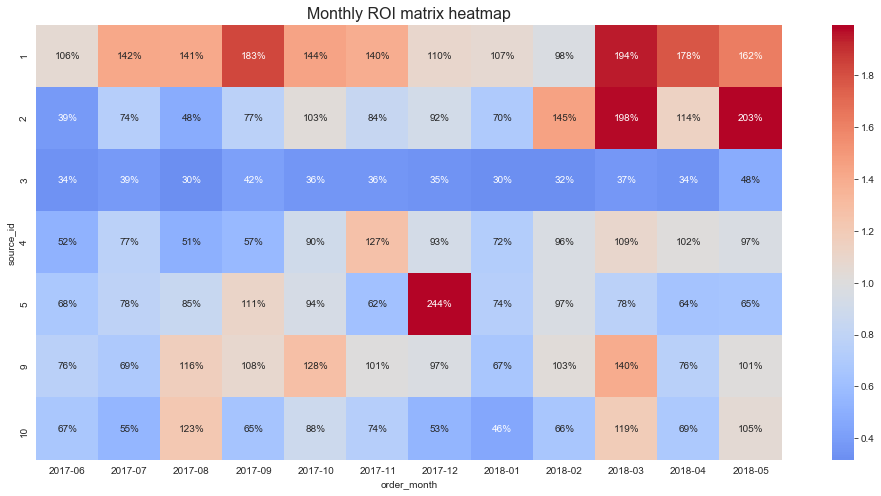

In [416]:
plt.figure(figsize=(18,8))
sns.heatmap(m_s_roi_pivot
           ,cmap='coolwarm'
            , robust=True #colors
             ,square=True #size
            ,center=1
                 ,annot=True
                ,fmt='.0%'
           )

plt.title('Monthly ROI matrix heatmap', fontsize=16)

#### All these indicators are working together:

#### In our case the main way of increasing profit is to increase the amount of deals, because:
1) median revenue from a deal is relatively stable and relatively low, so it could be challenling to rise an 'average bill',
so we can concentrate on the amount

2) with big number of usual byuers will arrive spontanius "big buyers"

3) important to decrease CAC because it is crucial part of revenue in our case

4) important to stimulate existing users proceed new orders, such we can increase ROI 

5) important to measure how many users arrive and how much time do they spend  

6) On 'Monthly observing of conversion factors' we can monitor overal activity

7) On Monthly Churn Rate we can notify if we had a problem or a bonus for all the visitors, or only for specific population

#### As overall assumption I'd recommend to investigate how could be ROI increased by chooseing for a specific source the most appropriate device. In our case I can't trace it and assume that between two we should give the priority by higher amount of visitors.

#### As the second overall assumtion I'd like to investigate the dependancy between the lenght time and the ROI, becuse my assumtion is that the value should be close or higher than the average.

#### Upon this I could propose:

1) Invest in the Source_1, because it is already proved itself becase paied-off and has the best constant ROI. Relevantly for both device:  the lenght time for both devices here is more, than median.

2) Invest in the Source_2 because it is also already paied-off and has good recent tendency. But Source_2 is one of expensive sources, so it could be investigated. It has high indicator of session lenght for Desktop and higher number of visitors.

3) Mind about investing in Source 9 becuse it is close to pay-off and has positive 'churn' volatility. Source_9 has much higher number of users for the Desktop, with about equal lenght time.

4) Mind about rejection the Source_5 because it has only one positive roi month, but that was a "boost" month.Also Source_5 is one of the most expensive sources. So it could be investigated.

5) Mind about reject Source_3 because is the most expensive and not profitable.

6) Mind about rejection Source_4 because it is expensive and not profitable.